# COVID-19 Data Analyses using Johns Hopkins Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is the Johns Hopkins University's Center for Systems Science and Engineering (CSSE) 
[COVID-19 data repository](https://github.com/CSSEGISandData/COVID-19).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the Johns Hopkins COVID-19 CSV files into a [Pandas](https://pandas.pydata.org/) DataFrame. It
then manipulates, queries, and plots the DataFrame.

[**I don't want to look at code. Take me to the first graph!**](#United-States)

[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date, timezone
import csv
import os
import sys
import re
import math
from pprint import pprint
from enum import Enum
from itertools import chain
from lib.common import *
from lib.plot import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")
now = datetime.now(timezone.utc)
print(f"Last run on {now.strftime('%Y-%m-%d')} at {now.strftime('%H:%M:%S %Z')}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5
Last run on 2020-09-28 at 15:16:52 UTC


In [2]:
JOHNS_HOPKINS_US_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'
# The detailed path contains other countries and has data down to the US county level.
JOHNS_HOPKINS_DETAILED_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'
SOURCE = "Johns Hopkins University Center for Systems Science and Engineering (CSSE)"

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## Helpers

In [4]:
def read_raw_data(dir: str) -> pd.DataFrame:
    """
    Read the raw data, consisting of a number of CSV files
    with timestamped names, into a single Pandas DataFrame.
    Does not translate the columns or clean anything up.
    """
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    data_frames = []
    for f in os.listdir(dir):
        # Skip any file that doesn't match the regex. It'd
        # probably be sufficient to check the extension, but
        # this approach is more robust.
        m = f_pat.match(f)
        if m is None:
            continue
        df = pd.read_csv(os.path.join(dir, f))
        file_date = datetime.strptime(m.group(1), '%m-%d-%Y')
        if file_date < STARTING_DATE:
            continue

        df['Date'] = file_date
        # Now, convert to Pandas datetime. You can't store a regular
        # Python date or datetime in Pandas and then operate on it
        # using Pandas datetime functions. It has to be a Pandas
        # datetime.
        df['Date'] = pd.to_datetime(df['Date'])
        data_frames.append(df)

    return pd.concat(data_frames, ignore_index=True)

def read_top_level_us_data() -> pd.DataFrame:
    """
    Read all CSV files into a single Pandas DataFrame, normalizing
    the column names and discarding the ones we don't want.
    
    The DataFrame will be sorted by date.
    """
    df = read_raw_data(JOHNS_HOPKINS_US_DIR_PATH)[[
        'Date', 'Province_State', 'Confirmed', 'Deaths', 'Recovered',
        'People_Tested', 'People_Hospitalized'
    ]]

    final_df = df.rename(columns={
        'Province_State':      COL_REGION,
        'Date':                COL_DATE,
        'Deaths':              COL_DEATHS,
        'People_Tested':       COL_TESTS,
        'Confirmed':           COL_CASES,
        'Recovered':           COL_RECOVERIES,
        'People_Hospitalized': COL_HOSPITALIZATIONS
    })

    for col in (COL_DEATHS, COL_CASES, COL_TESTS, COL_RECOVERIES, COL_HOSPITALIZATIONS):
        final_df[col] = final_df[col].fillna(0)

    final_df = final_df.astype({
        COL_DEATHS: int,
        COL_CASES: int,
        COL_HOSPITALIZATIONS: int,
        COL_RECOVERIES: int,
        COL_TESTS: int
    })

    make_month_day_column(final_df)

    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

In [5]:
def read_us_county_data() -> pd.DataFrame:
    """
    Reads the Johns Hopkins COVID-19 data that contains
    more detailed data, down to the county. Then, weed
    out non-US data and normalize the rest somewhat.
    """
    df = read_raw_data(JOHNS_HOPKINS_DETAILED_DIR_PATH)
    df2 = df.loc[df['Country_Region'] == 'US'][[
        'Date', 'Admin2', 'Province_State', 'Confirmed',
        'Deaths', 'Recovered'
    ]]

    final_df = df2.rename(columns={
        'Date':           COL_DATE,
        'Admin2':         COL_COUNTY,
        'Province_State': COL_REGION,
        'Confirmed':      COL_CASES,
        'Deaths':         COL_DEATHS,
        'Recovered':      COL_RECOVERIES,
    })

    for col in (COL_DEATHS, COL_CASES, COL_RECOVERIES):
        final_df[col] = final_df[col].fillna(0)

    make_month_day_column(final_df)
    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

## Read the data

### Load the state population data

In [6]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,340


### Load the Johns Hopkins data

In [7]:
%ls $JOHNS_HOPKINS_US_DIR_PATH

04-12-2020.csv  05-16-2020.csv  06-19-2020.csv  07-23-2020.csv  08-26-2020.csv
04-13-2020.csv  05-17-2020.csv  06-20-2020.csv  07-24-2020.csv  08-27-2020.csv
04-14-2020.csv  05-18-2020.csv  06-21-2020.csv  07-25-2020.csv  08-28-2020.csv
04-15-2020.csv  05-19-2020.csv  06-22-2020.csv  07-26-2020.csv  08-29-2020.csv
04-16-2020.csv  05-20-2020.csv  06-23-2020.csv  07-27-2020.csv  08-30-2020.csv
04-17-2020.csv  05-21-2020.csv  06-24-2020.csv  07-28-2020.csv  08-31-2020.csv
04-18-2020.csv  05-22-2020.csv  06-25-2020.csv  07-29-2020.csv  09-01-2020.csv
04-19-2020.csv  05-23-2020.csv  06-26-2020.csv  07-30-2020.csv  09-02-2020.csv
04-20-2020.csv  05-24-2020.csv  06-27-2020.csv  07-31-2020.csv  09-03-2020.csv
04-21-2020.csv  05-25-2020.csv  06-28-2020.csv  08-01-2020.csv  09-04-2020.csv
04-22-2020.csv  05-26-2020.csv  06-29-2020.csv  08-02-2020.csv  09-05-2020.csv
04-23-2020.csv  05-27-2020.csv  06-30-2020.csv  08-03-2020.csv  09-06-2020.csv
04-24-2020.csv  05-28-2020.csv  07-01-2020.csv  08-0

In [8]:
%head $JOHNS_HOPKINS_US_DIR_PATH/04-12-2020.csv

Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,,3470,1,75.98802021,21583,437,2.610159978,84000001,USA,460.3001516,12.26494527
Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66,264,2,45.50404936,8038,31,2.941176471,84000002,USA,1344.711576,11.39705882
Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,,3427,4,48.66242224,42109,,3.246753247,84000004,USA,578.5222863,
Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367,1253,5,49.43942261,19722,130,2.109375,84000005,USA,761.7533537,10.15625
California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,,22155,6,58.13772584,190328,5234,2.81202018,84000006,USA,485.4238685,22.9611757
Colorado,US,2020-04-12 23:18:15,39.0598,-105.3111,7307,289,,7018,8,128.943729,34873,1376,3.955111537,84000008,USA,615.3899908,18.8312577
C

In [9]:
df = read_top_level_us_data()

In [10]:
df

date         region   cases  deaths  recoveries    tests  \
3175 2020-04-12       New York  189033    9385       23887   461601   
3170 2020-04-12       Nebraska     791      17           0    10691   
3171 2020-04-12         Nevada    2836     112           0    24611   
3172 2020-04-12  New Hampshire     929      23         236    10925   
3173 2020-04-12     New Jersey   61850    2350           0   126735   
...         ...            ...     ...     ...         ...      ...   
7987 2020-09-27  Massachusetts  130642    9404      111479  3881846   
7988 2020-09-27       Michigan  134373    7044       95051  3543057   
7989 2020-09-27      Minnesota   96734    2060       86252  1981100   
7977 2020-09-27         Hawaii   12116     132       10126   291657   
7991 2020-09-27       Missouri  125026    2053           0  1298106   

      hospitalizations month_day  
3175             42594     04/12  
3170                 0     04/12  
3171               282     04/12  
3172               146     04/12  
3173              7604     04/12  
...                ...       ...  
7987                 0     09/27  
7988                 0     09/27  
7989                 0     09/27  
7977                 0     09/27  
7991                 0     09/27  

[9820 rows x 8 columns]

In [11]:
jhu_starting_date = df.date.min().date()
jhu_ending_date = df.date.max().date()
# See https://stackoverflow.com/a/15411596
total_unique_dates = len(df.groupby('date').date.nunique())
print(f"Loaded data for {total_unique_dates} days.")
# len(dataframe.index) is the idiom for getting the number of rows.
print(f"Total rows: {len(df.index):,}")
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Loaded data for 169 days.
Total rows: 9,820
Starting date: 04/12/2020
Ending date: 09/27/2020


In [12]:
df_counties = read_us_county_data()

In [13]:
df_counties

date       county          region  cases  deaths  recoveries  \
198142 2020-04-12    Abbeville  South Carolina      9       0           0   
199955 2020-04-12    Ontonagon        Michigan      0       0           0   
199956 2020-04-12       Orange      California   1277      19           0   
199957 2020-04-12       Orange         Florida    949      13           0   
199958 2020-04-12       Orange         Indiana     17       3           0   
...           ...          ...             ...    ...     ...         ...   
506372 2020-09-27   Silver Bow         Montana    255       0           0   
506373 2020-09-27   Stillwater         Montana     69       2           0   
506374 2020-09-27  Sweet Grass         Montana     43       1           0   
506376 2020-09-27        Toole         Montana     76       6           0   
505572 2020-09-27      Osceola            Iowa    168       0           0   

       month_day  
198142     04/12  
199955     04/12  
199956     04/12  
199957     04/12  
199958     04/12  
...          ...  
506372     09/27  
506373     09/27  
506374     09/27  
506376     09/27  
505572     09/27  

[526490 rows x 7 columns]

In [14]:
print(f"COUNTY DATA:")
print(f"Read data for {len(df_counties[COL_DATE].unique())} days.")
print(f"Starting date: {datestr(df_counties[COL_DATE].min(), include_year=True)}")
print(f"Ending date: {datestr(df_counties[COL_DATE].max(), include_year=True)}")

COUNTY DATA:
Read data for 169 days.
Starting date: 04/12/2020
Ending date: 09/27/2020


## Deaths and cases in a single region

### United States

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46d1719d90>)

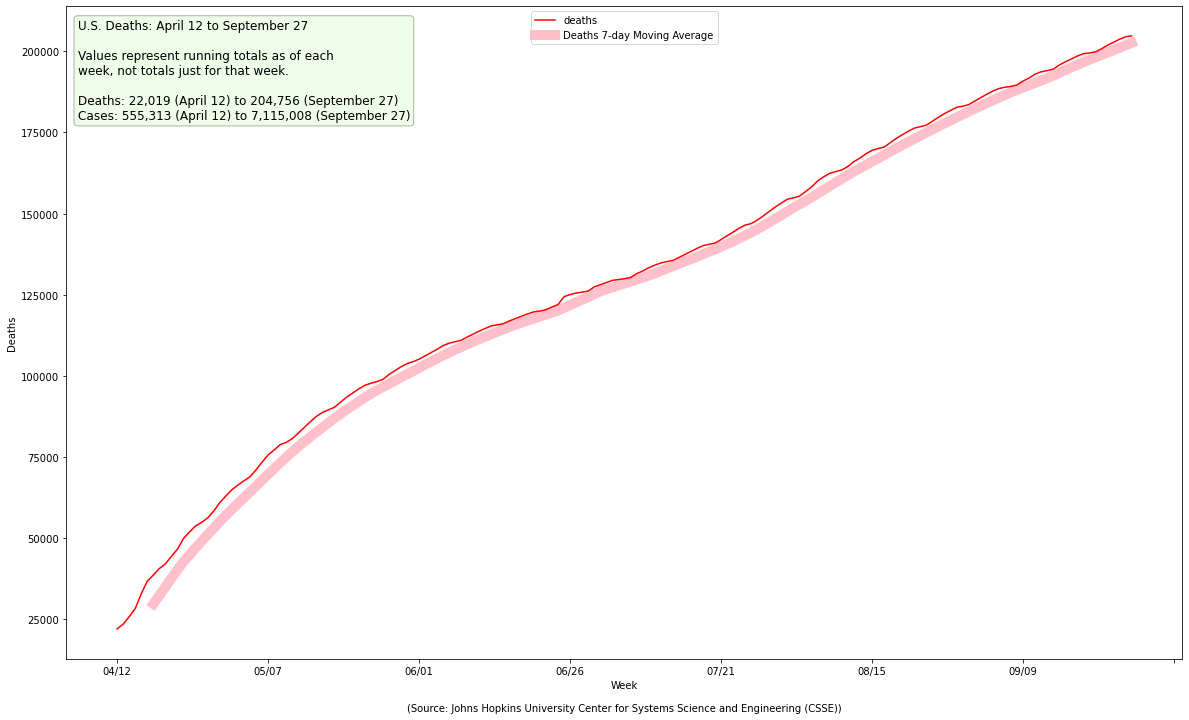

In [15]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='jhu-us-deaths.png', textbox_heading="U.S. Deaths")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bb8fbdc0>)

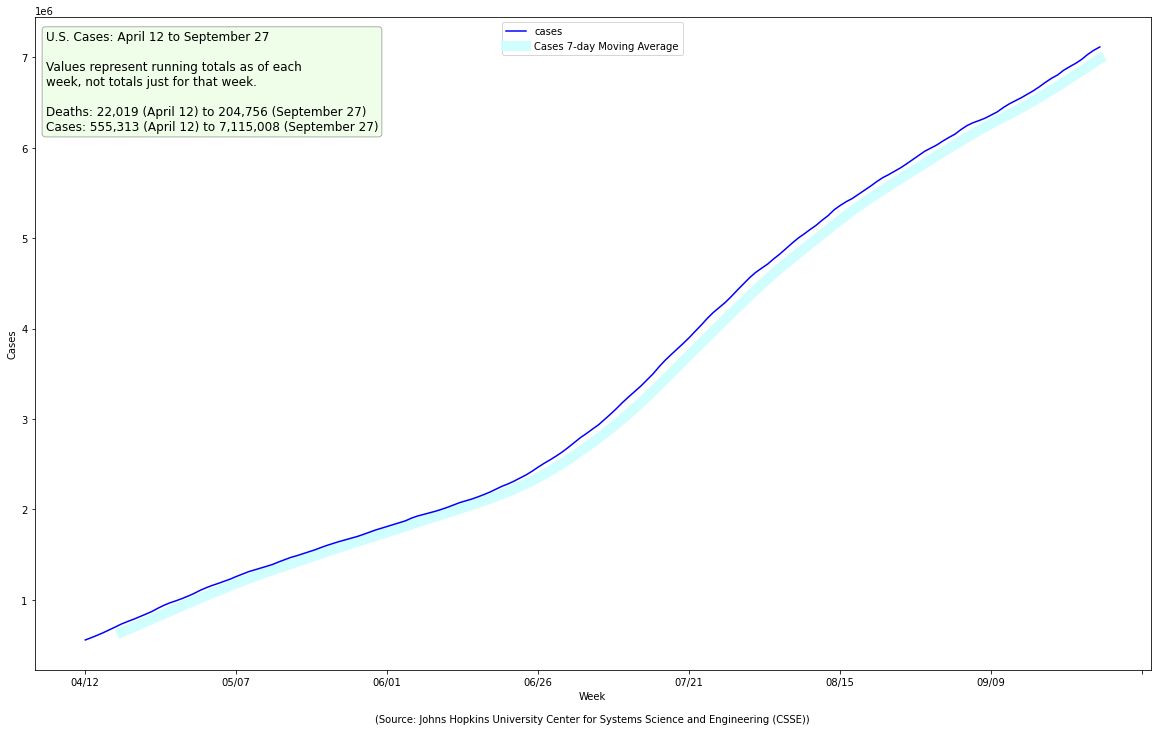

In [16]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.CASES}, moving_average=True,
                   image_file='jhu-us-cases.png', textbox_heading="U.S. Cases")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bb8c6400>)

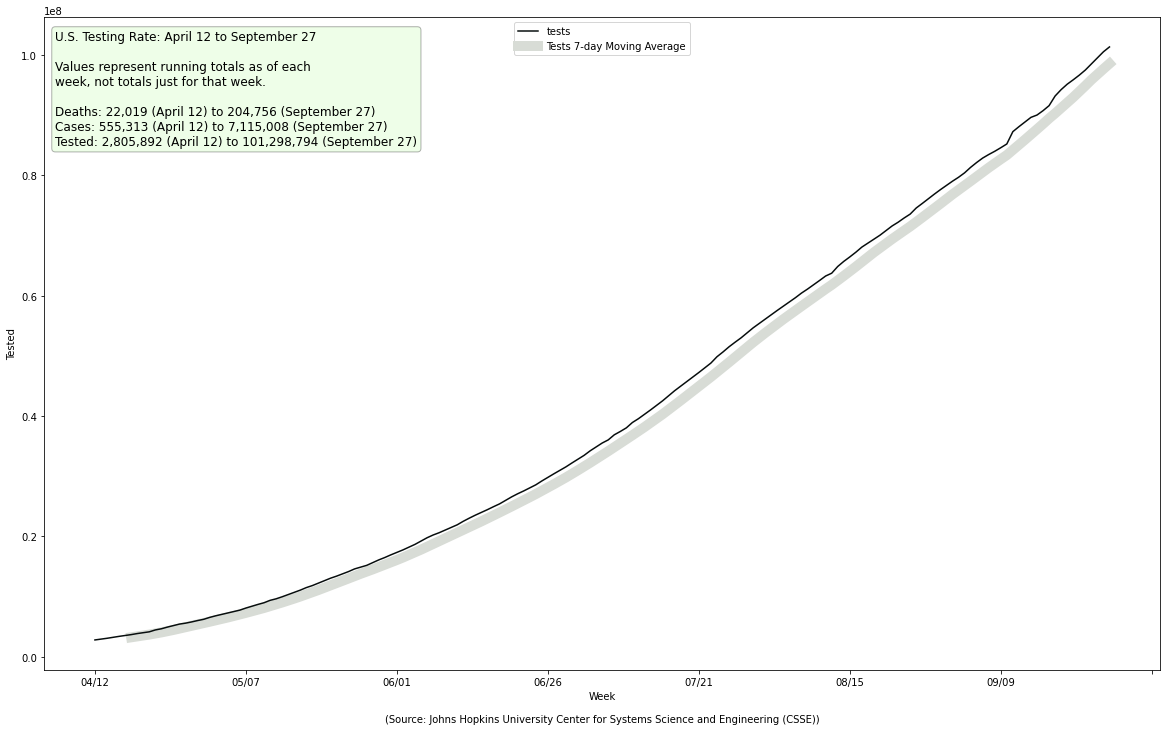

In [17]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.TESTED}, moving_average=True,
                   image_file='jhu-us-tested.png', textbox_heading="U.S. Testing Rate")

#### Positivity Rate

The positivity rate is problematic. At the beginning of the pandemic,
we weren't testing much at all, and the tests were reserved largely
for those showing symptoms. So the positivity rate was, not surprisingly,
quite high. It will have declined over time, because we're testing more
of the population, including more people who come up negative.

Rather than plot the positivity rate since April, which is somewhat
misleading, just plot the positivity rate for the last 45 days.

**Note**: A drop-off toward the end isn't necessarily cause for celebration.
Reporting of cases probably lags.

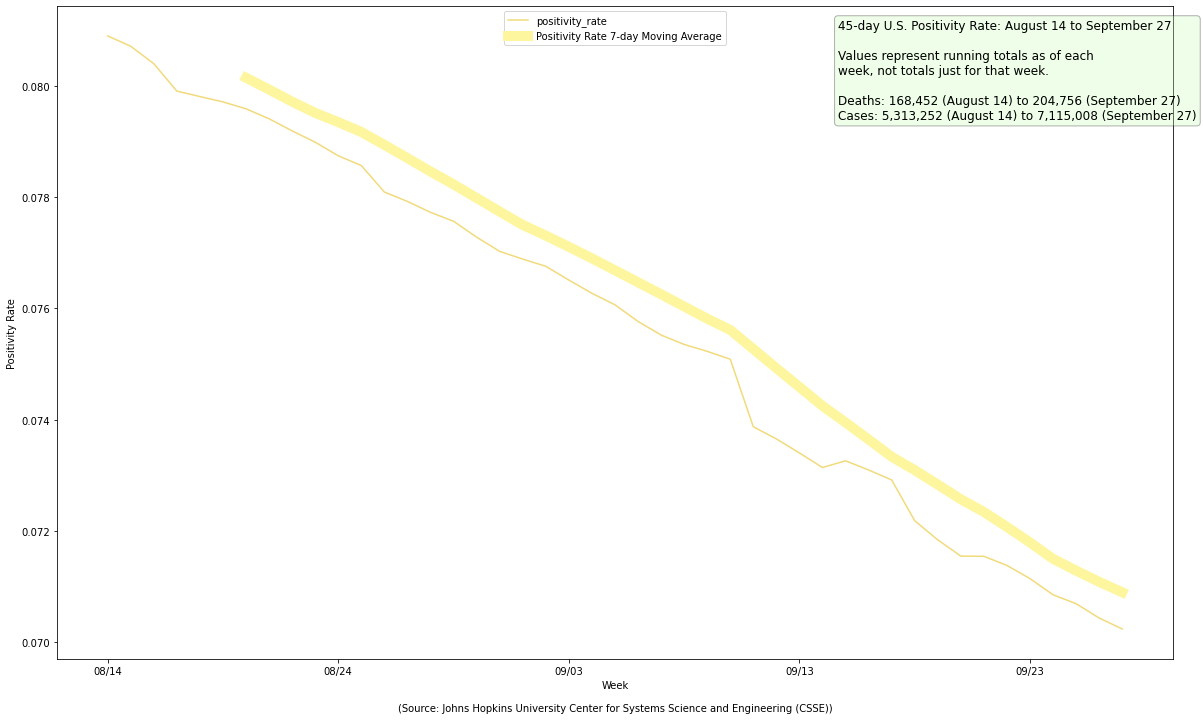

In [18]:
delta = timedelta(days=45)
cutoff = date_to_datetime(today - delta)
df_positivity_dates = df.loc[df.date >= cutoff]
fig, ax = plot_stats_by_date(df_positivity_dates, SOURCE, metrics={MetricType.POSITIVITY},
                             image_file='jhu-us-positivity-rate.png', 
                             textbox_heading="45-day U.S. Positivity Rate",
                             textbox_loc=(0.7, 0.98),
                             moving_average=True)

#### Daily values, instead of cumulative values

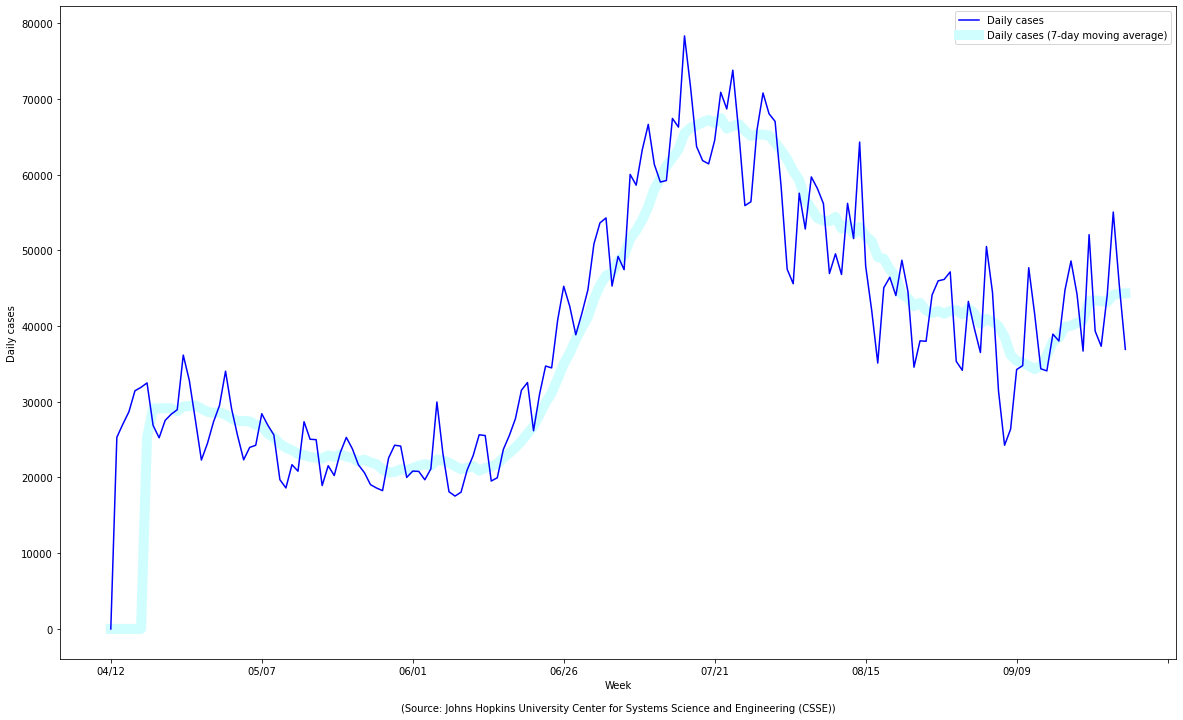

In [19]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='United States',
                 moving_average=True,
                 image_file="jhu-us-cases-daily.png");

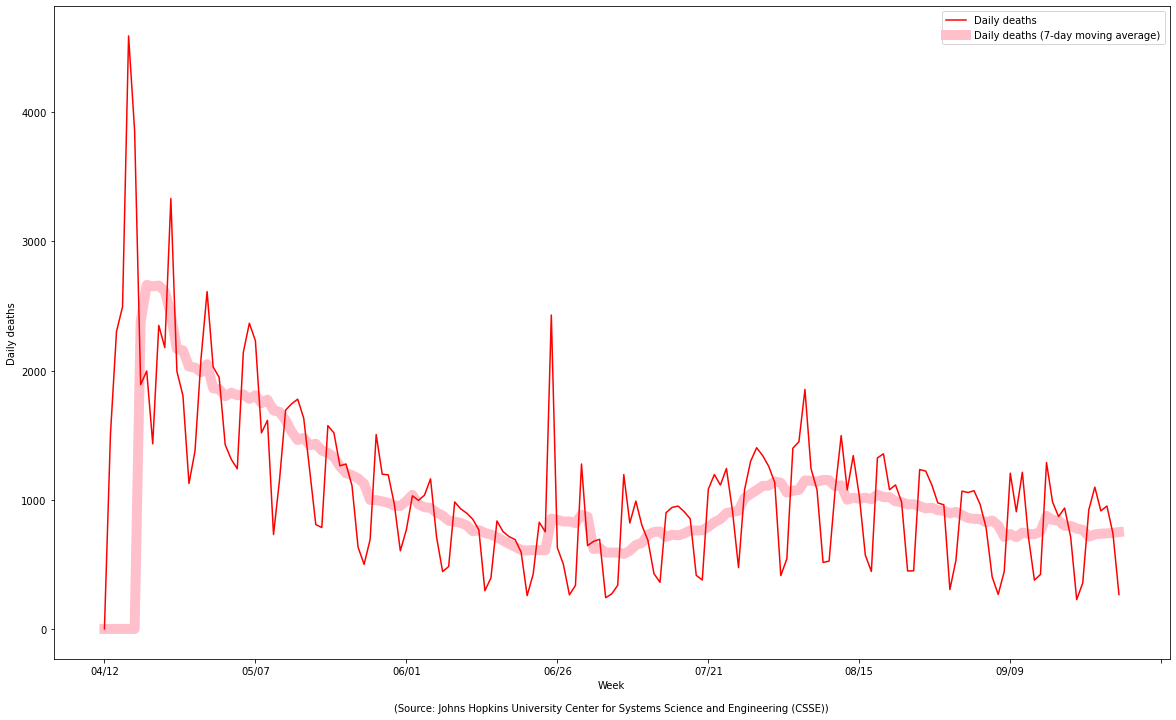

In [20]:
fig, ax, df_with_diffs = plot_daily_stats(df, 
                                          source=SOURCE,
                                          metric=MetricType.DEATHS,
                                          region='United States',
                                          moving_average=True,
                                          image_file="jhu-us-deaths-daily.png")

In [21]:
max_date = df_with_diffs.date.max()
df_with_diffs.loc[df_with_diffs.date == max_date]

date    cases  deaths  recoveries      tests  hospitalizations  \
168 2020-09-27  7115008  204756     2766280  101298794                 0   

            region month_day   diff     diff_ma  
168  United States     09/27  266.0  749.571429

#### Just the past week

In [22]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(jhu_ending_date, hour=23, minute=59, second=59)

df_past_week = df.loc[(df[COL_DATE] >= last_week_start) & (df[COL_DATE] <= last_week_end)]

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bdc92520>)

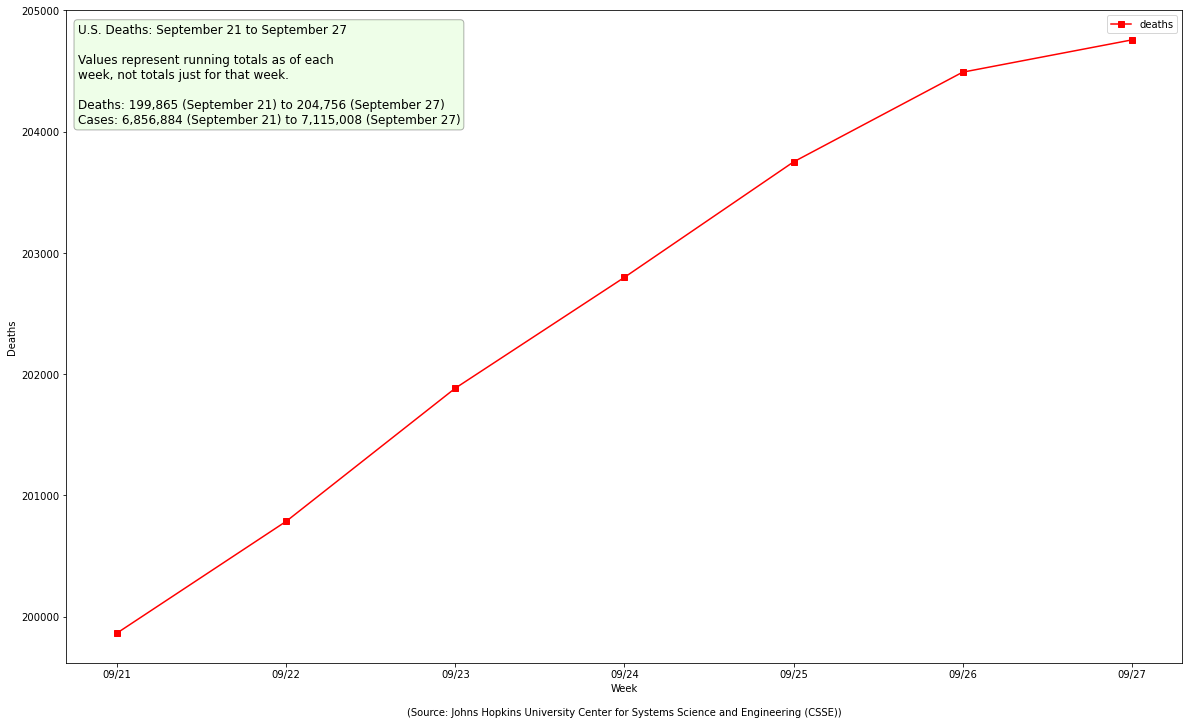

In [23]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='jhu-us-deaths-past-week.png')

#### Deaths vs. Cases

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc650bb0>)

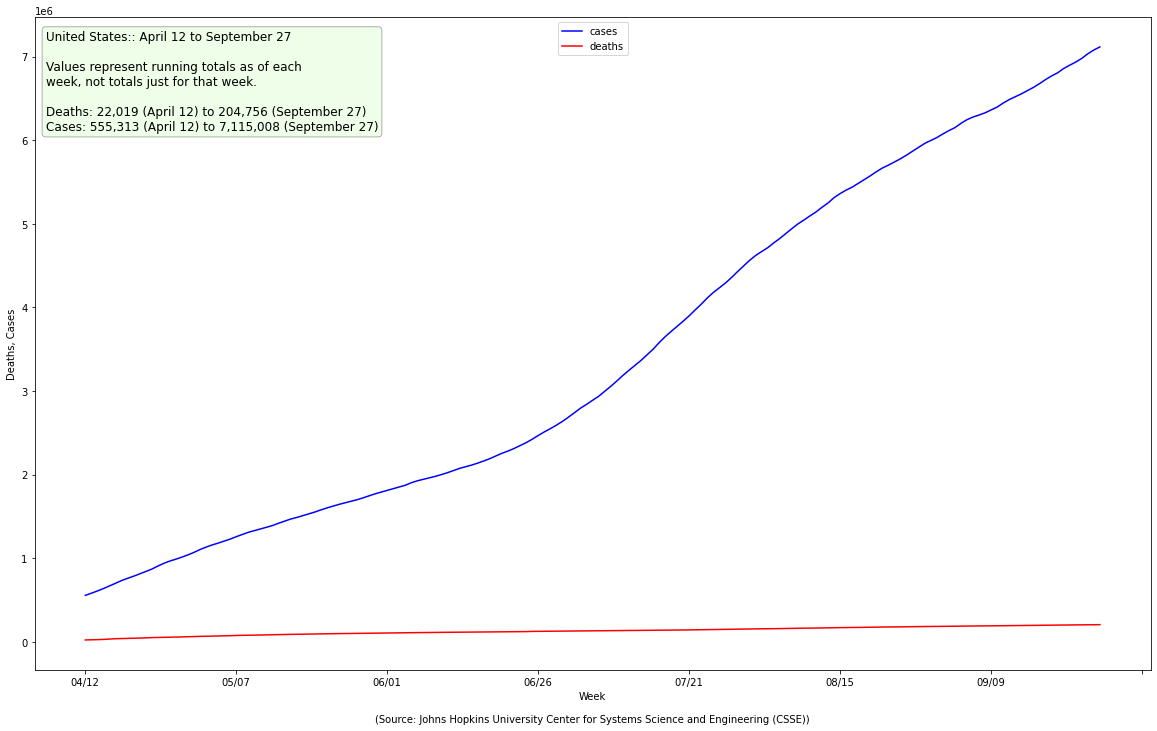

In [24]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS, MetricType.CASES}, 
                   textbox_heading="United States:", image_file="jhu-us-deaths-and-cases.png")

### Individual States

#### Pennsylvania

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bce6daf0>)

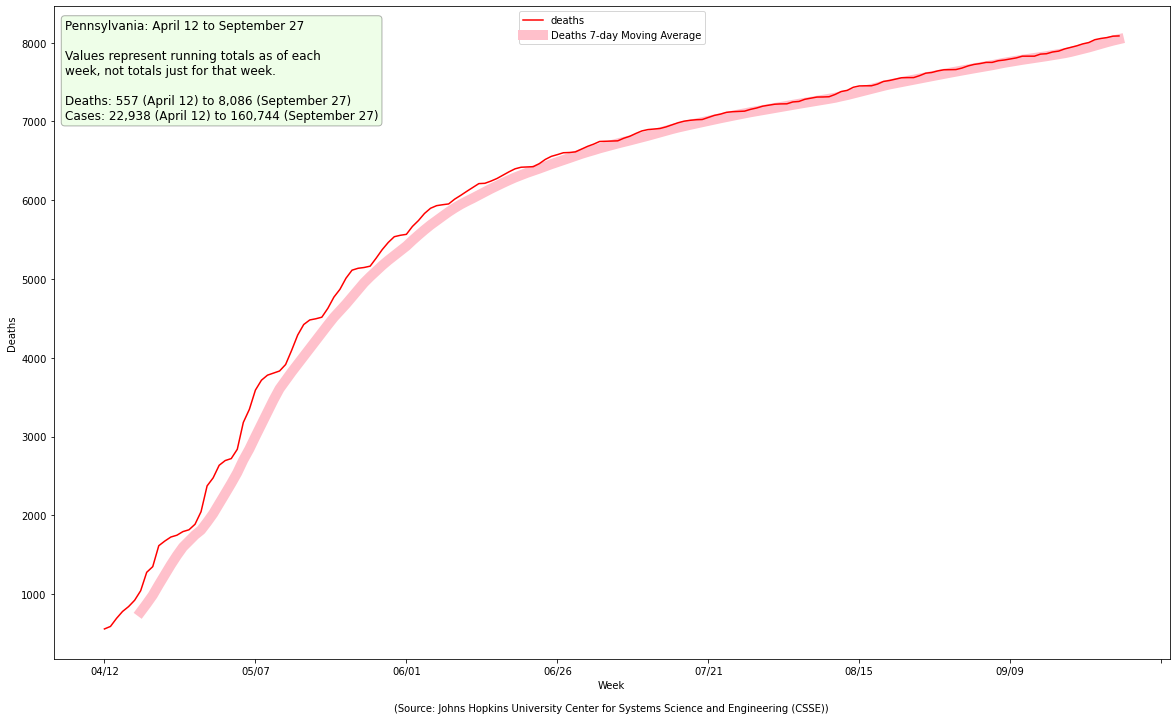

In [25]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bce71cd0>)

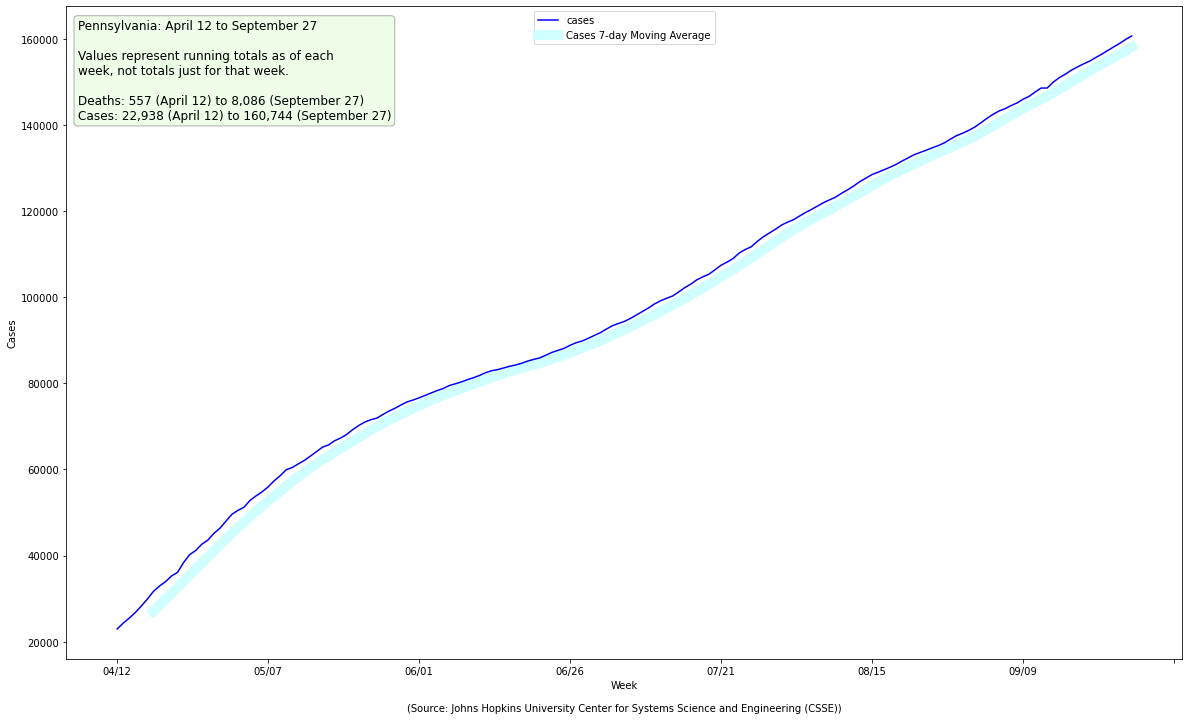

In [26]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bd4c0b20>)

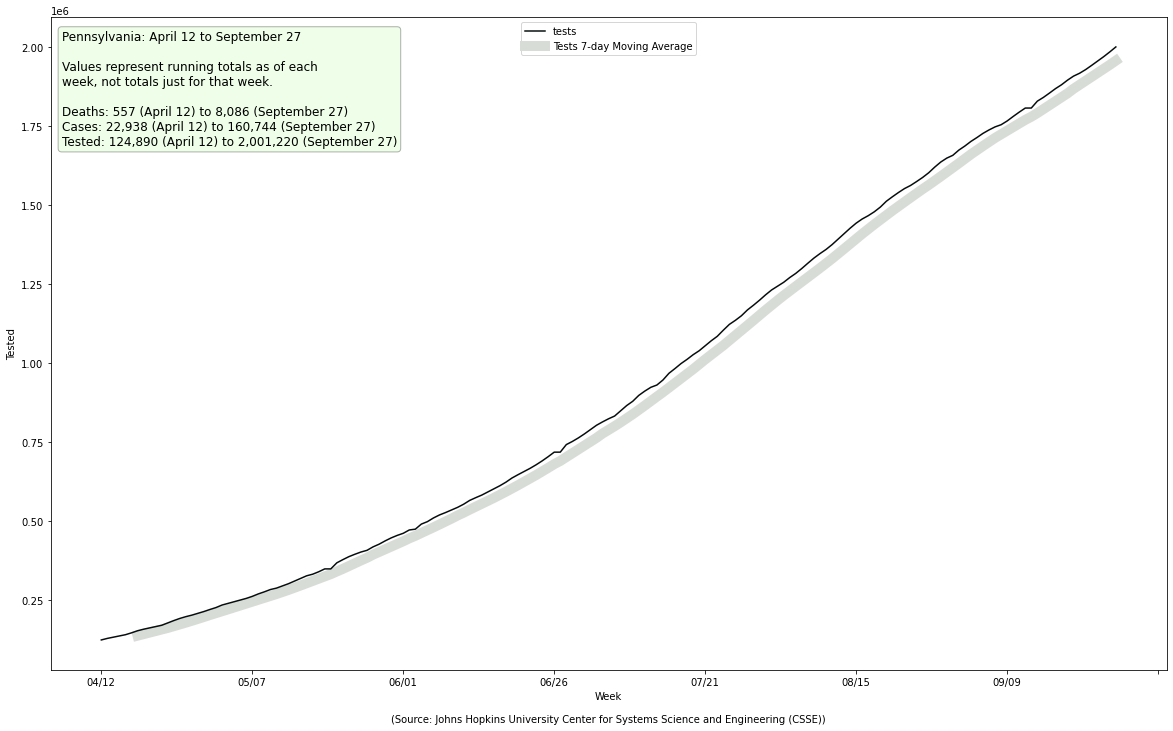

In [27]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46b9d87d90>)

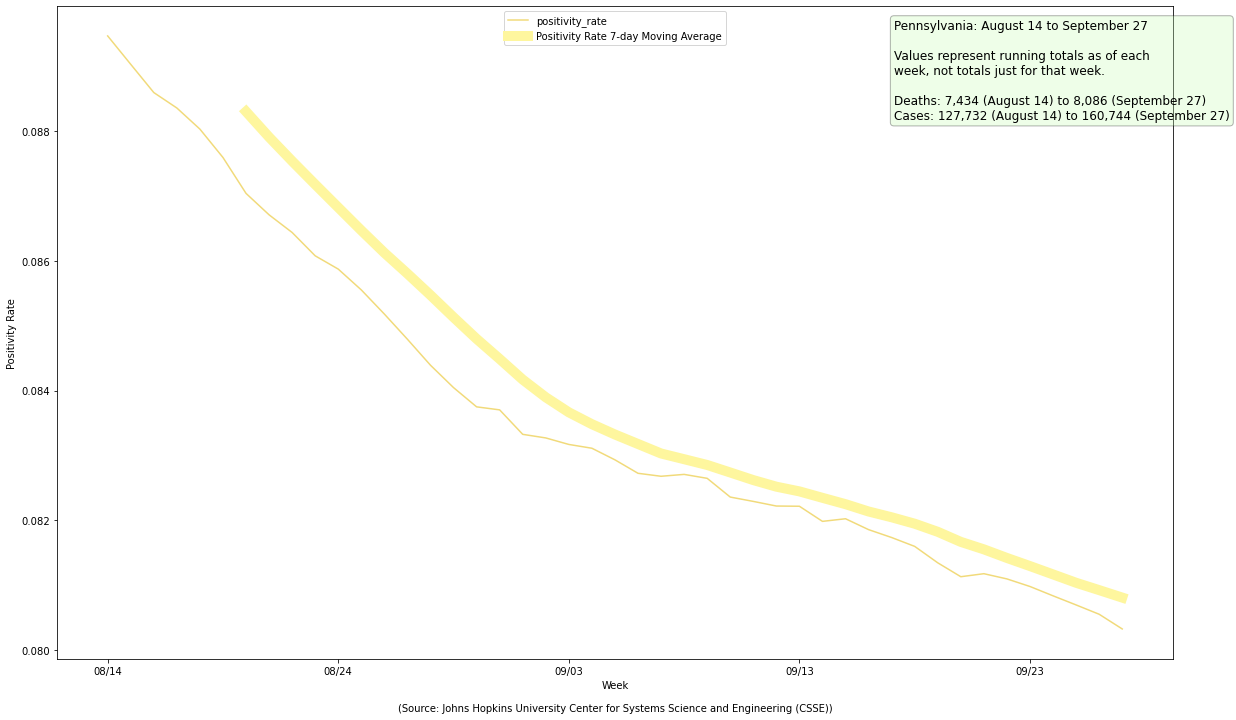

In [28]:
# Note caveats on positivity rate in the U.S. section, above.
plot_state(df_positivity_dates, SOURCE, 'Pennsylvania', metrics={MetricType.POSITIVITY},
           image_file='jhu-pa-positivity.png', moving_average=True, textbox_loc=(0.75, 0.98))

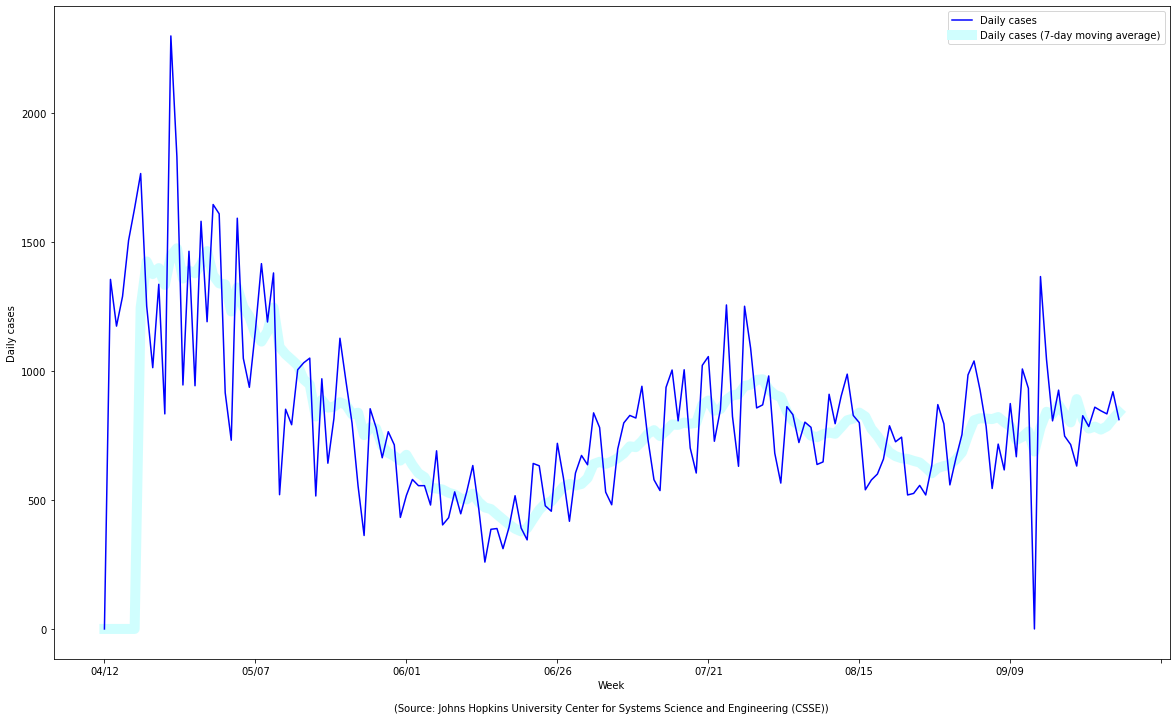

In [29]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-cases-daily.png");

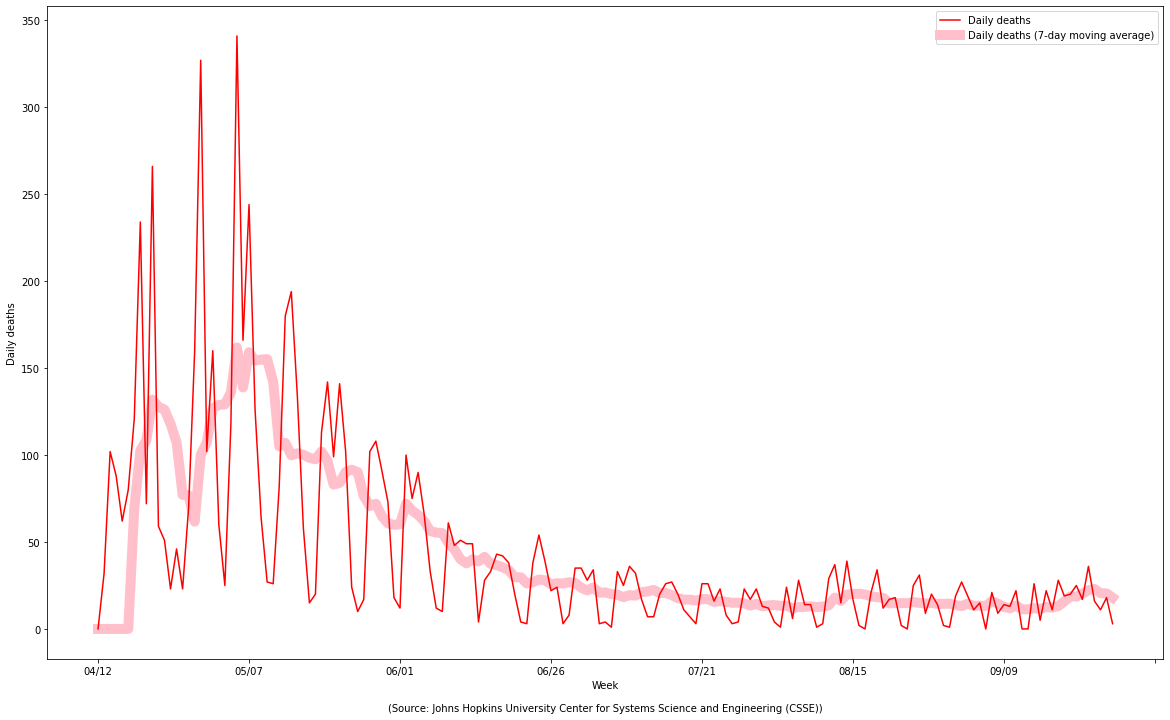

In [30]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-deaths-daily.png");

#### New York

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46ba887dc0>)

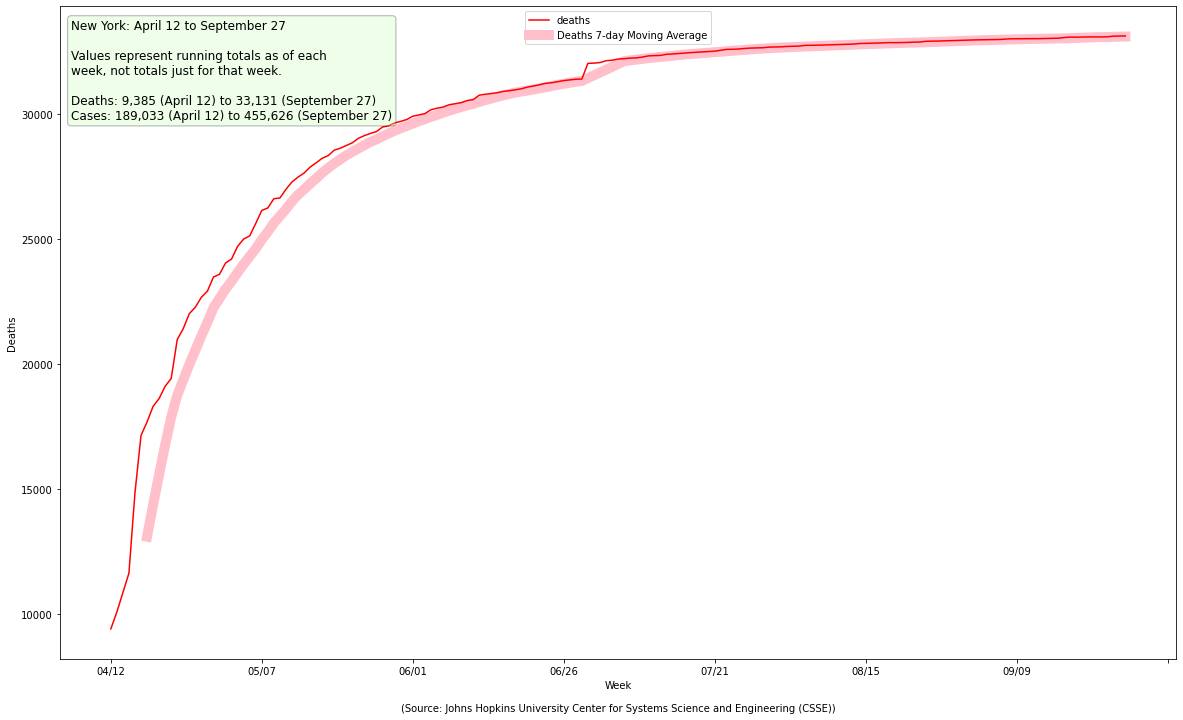

In [31]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46b9cad1c0>)

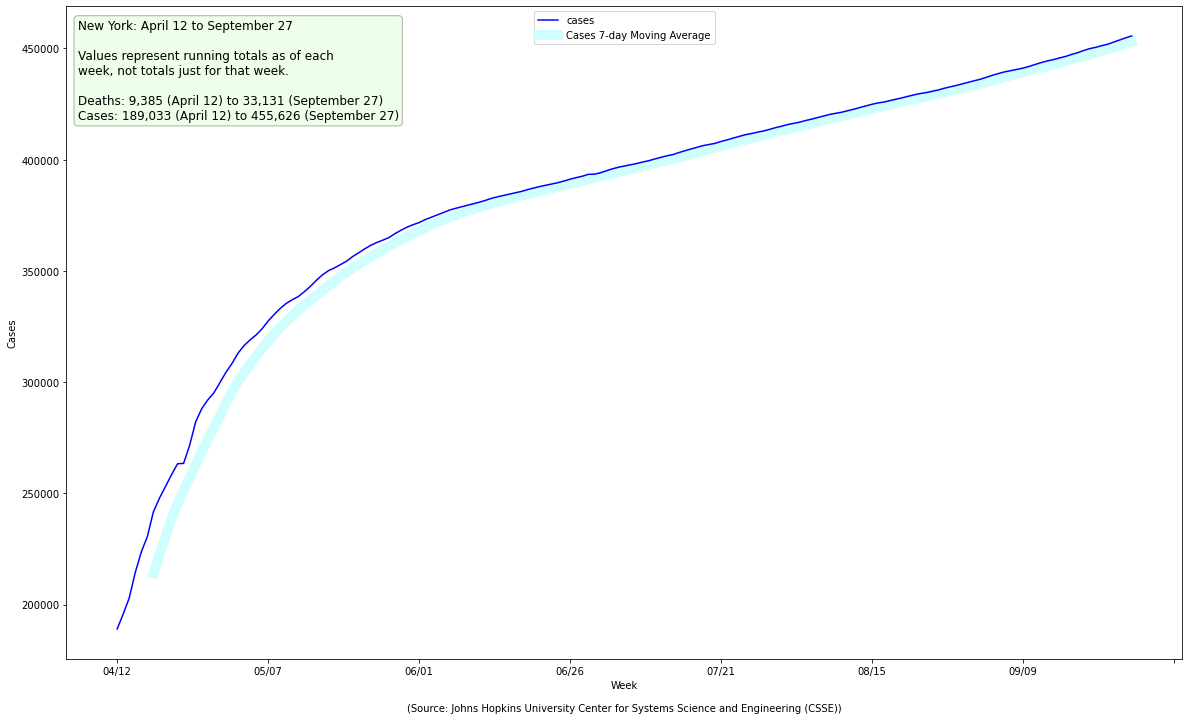

In [32]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc9be430>)

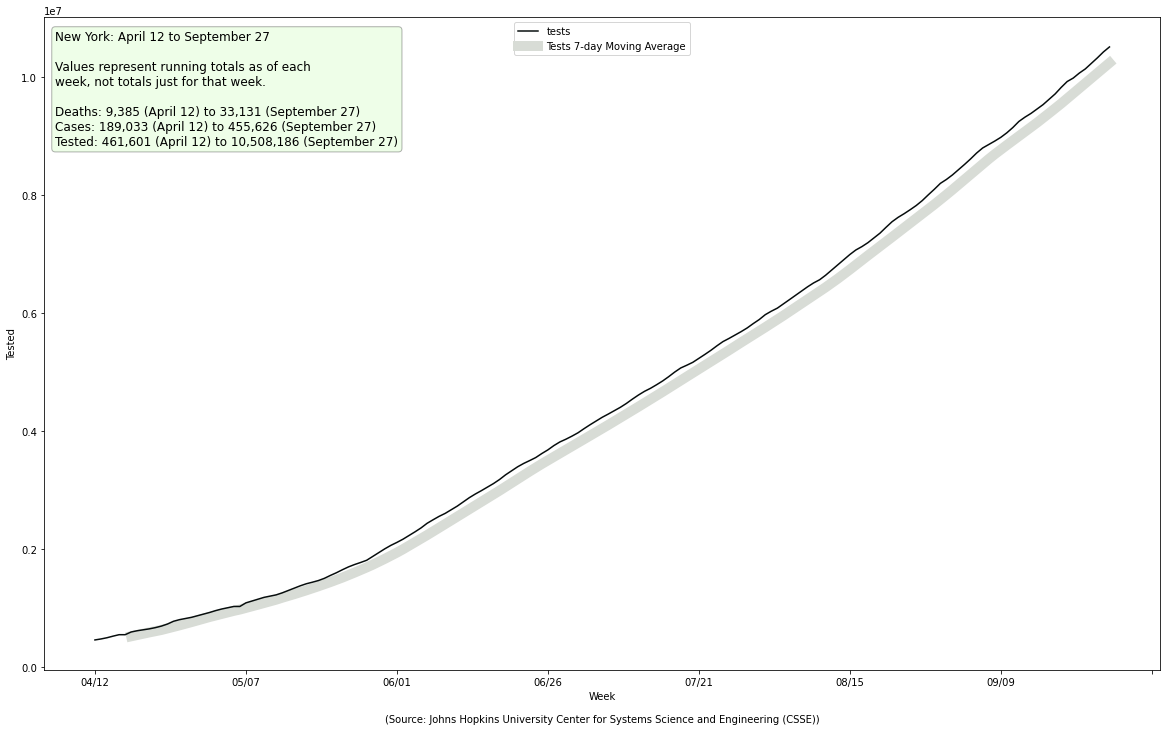

In [33]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc9bc760>)

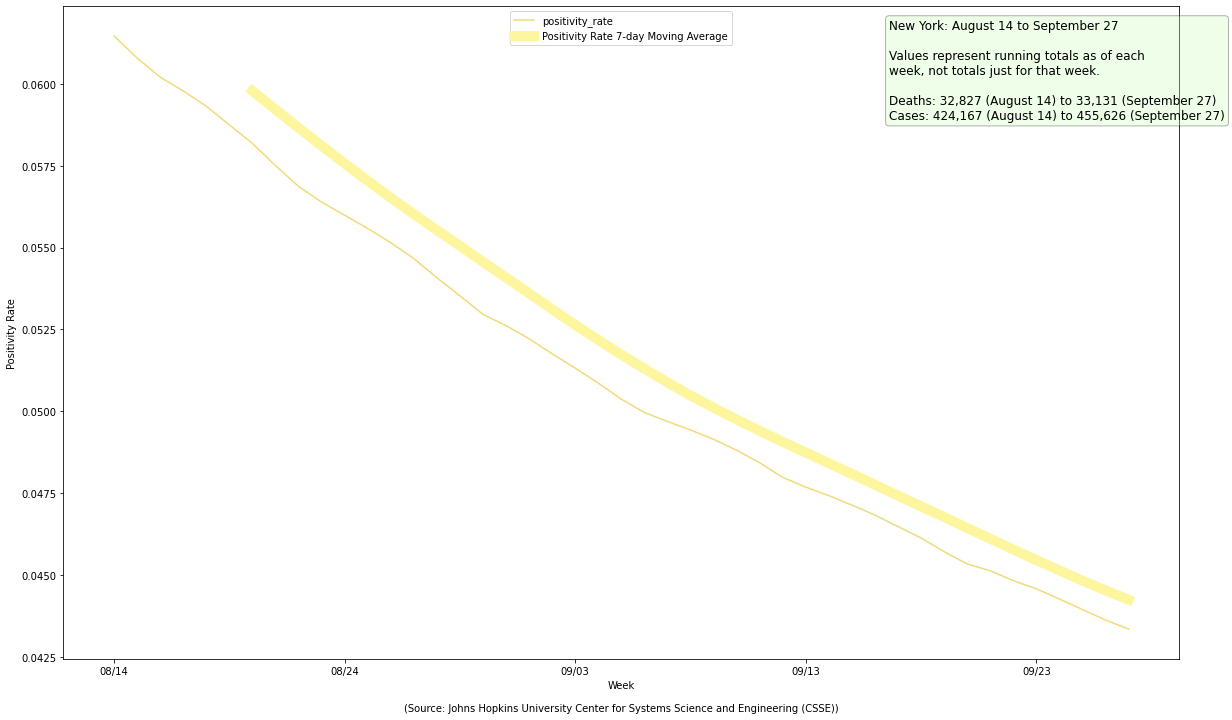

In [34]:
plot_state(df_positivity_dates, SOURCE, 'New York', image_file='jhu-ny-pos.png', 
           metrics={MetricType.POSITIVITY}, textbox_loc=(0.74, 0.98), moving_average=True)

#### California

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46ba203850>)

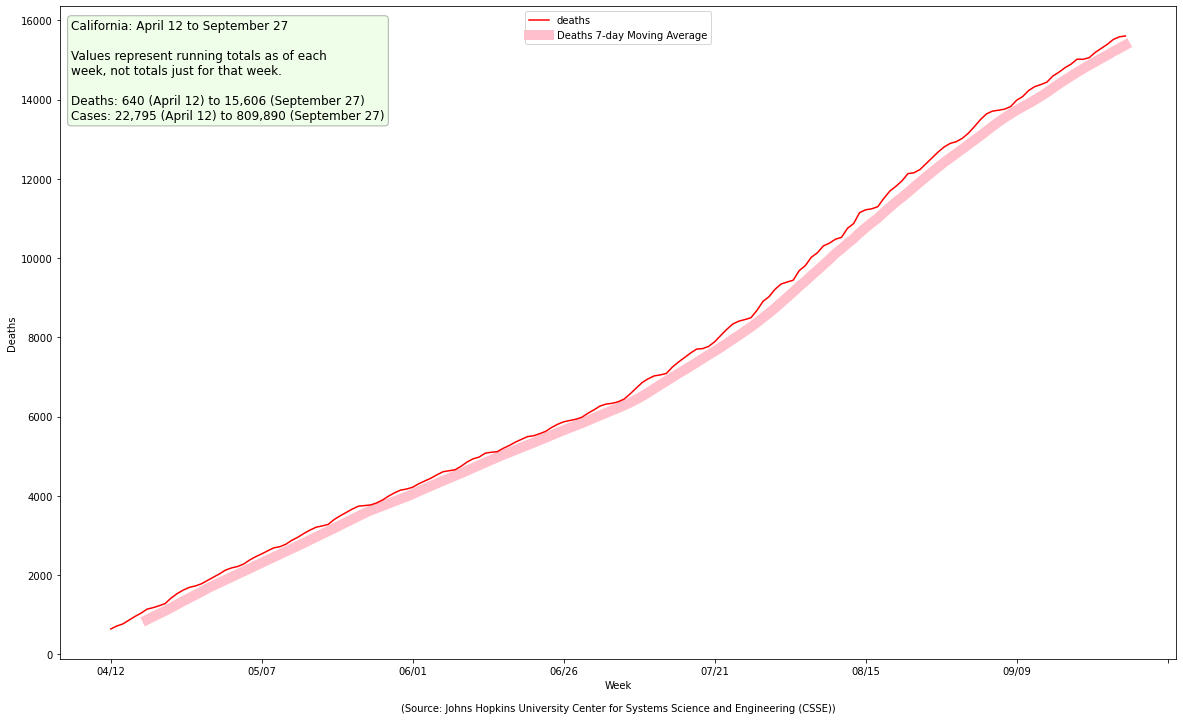

In [35]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc40a7c0>)

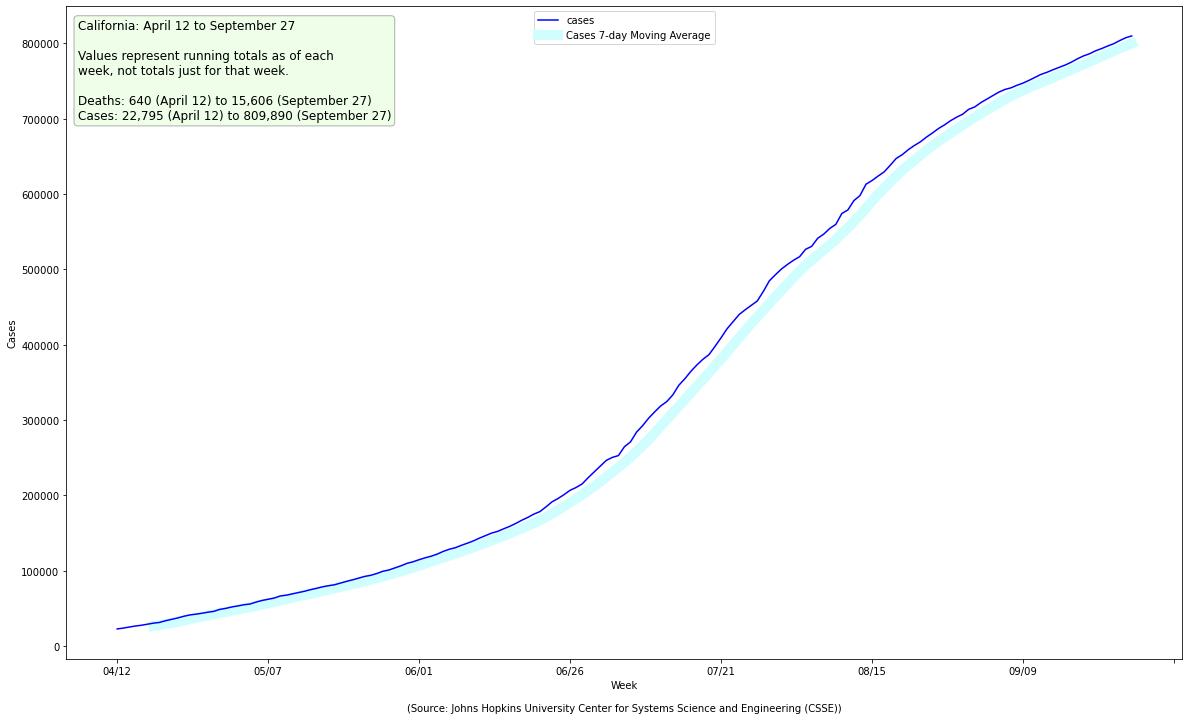

In [36]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46ba7804f0>)

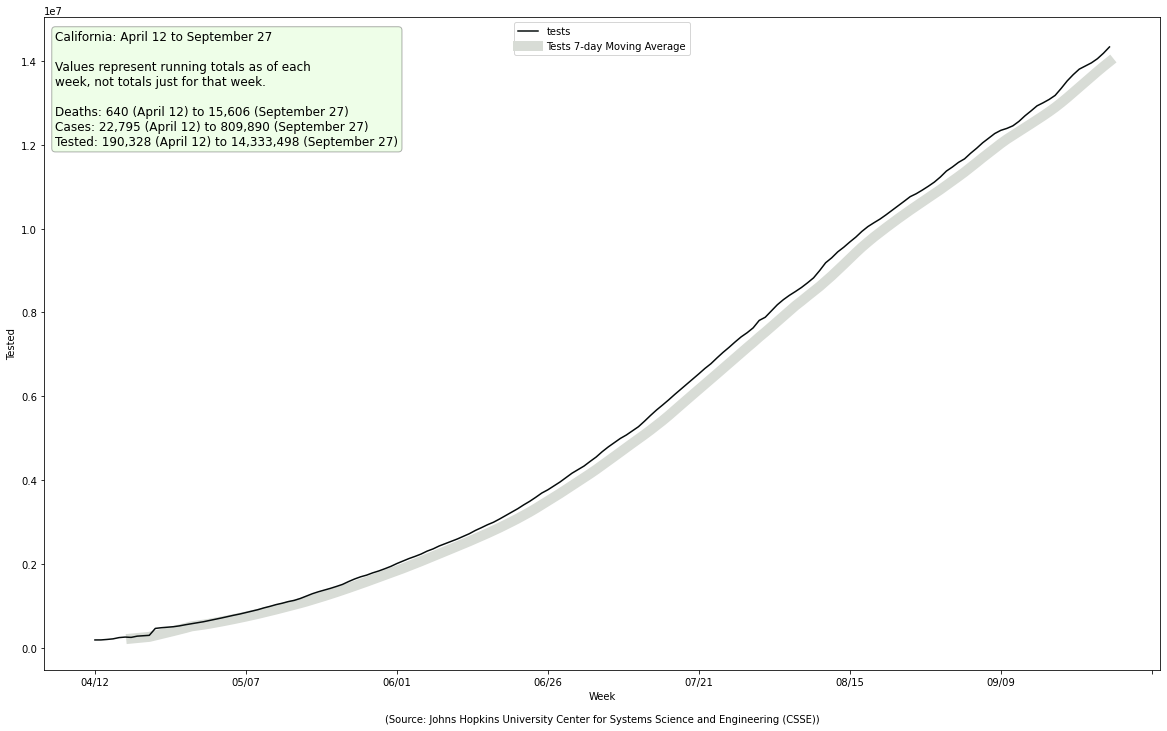

In [37]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-tests.png', 
           metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bdf2b760>)

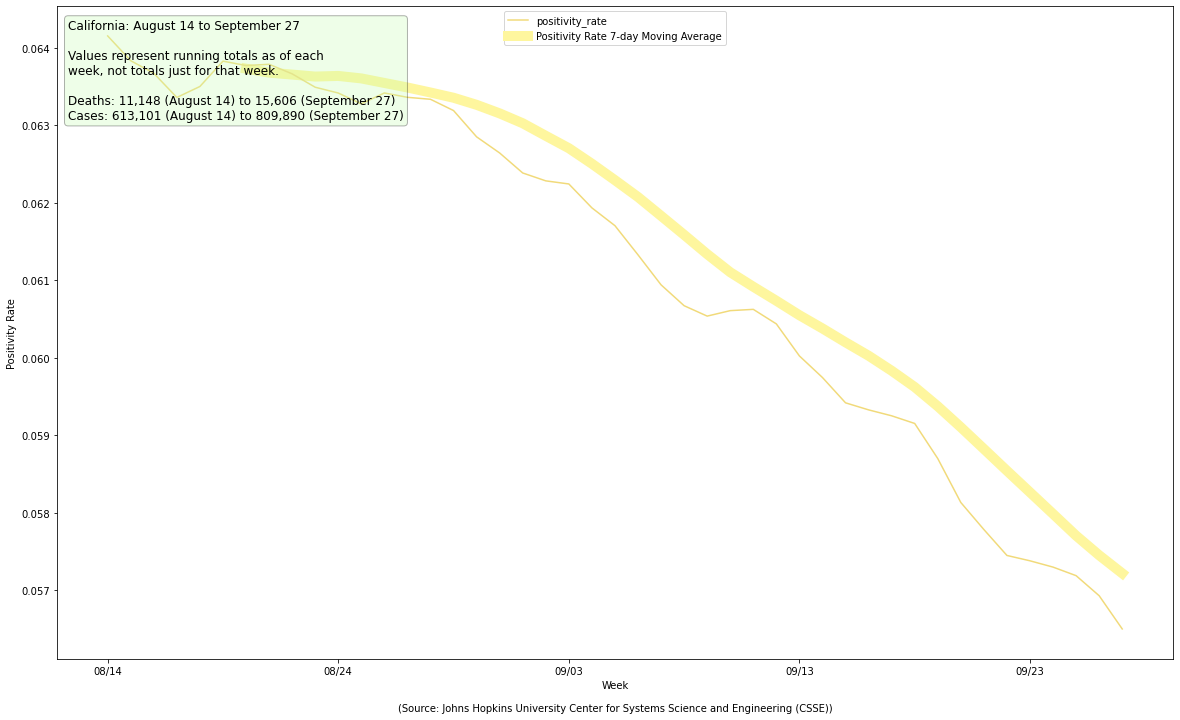

In [38]:
plot_state(df_positivity_dates, SOURCE, 'California', image_file='jhu-ca-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Washington

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bdf244f0>)

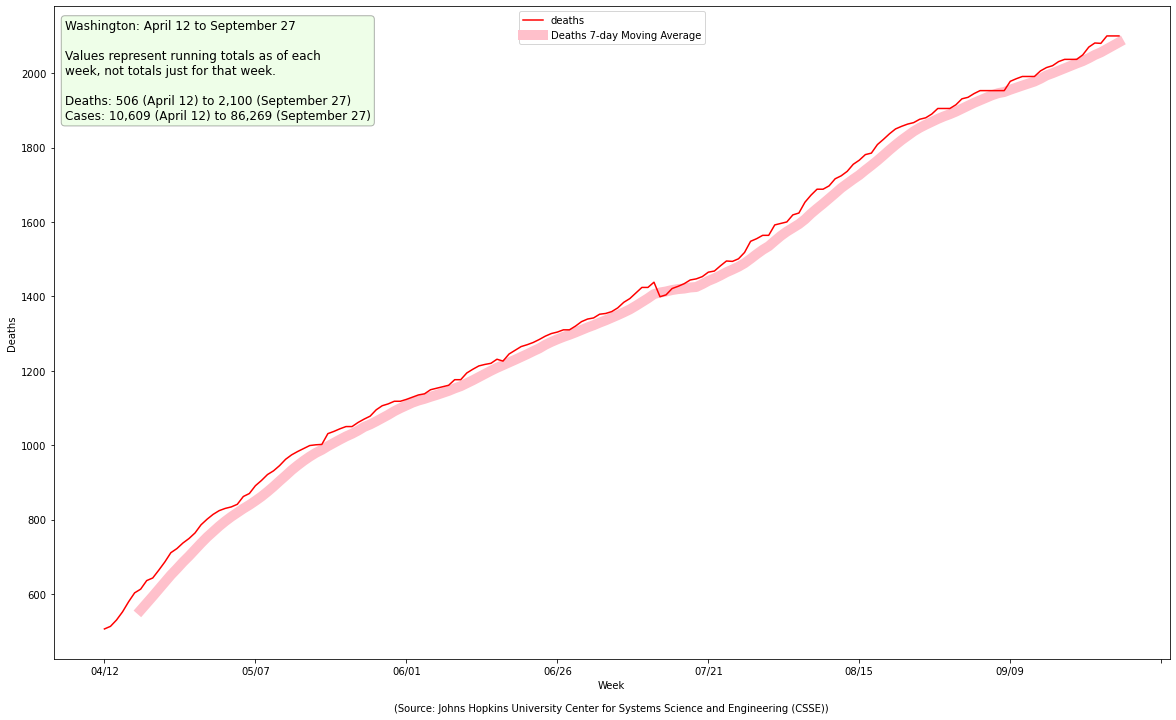

In [39]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46badd42b0>)

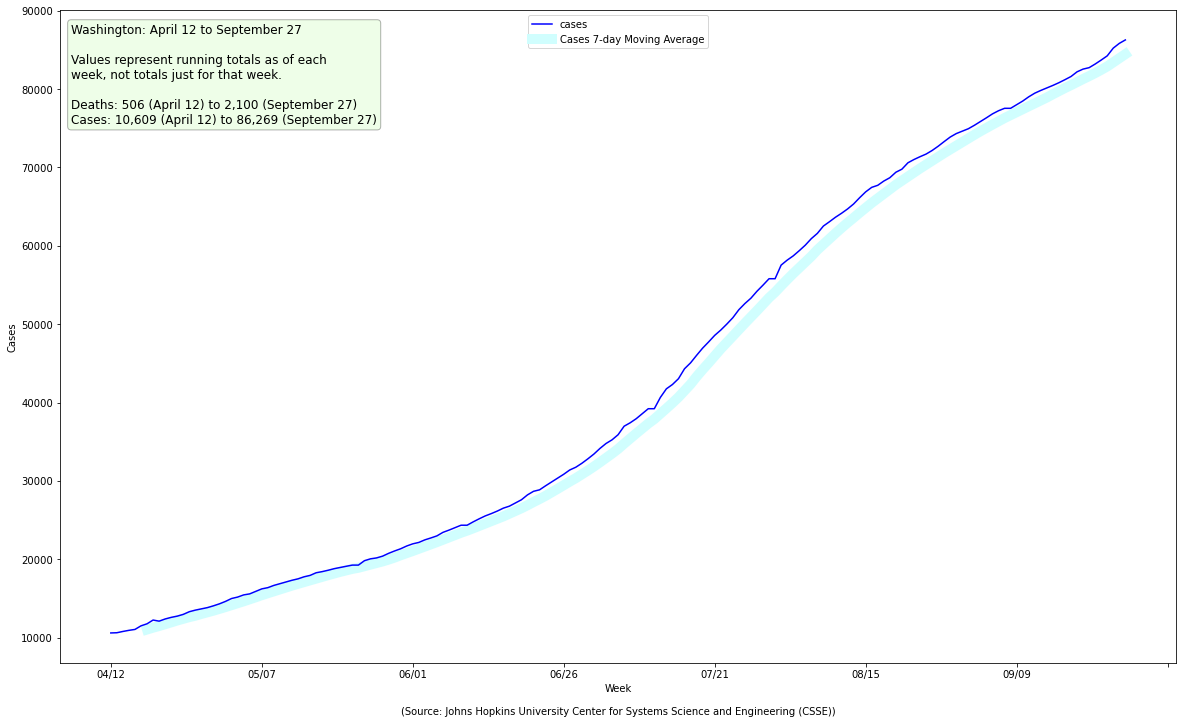

In [40]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46ba22c970>)

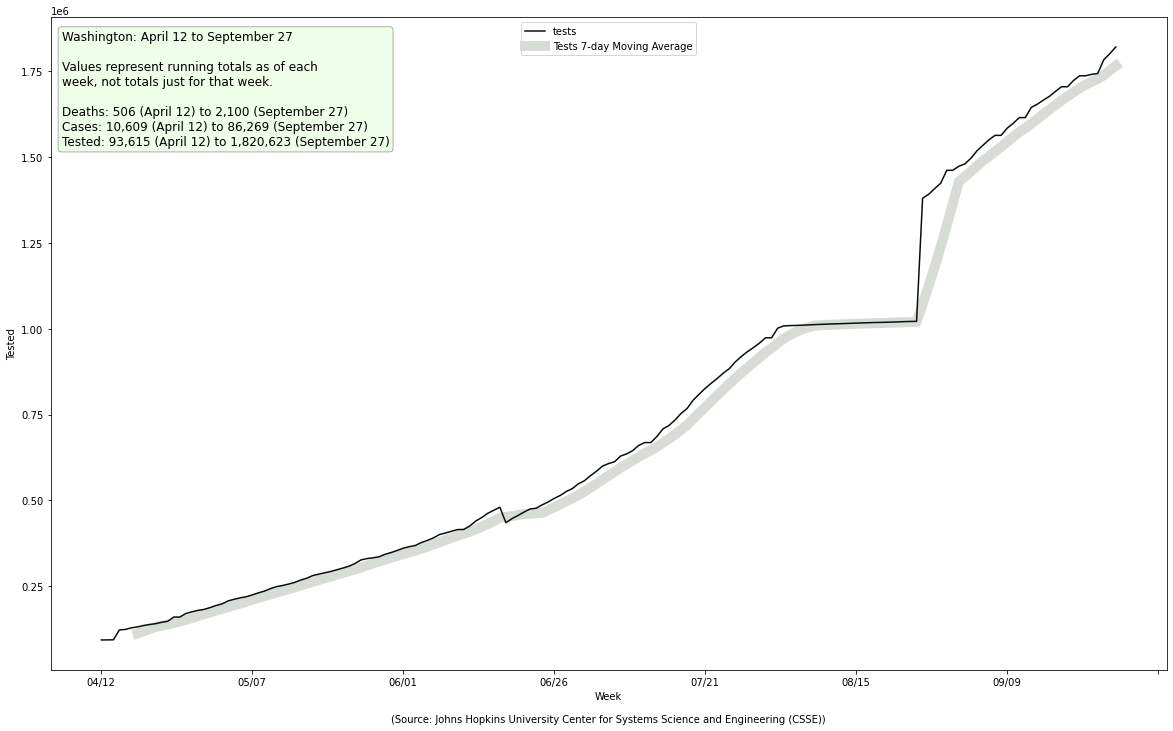

In [41]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc179580>)

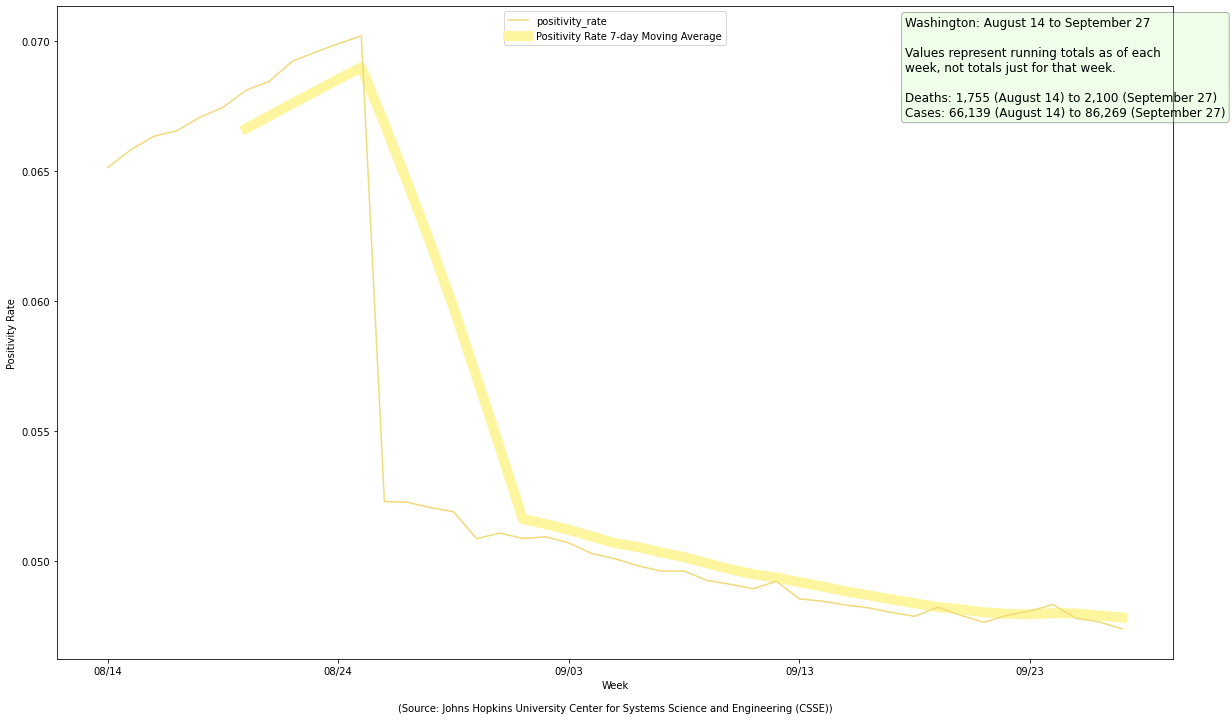

In [42]:
plot_state(df_positivity_dates, SOURCE, 'Washington', image_file='jhu-wa-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True, textbox_loc=(0.76, 0.985))

#### Delaware

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bdf57d90>)

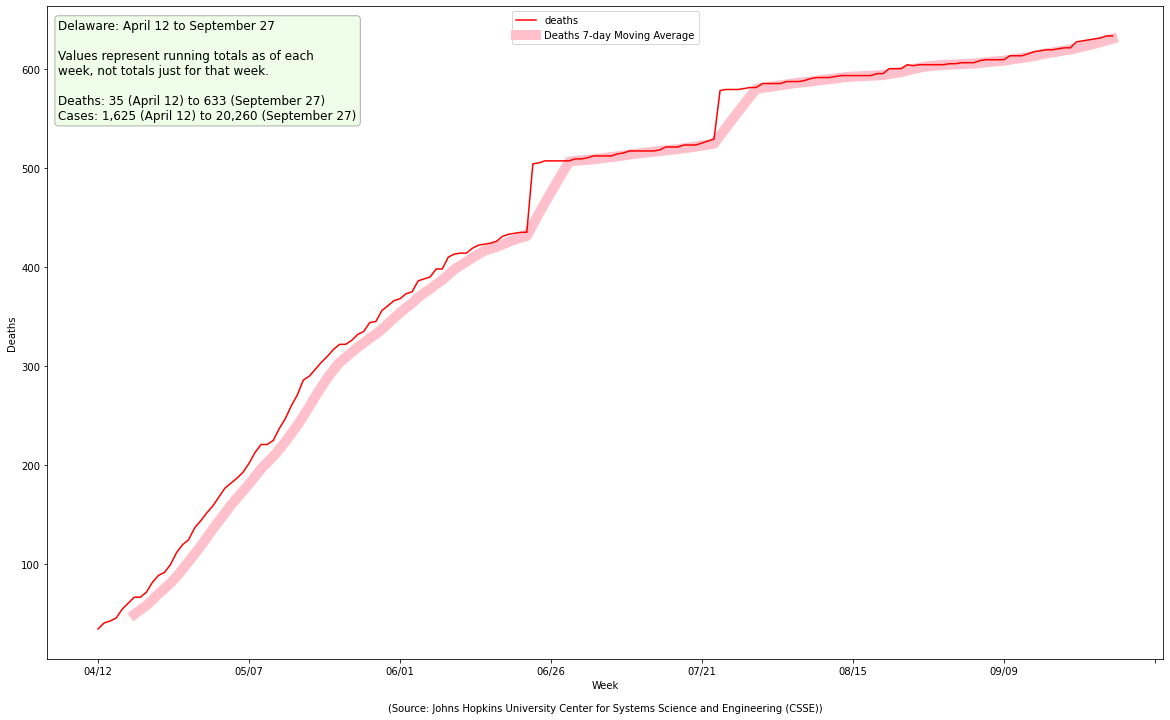

In [43]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bca32c70>)

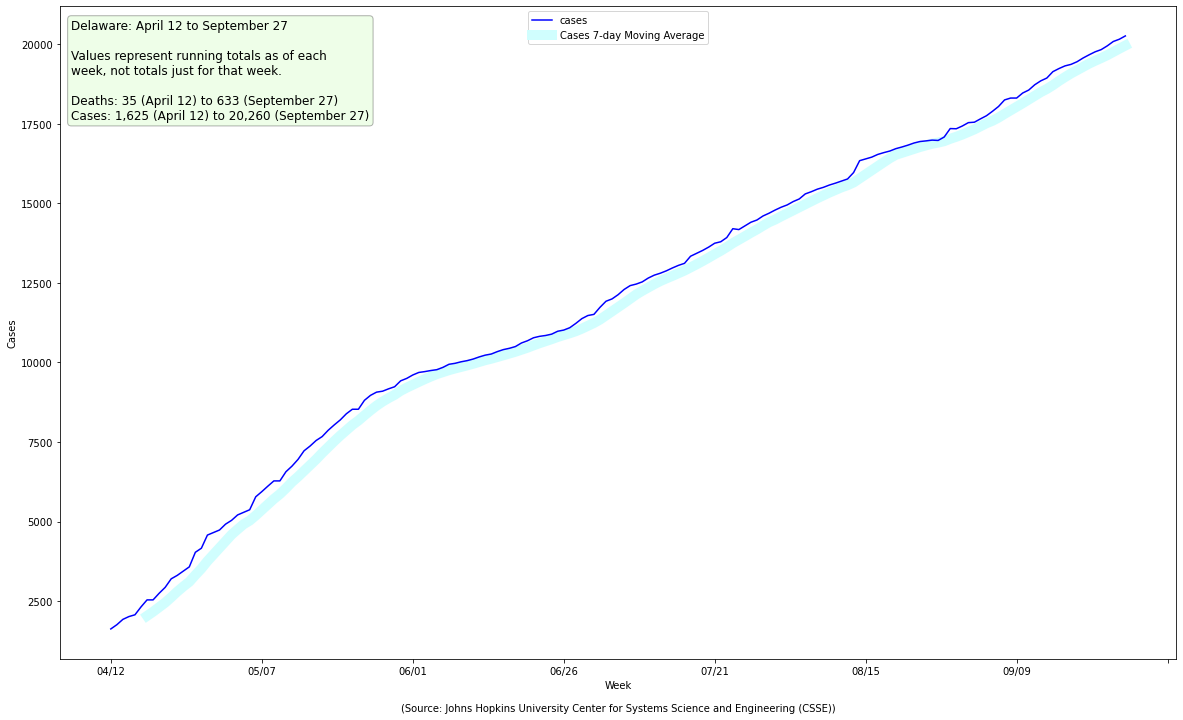

In [44]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-cases.png', metrics={MetricType.CASES}, moving_average=True)

#### Texas

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46d127f3a0>)

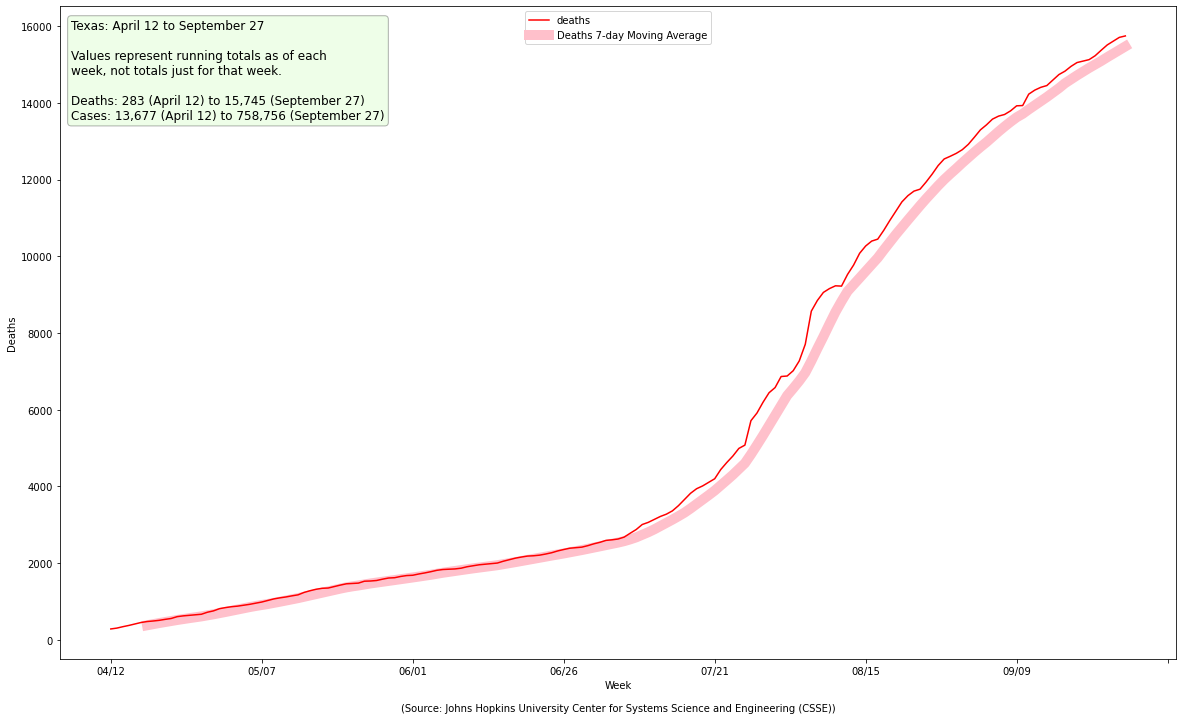

In [45]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46d1443e50>)

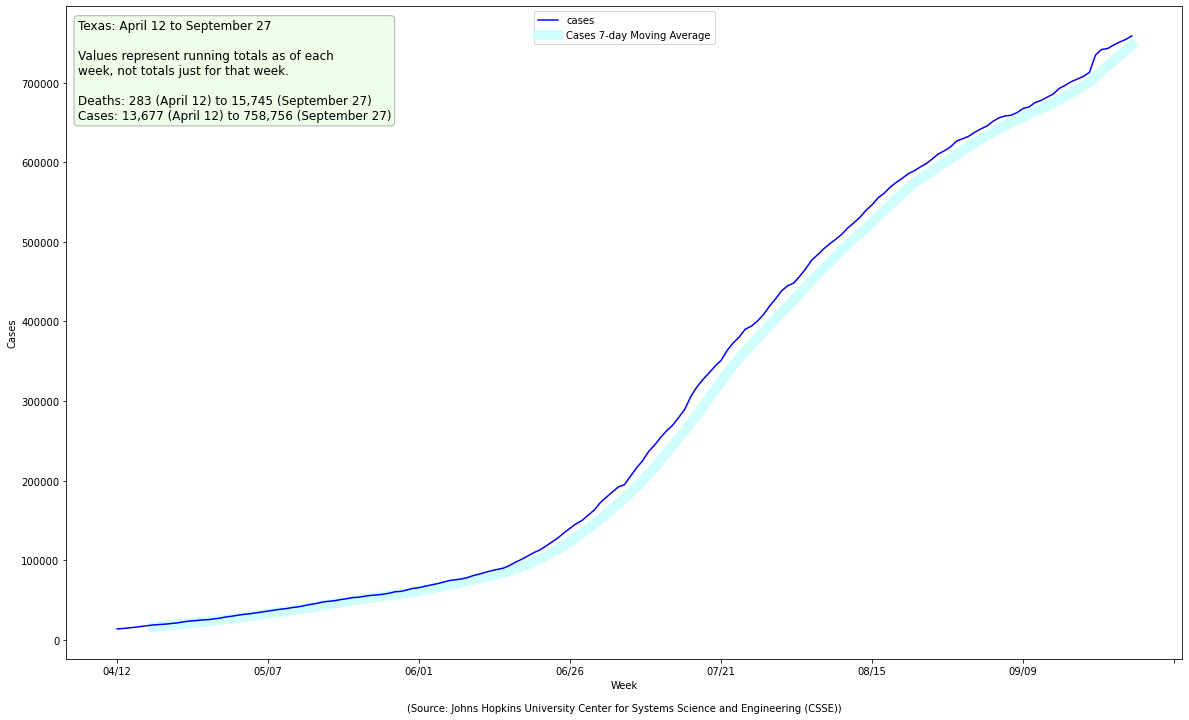

In [46]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc07cac0>)

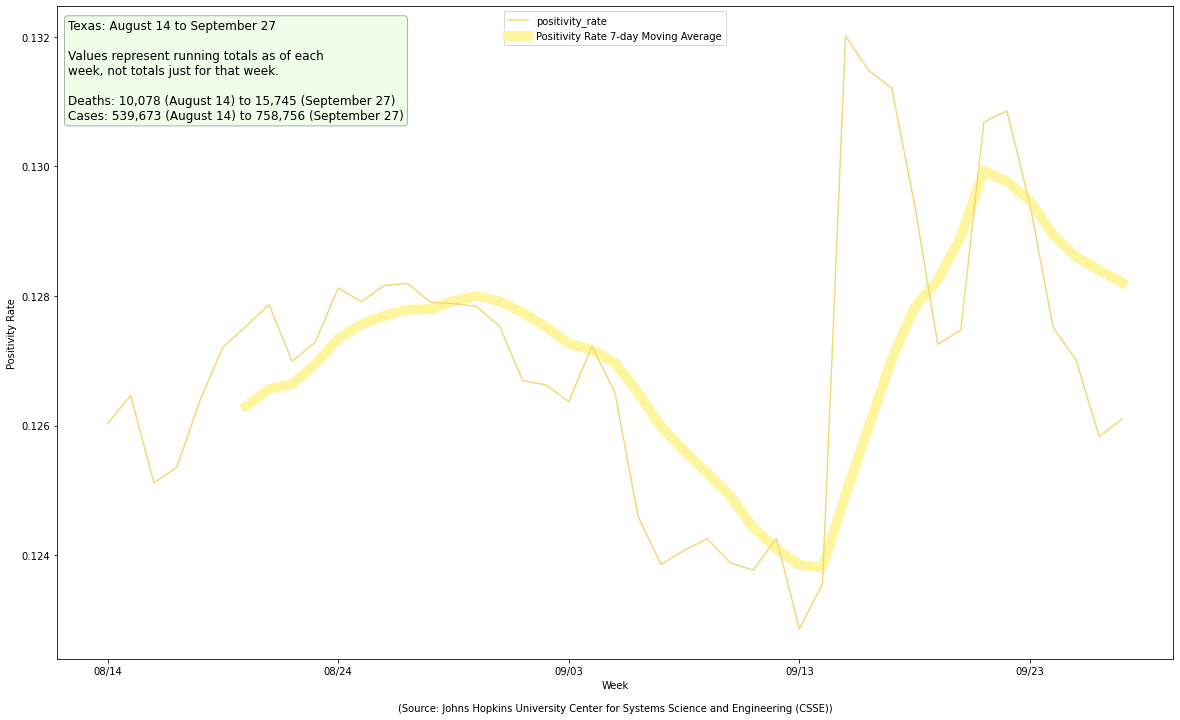

In [47]:
plot_state(df_positivity_dates, SOURCE, 'Texas', image_file='jhu-tx-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

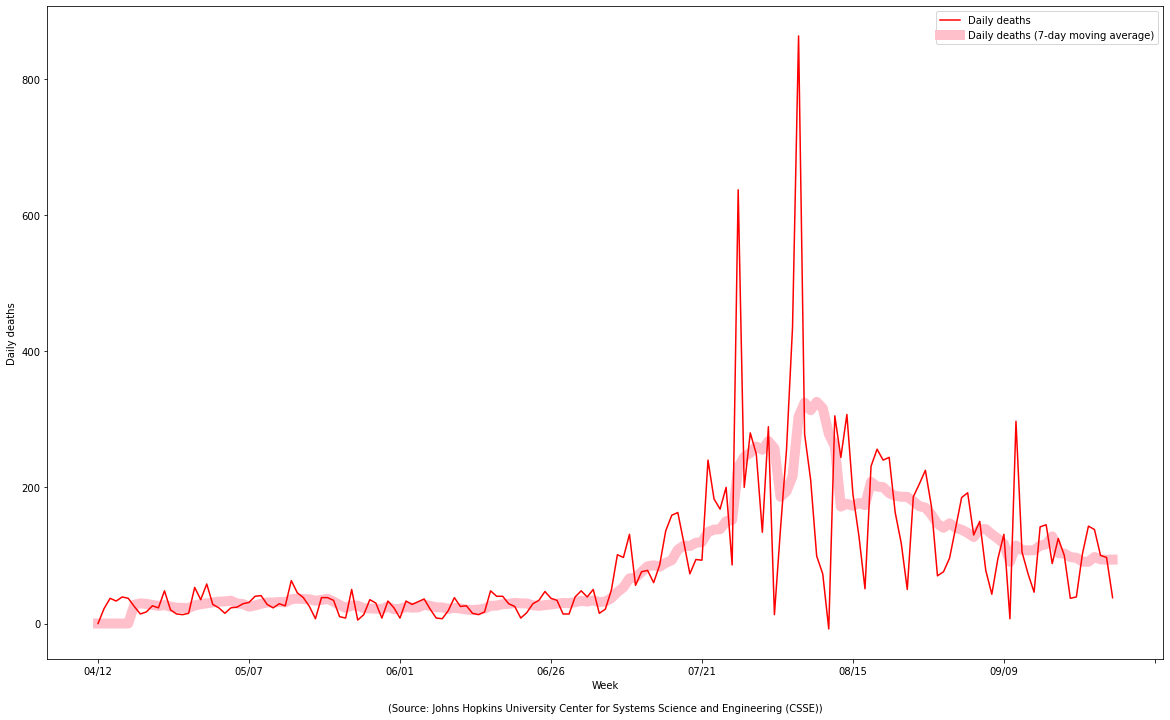

In [48]:
plot_daily_stats(df, SOURCE, region='Texas', metric=MetricType.DEATHS, moving_average=True, image_file="jhu-tx-daily-deaths.png");

#### Georgia

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc1c36d0>)

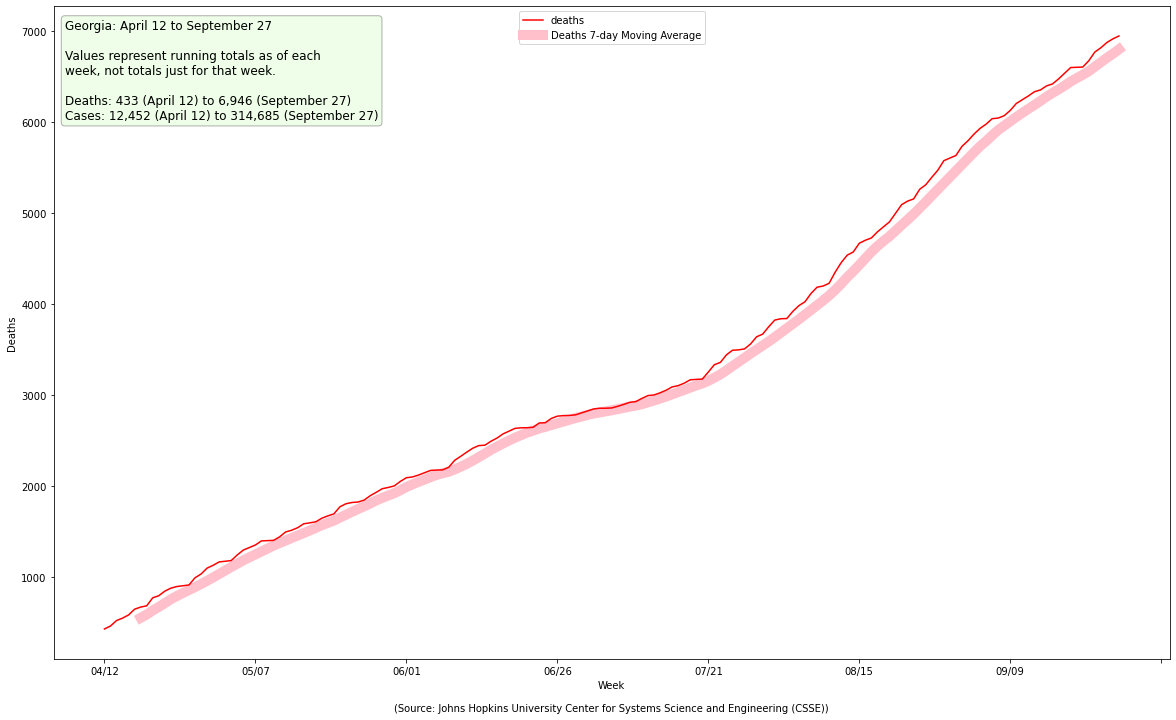

In [49]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46b9ff6760>)

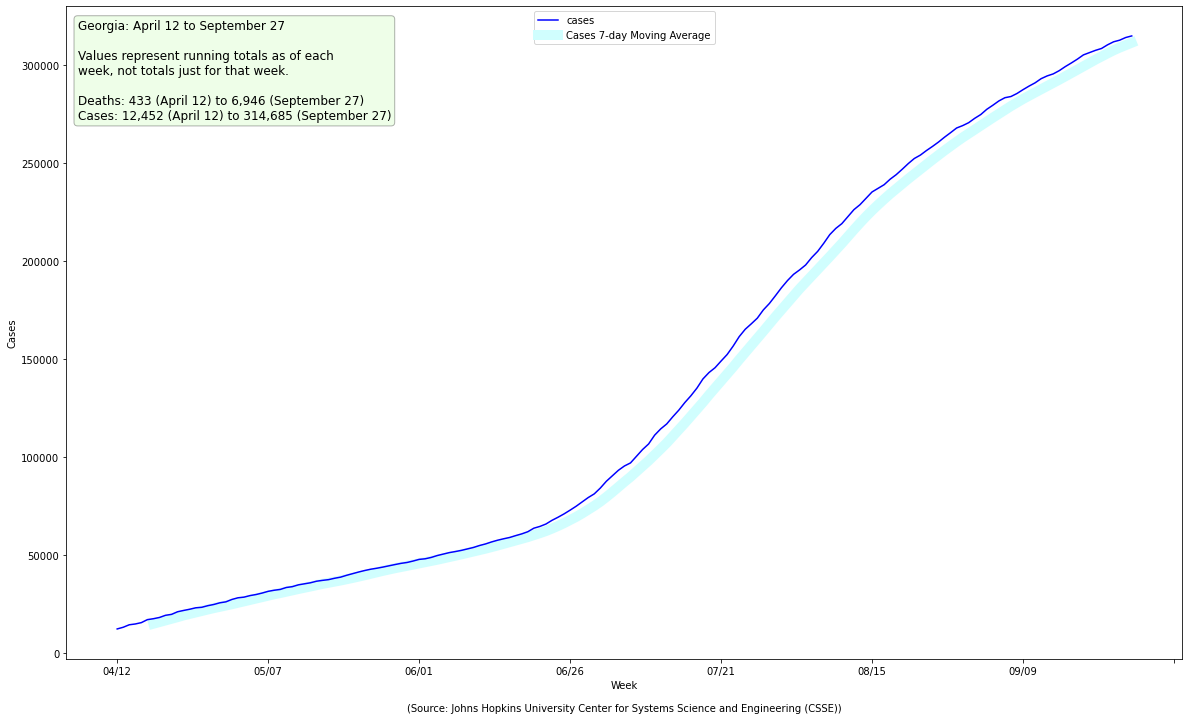

In [50]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46ba9ea610>)

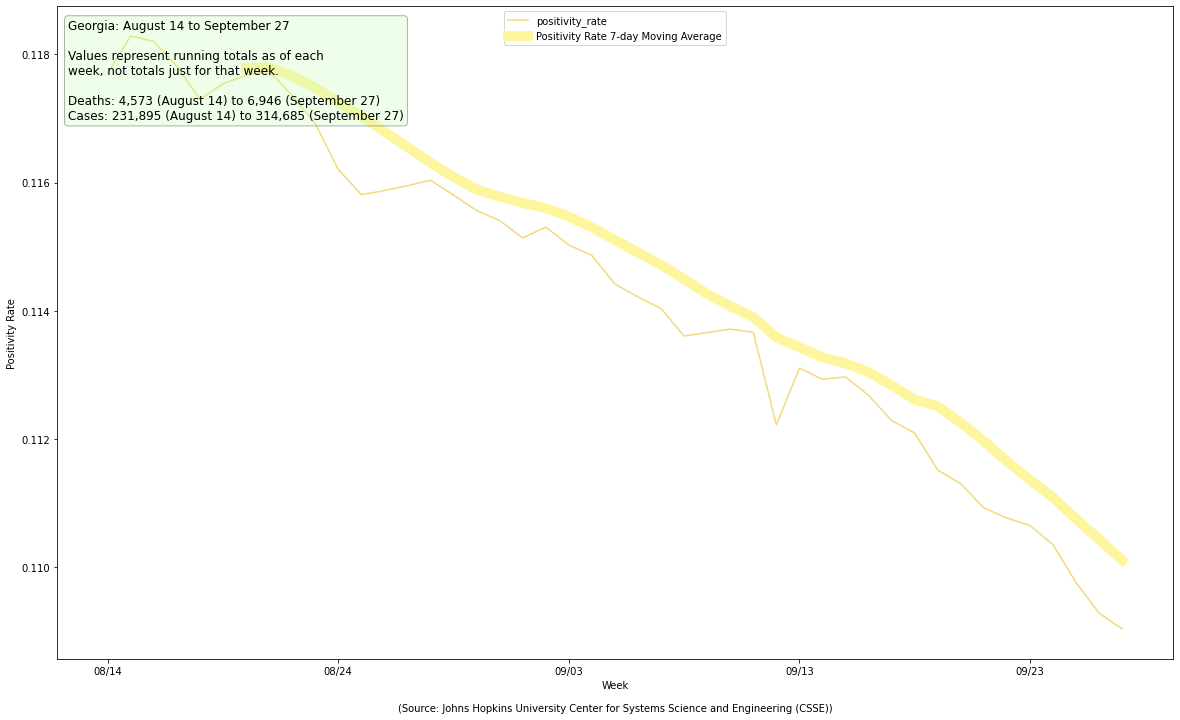

In [51]:
plot_state(df_positivity_dates, SOURCE, 'Georgia', image_file='jhu-ga-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

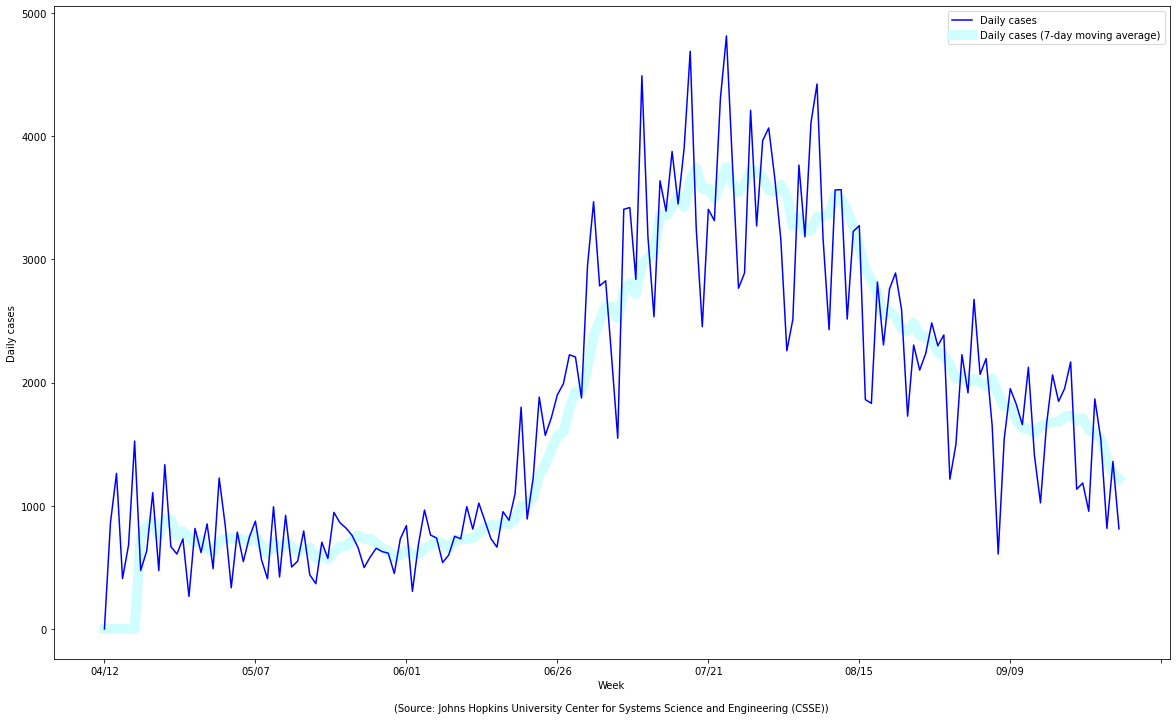

In [52]:
plot_daily_stats(df, SOURCE, region='Georgia', metric=MetricType.CASES, moving_average=True, image_file="jhu-ga-daily-cases.png");

#### Mississippi

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc8c0070>)

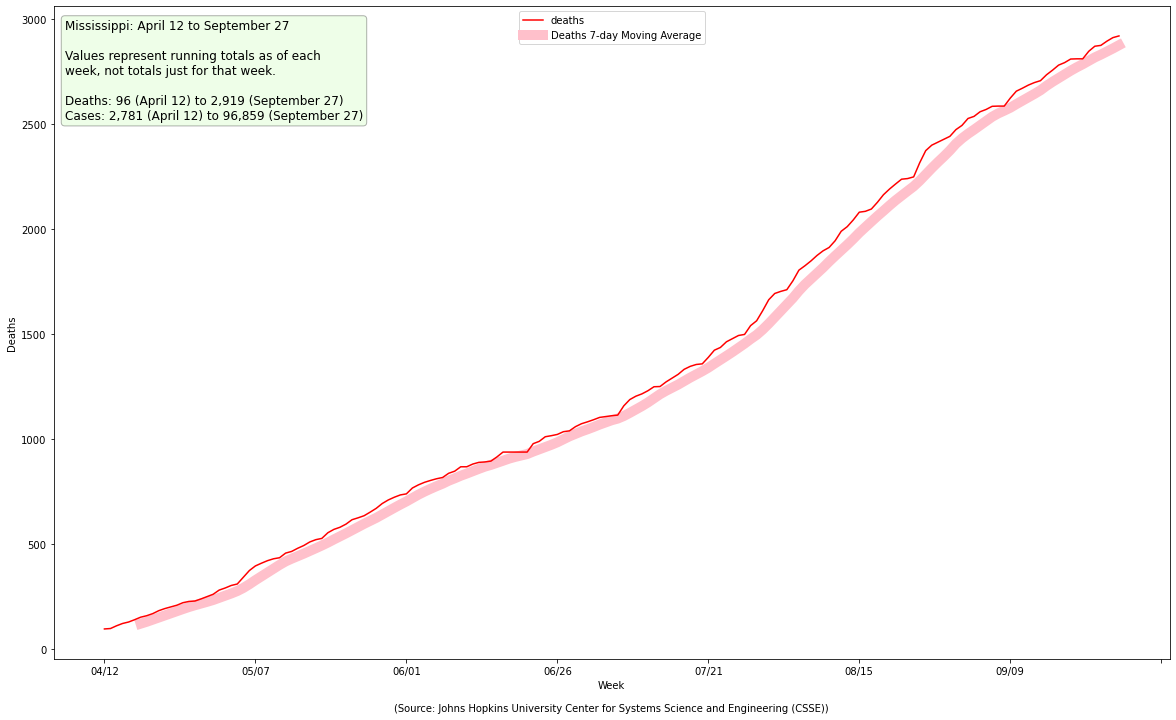

In [53]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46b9630250>)

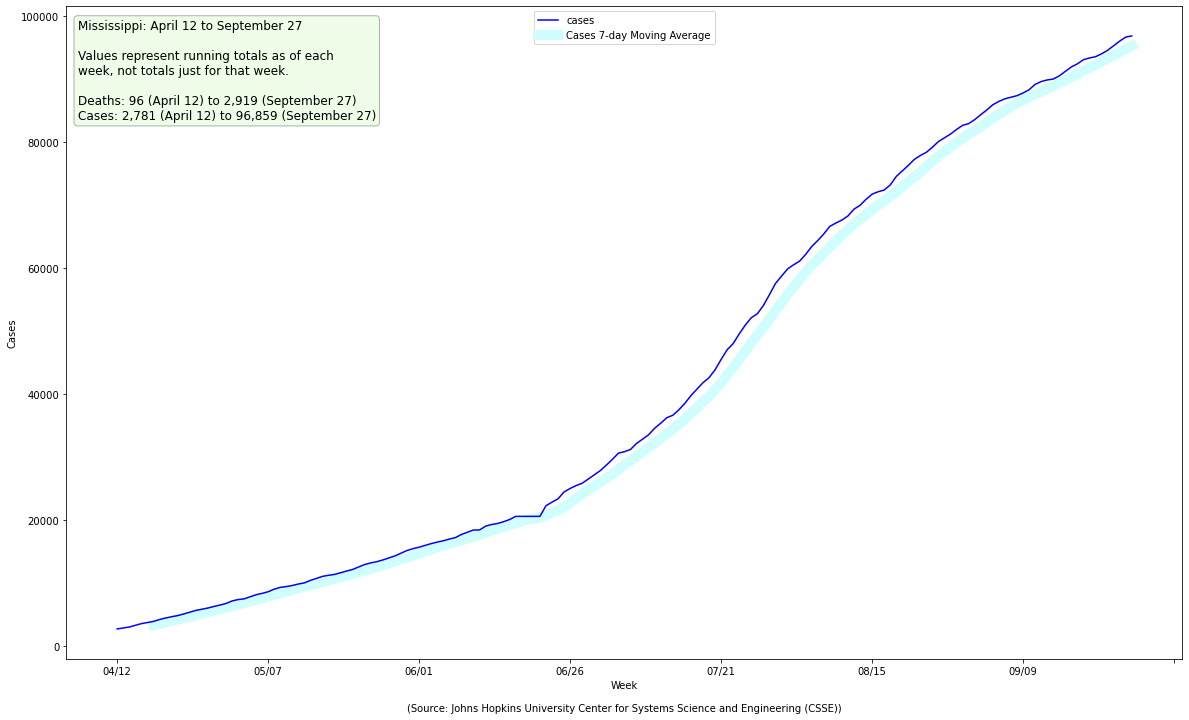

In [54]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bbd594c0>)

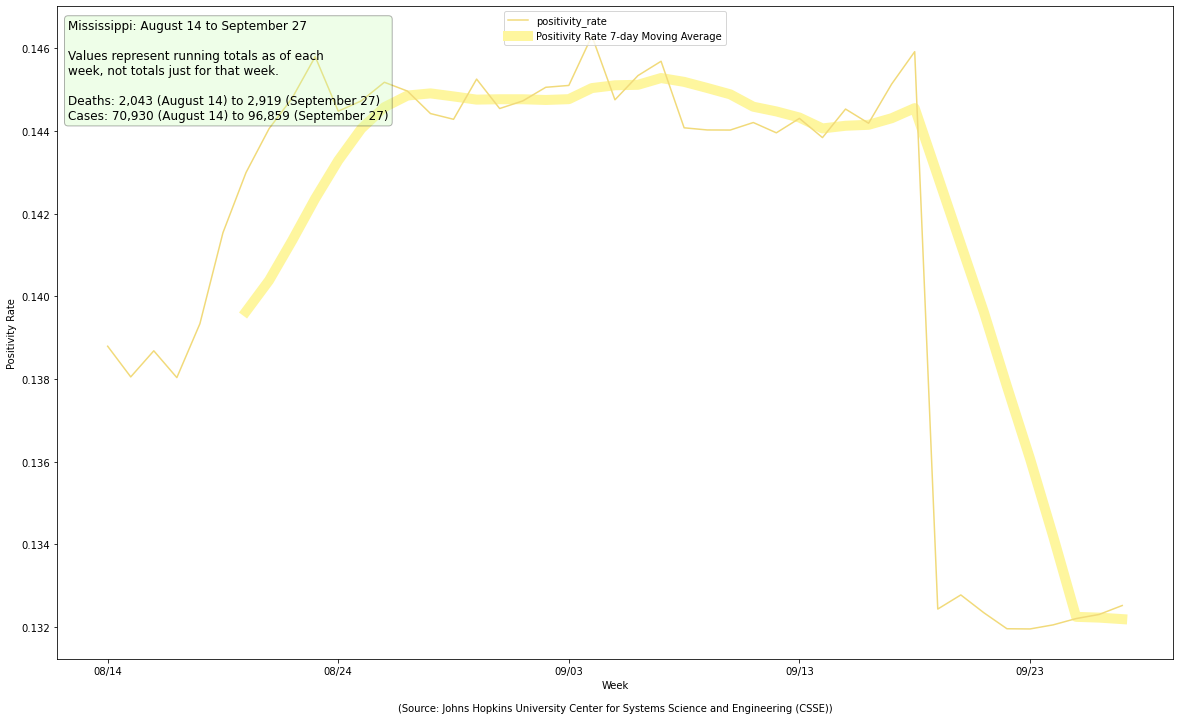

In [55]:
plot_state(df_positivity_dates, SOURCE, 'Mississippi', image_file='jhu-ms-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

#### Arizona

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bcd04a30>)

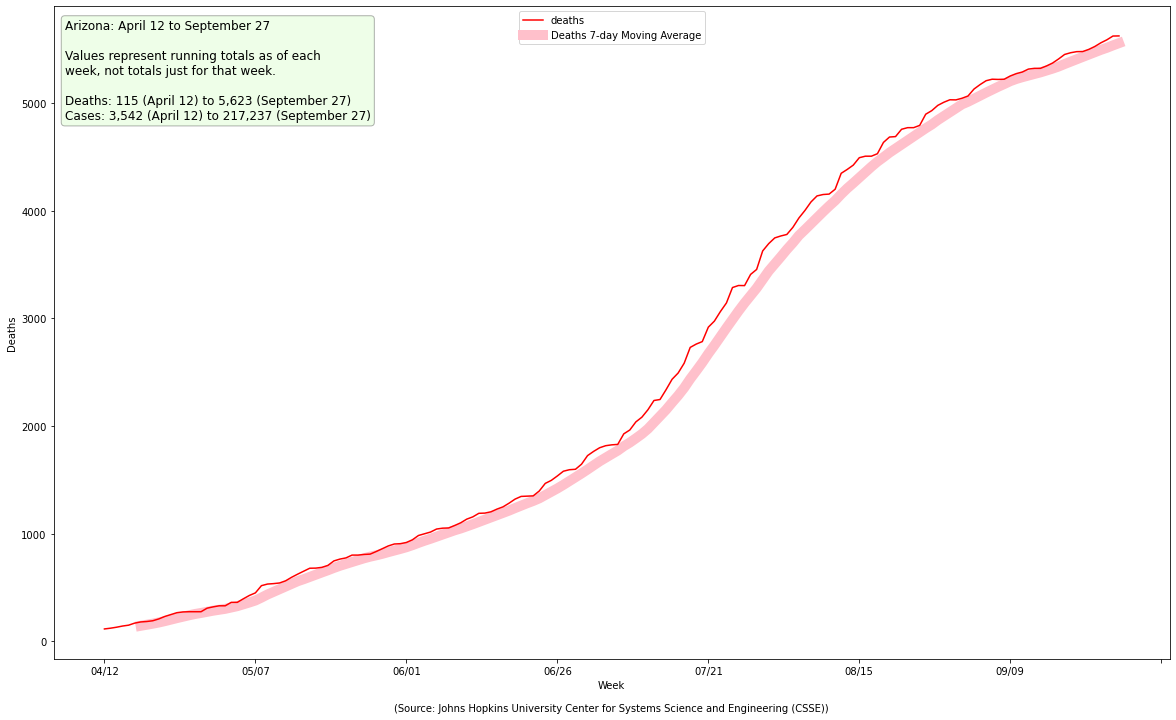

In [56]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bd0298b0>)

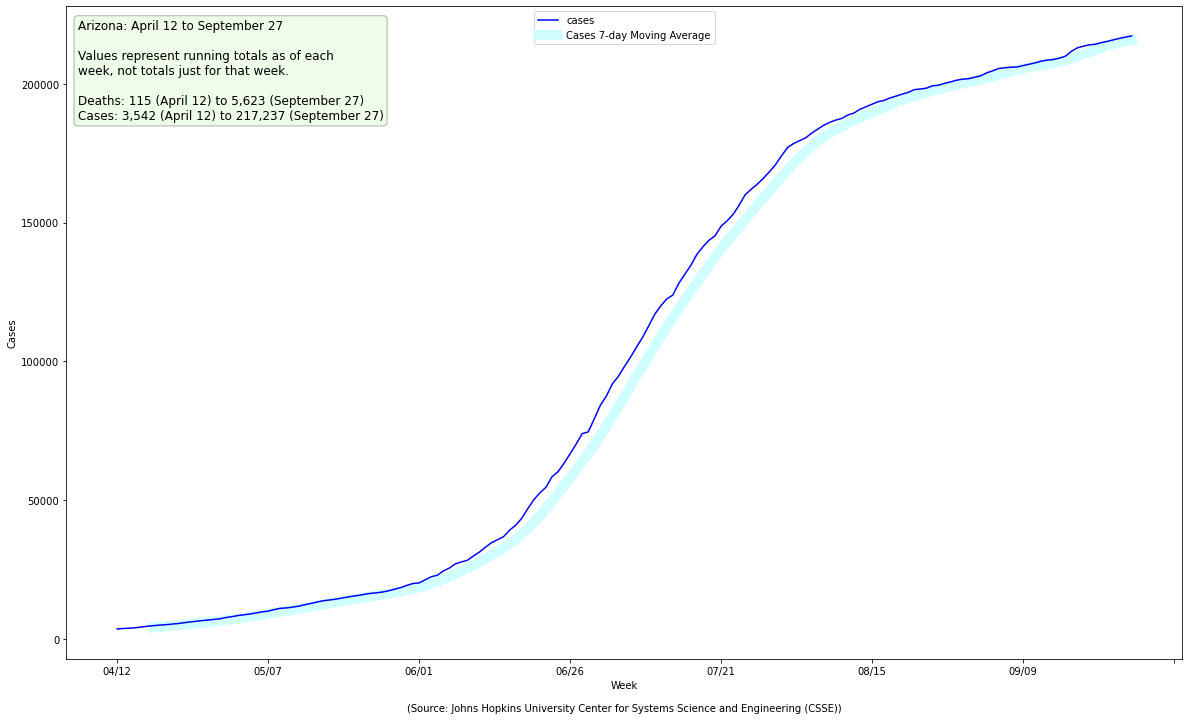

In [57]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46d10fb640>)

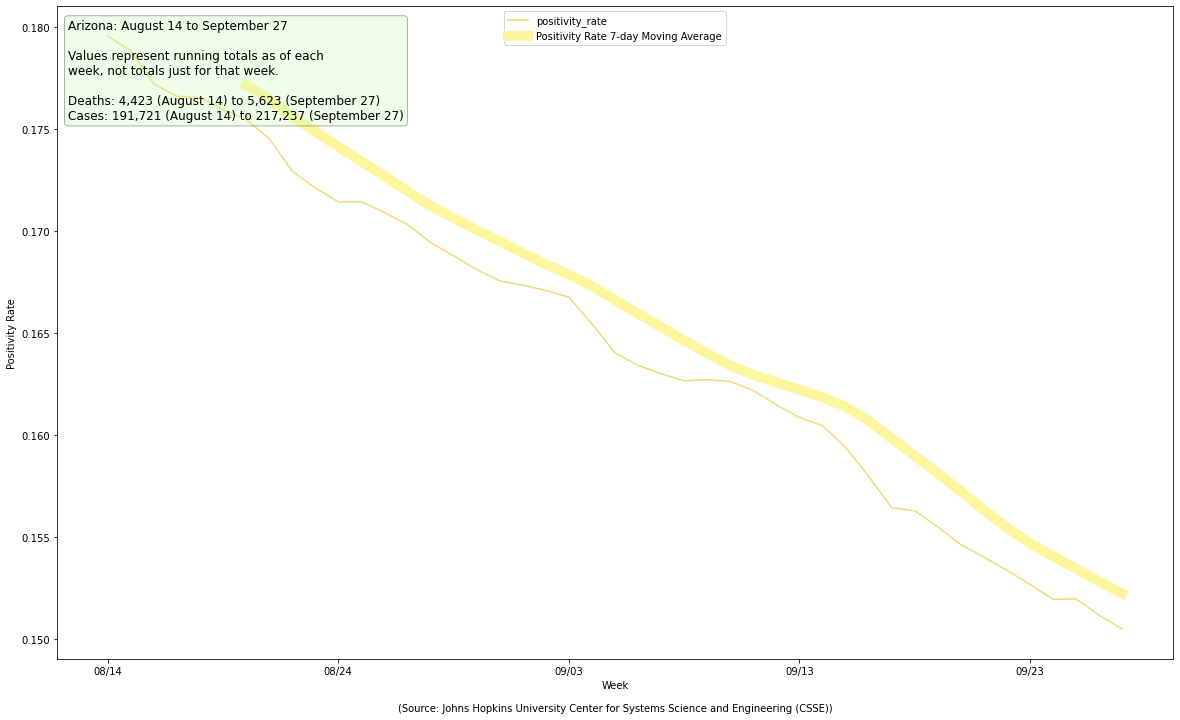

In [58]:
plot_state(df_positivity_dates, SOURCE, 'Arizona', image_file='jhu-az-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Florida

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bdc00af0>)

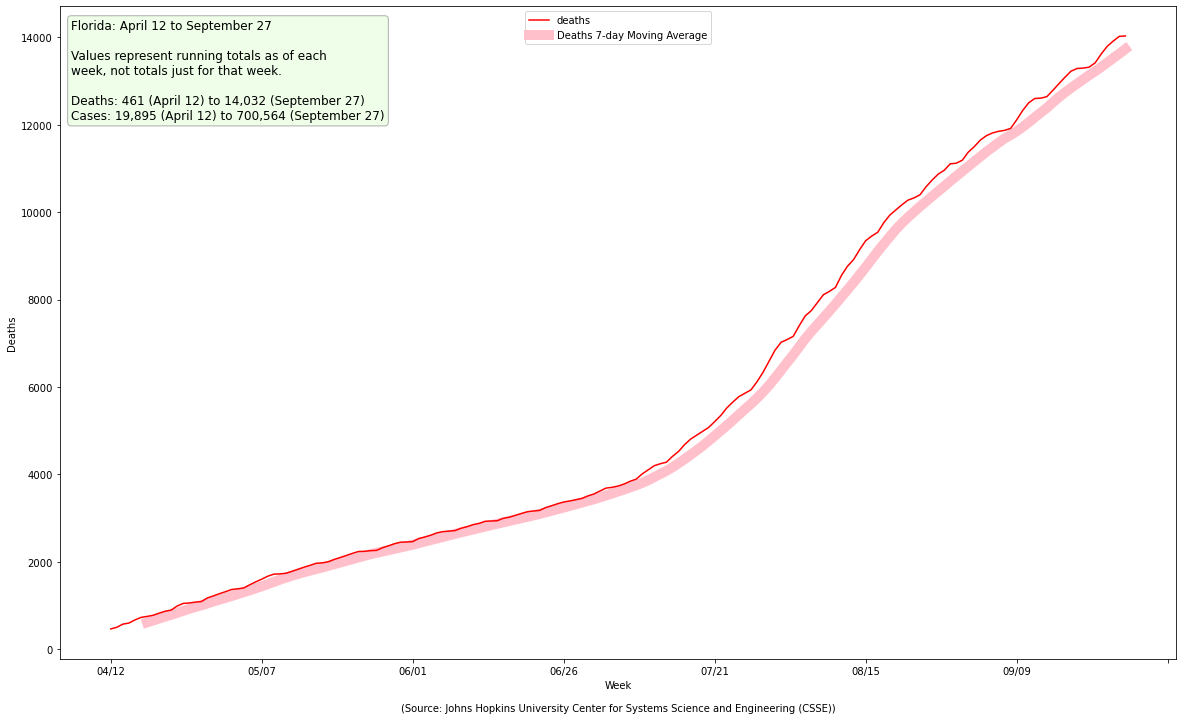

In [59]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc4f7e50>)

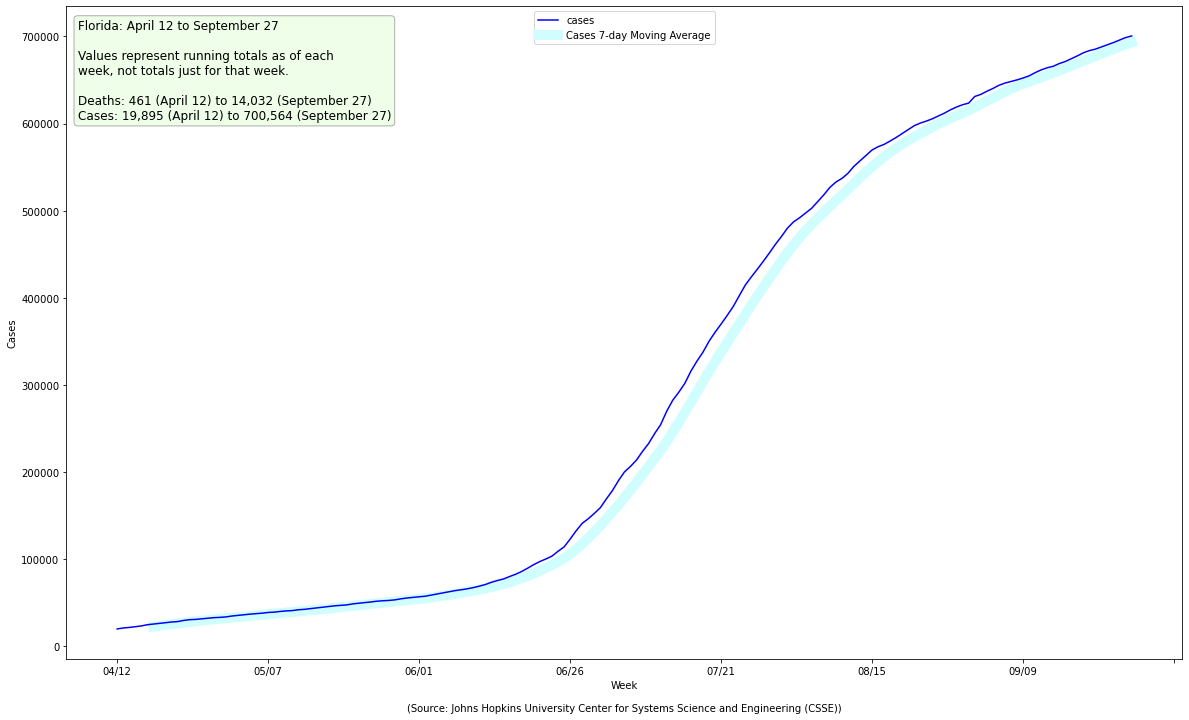

In [60]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46ba830580>)

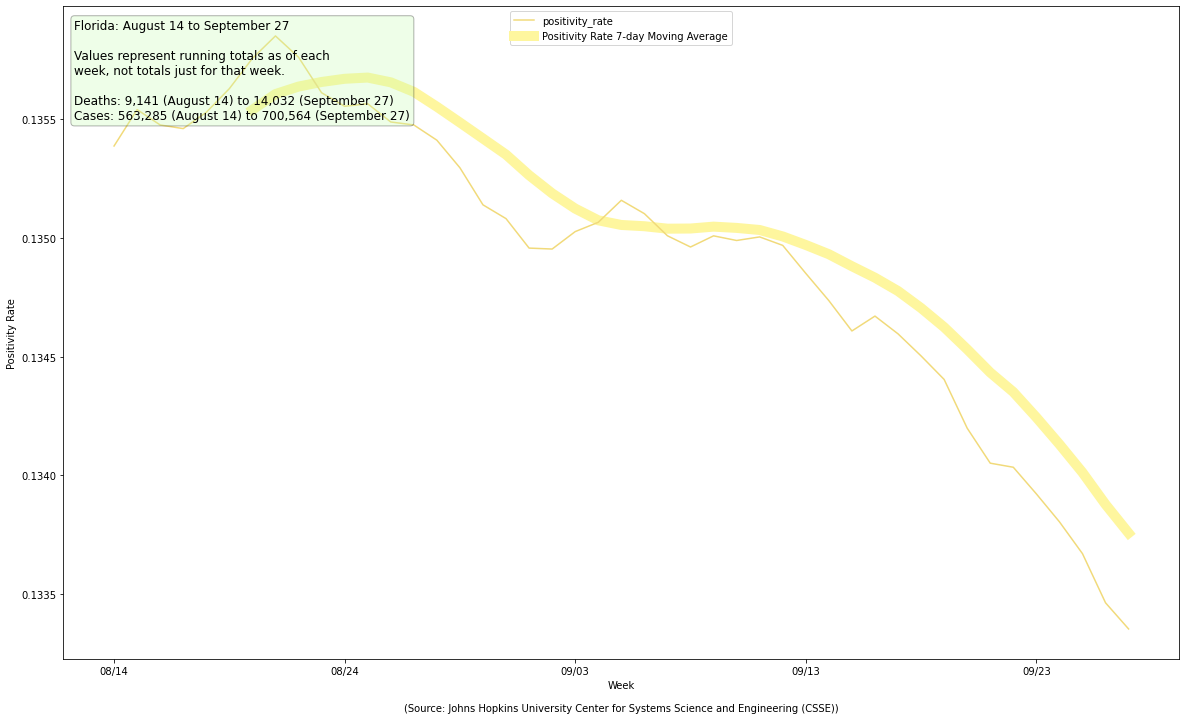

In [61]:
plot_state(df_positivity_dates, SOURCE, 'Florida', image_file='jhu-fl-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

### South Carolina

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bd108fd0>)

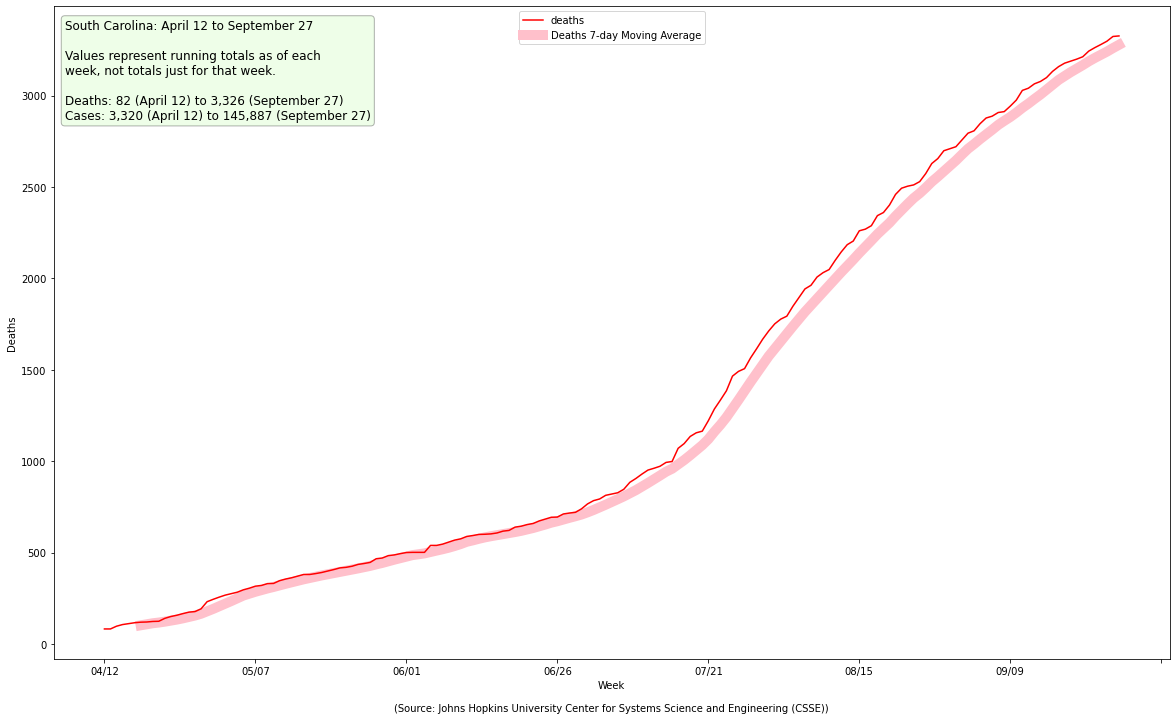

In [62]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46b9e8d7f0>)

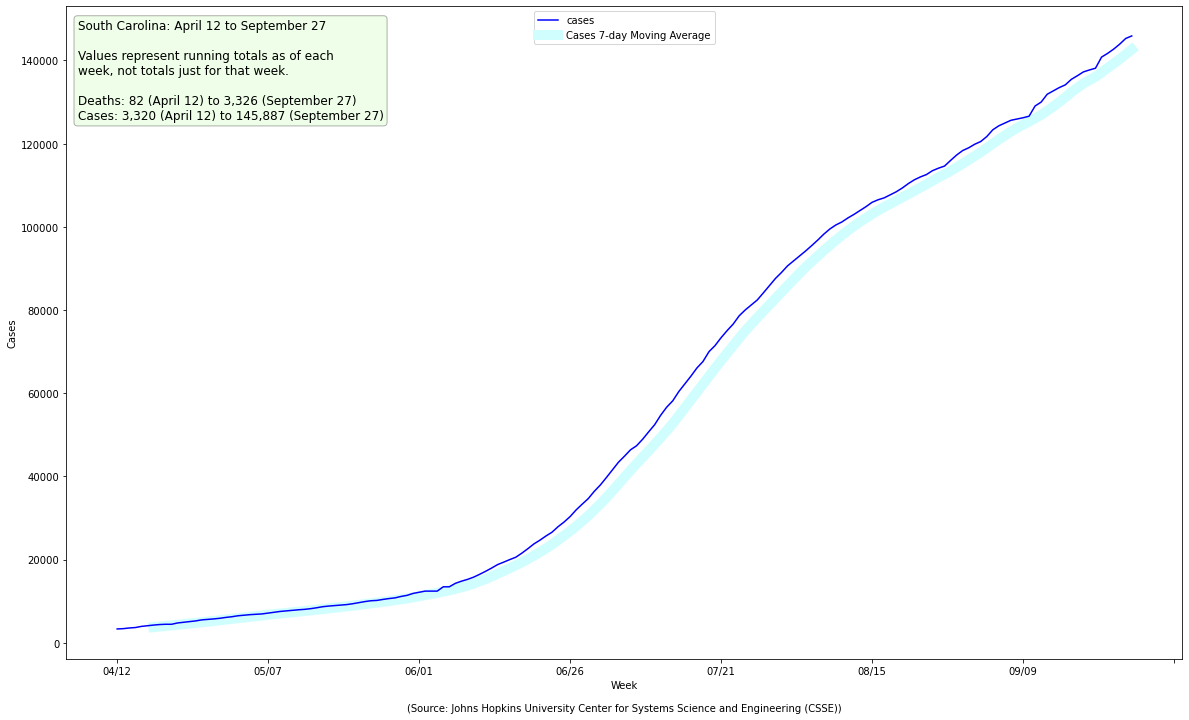

In [63]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bcfcce80>)

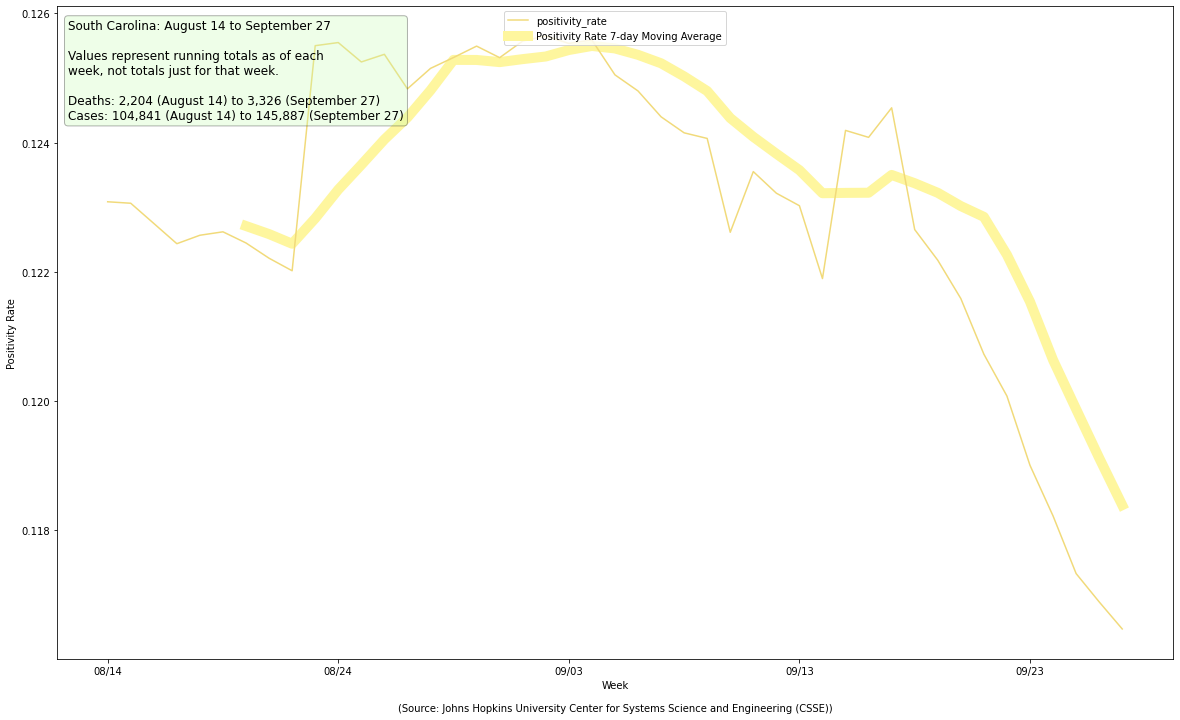

In [64]:
plot_state(df_positivity_dates, SOURCE, 'South Carolina', image_file='jhu-sc-pos.png',
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Oklahoma

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bda609d0>)

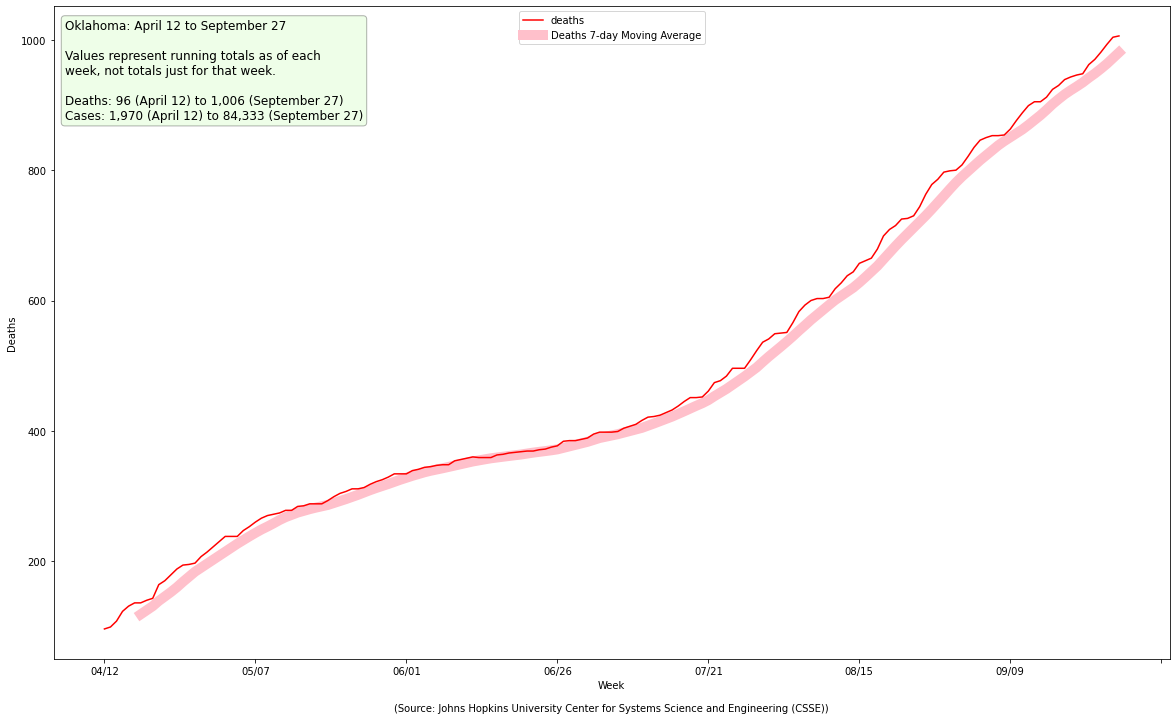

In [65]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bbdcbfa0>)

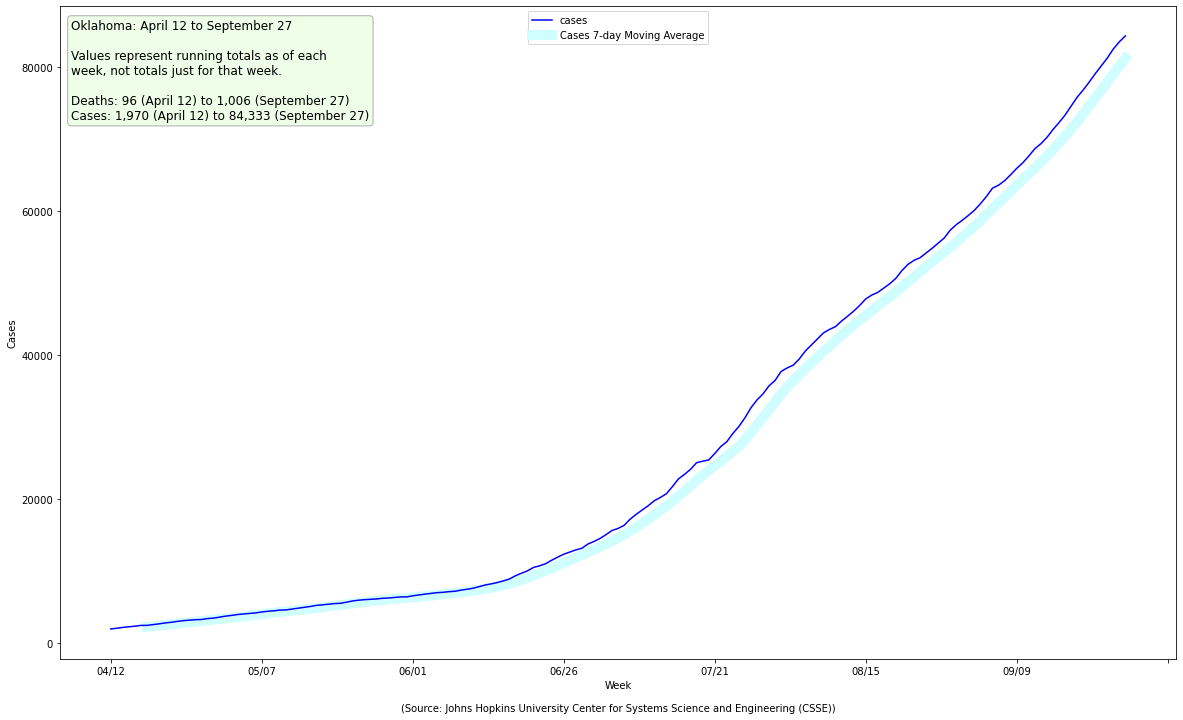

In [66]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bde9bf70>)

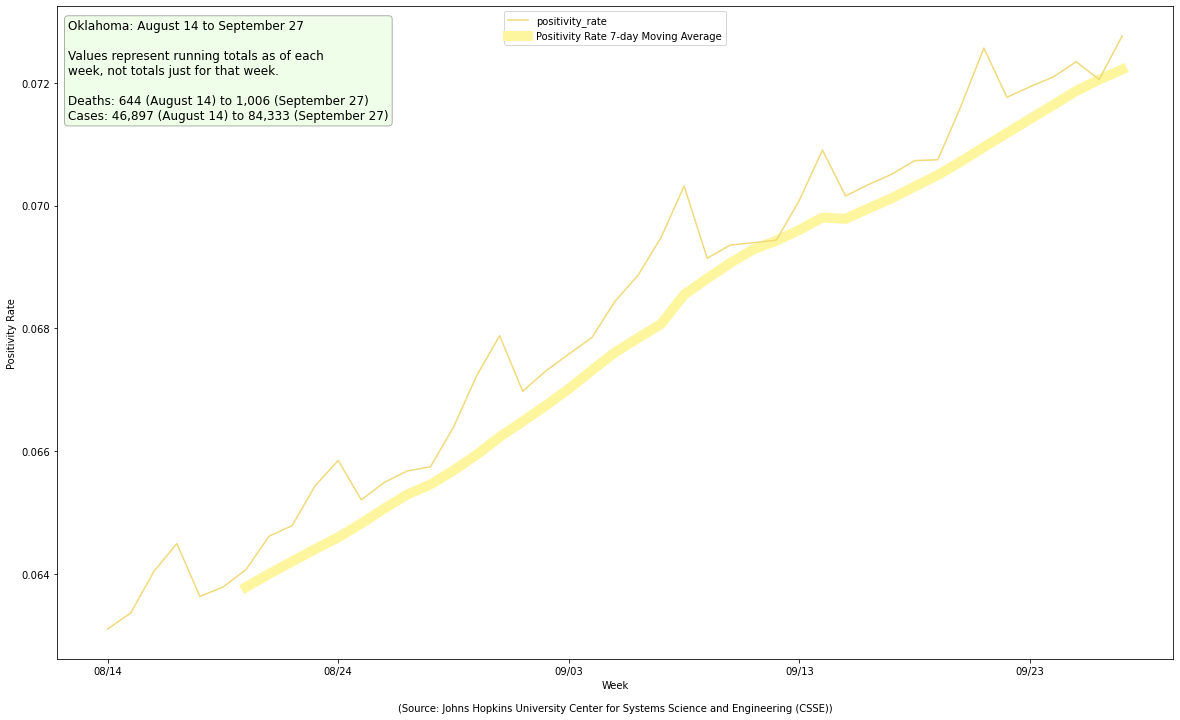

In [67]:
plot_state(df_positivity_dates, SOURCE, 'Oklahoma', image_file='jhu-ok-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

## Multistate

### Northeast states

Data from some of the states that were hardest hit early on.

In [68]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bda45520>)

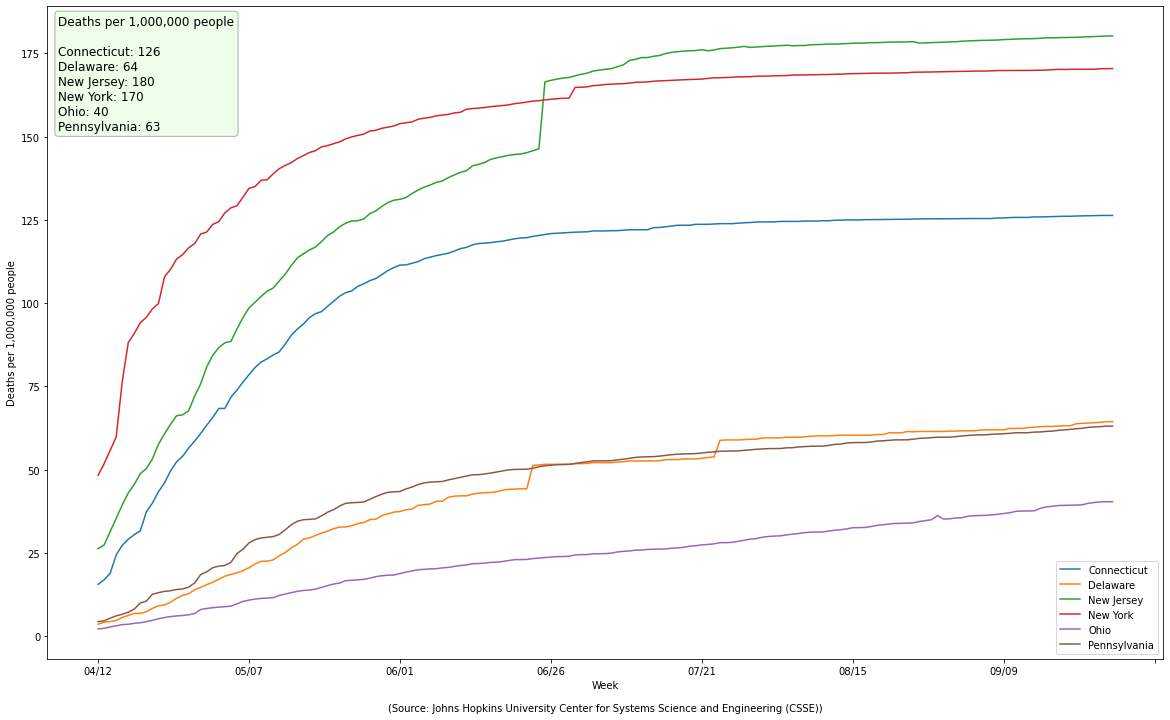

In [69]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            image_file='jhu-ne-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc72bee0>)

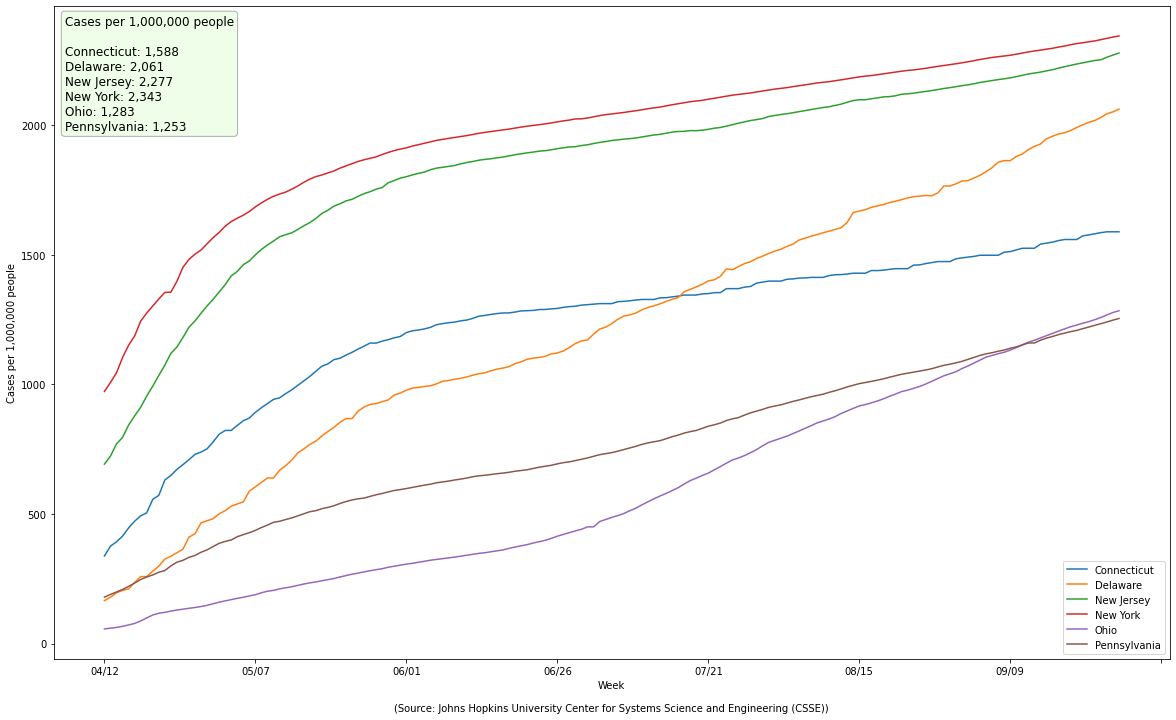

In [70]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            image_file='jhu-ne-states-cases-per-capita.png')

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [71]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bb7e63a0>)

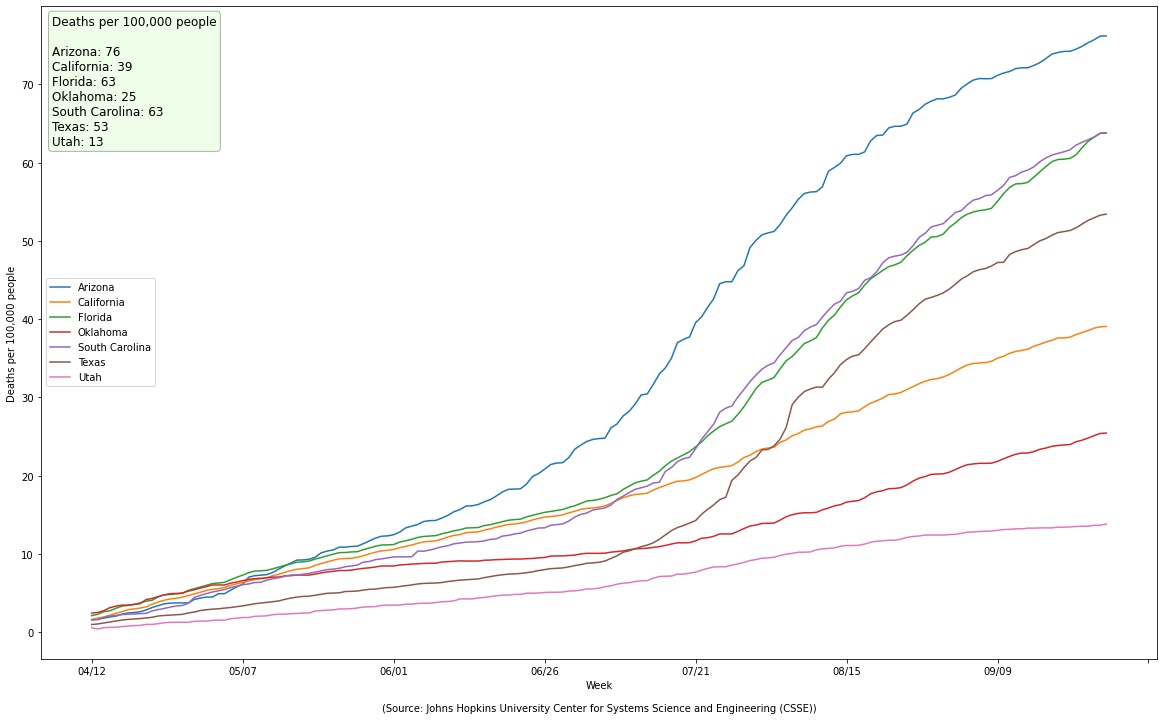

In [72]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='jhu-s-sw-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bcc14d60>)

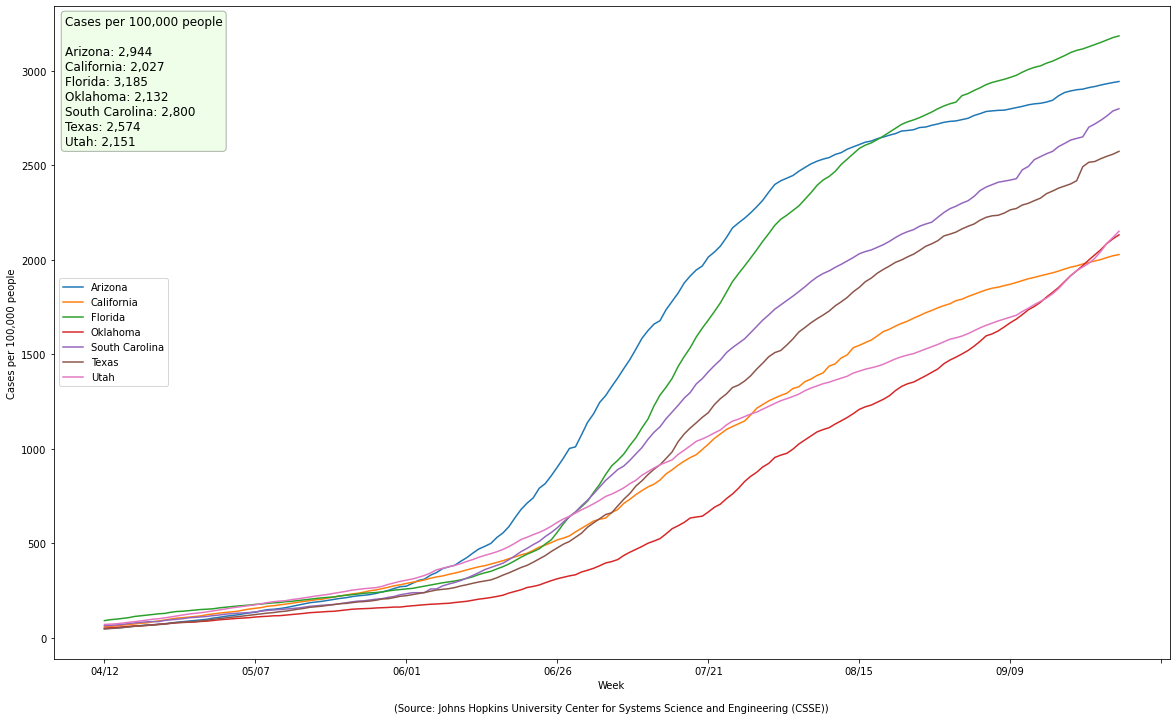

In [73]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-cases-per-capita.png')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [74]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bbea7a60>)

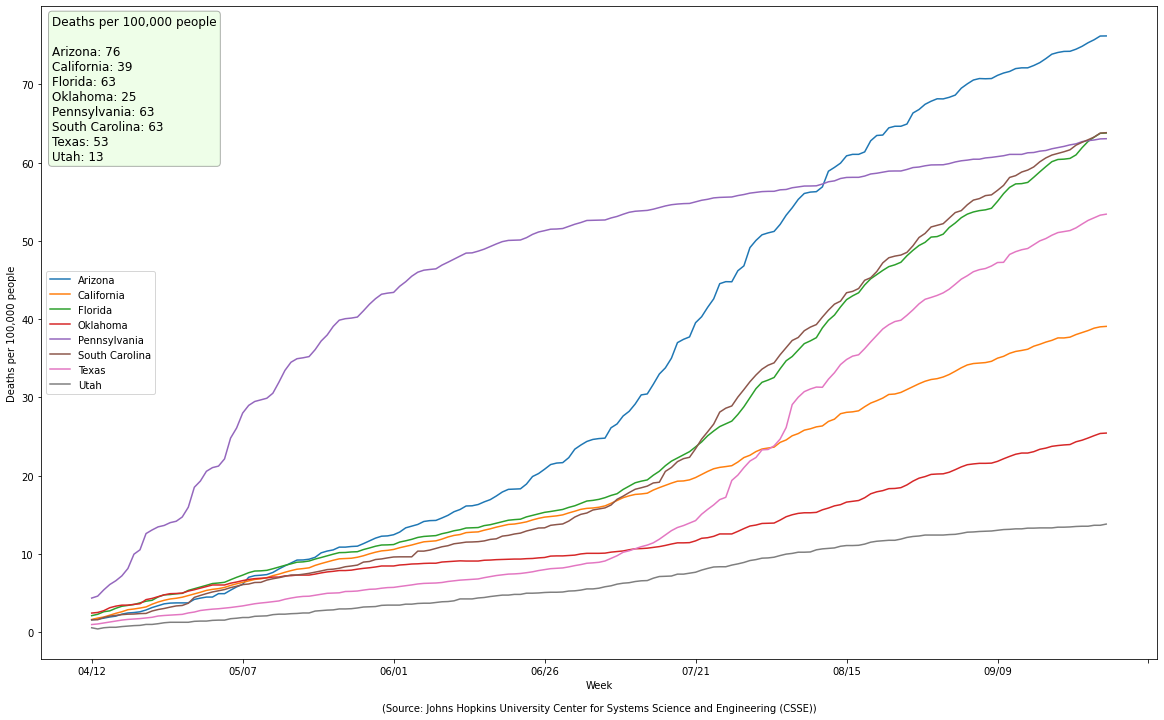

In [75]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS, 
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bd8e0dc0>)

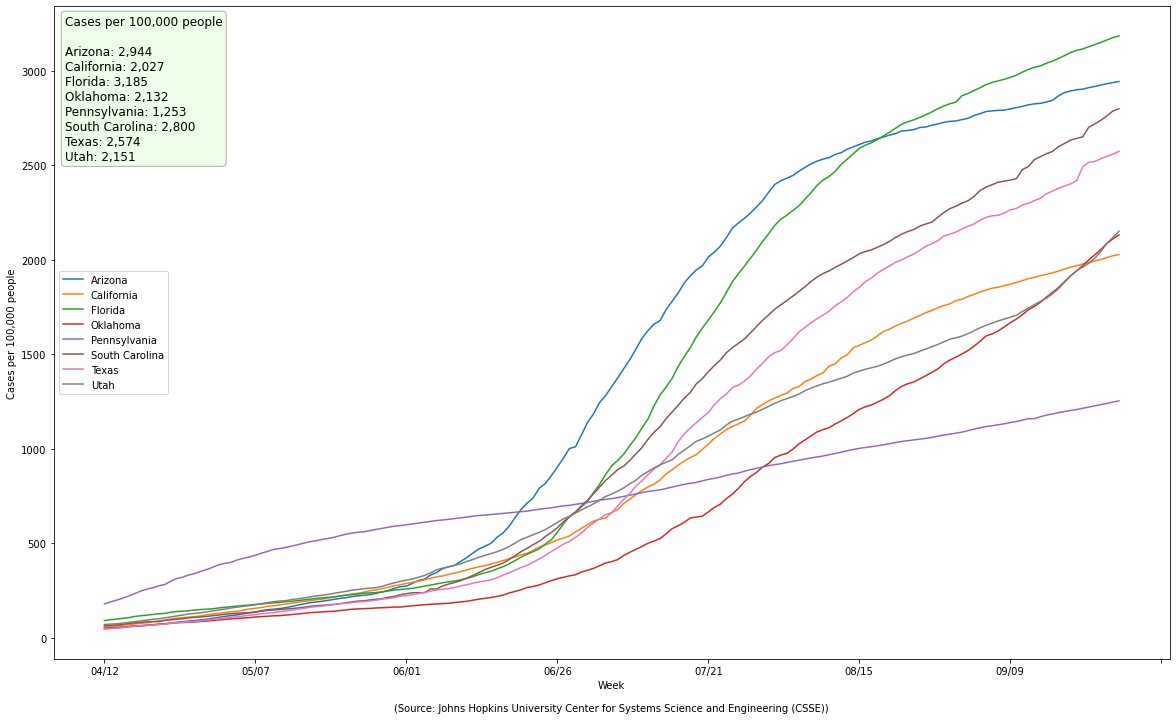

In [76]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-cases-per-capita.png')

## Per-capita rates for all states

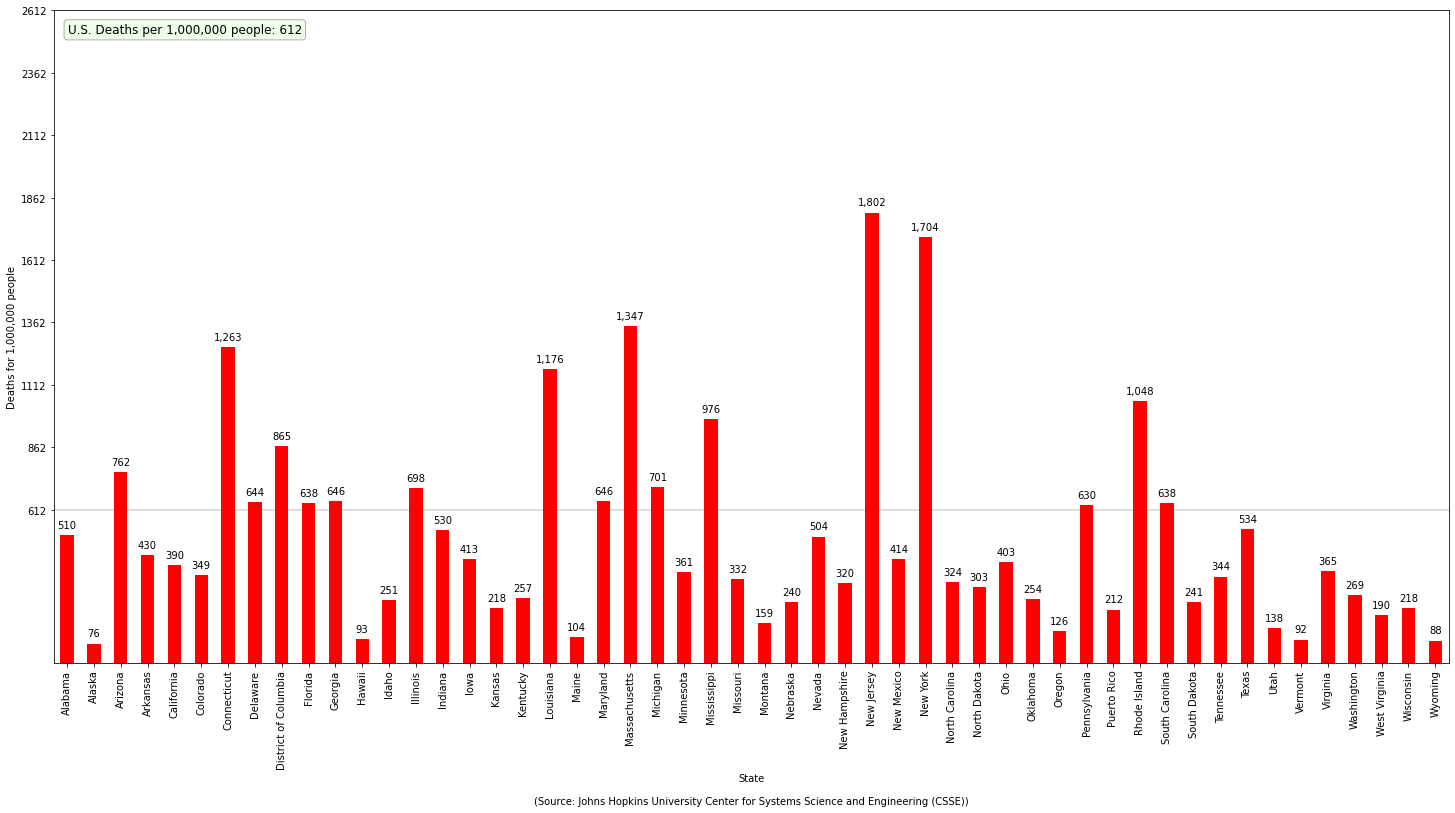

In [77]:
plot_states_per_capita(df, SOURCE, populations, image_file='jhu-state-deaths-per-capita.png');

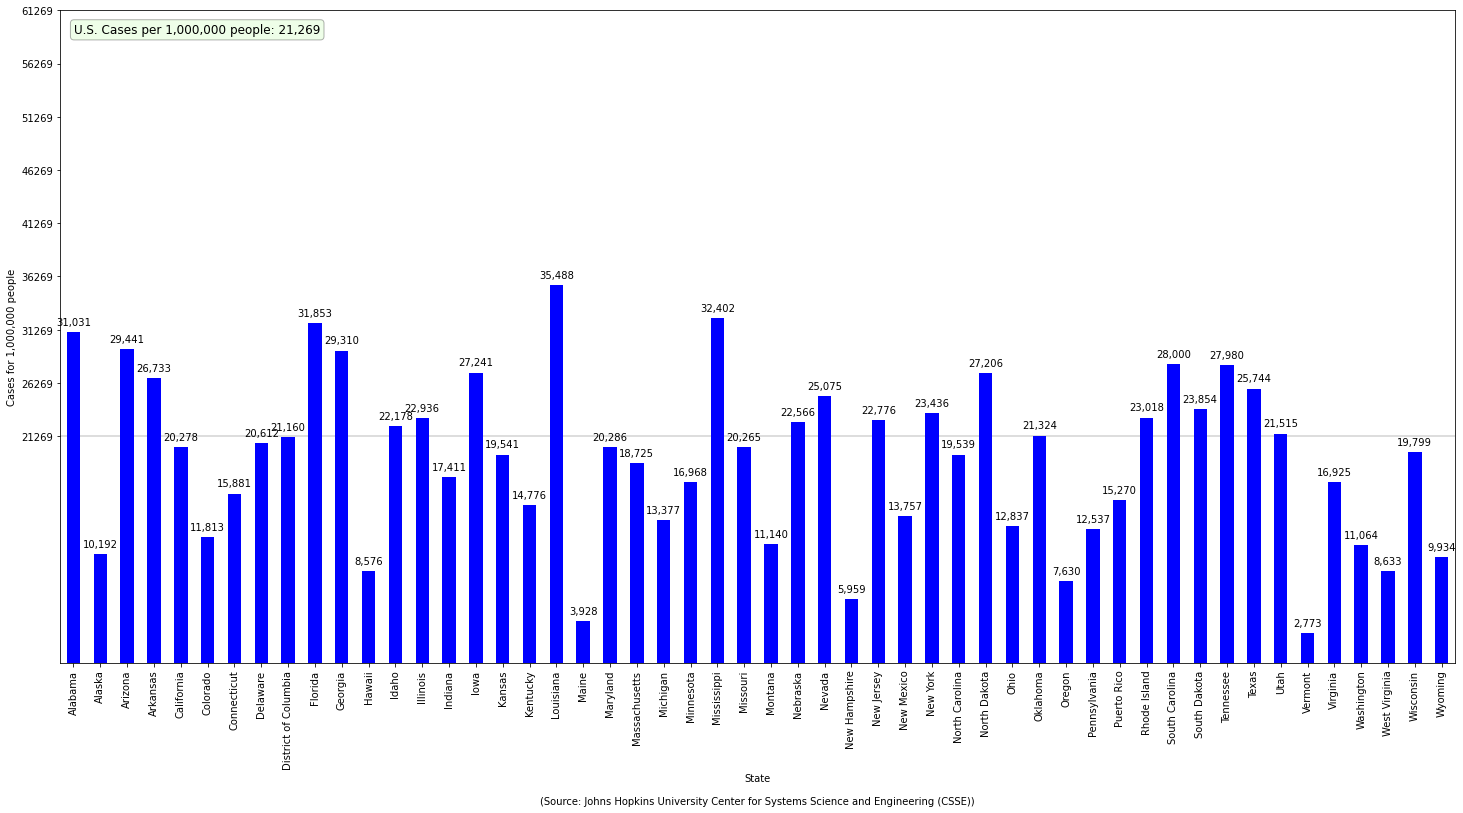

In [78]:
plot_states_per_capita(df, SOURCE, populations, metric=MetricType.CASES, image_file='jhu-state-cases-per-capita.png');

## Counties

### Some select Pennsylvania counties

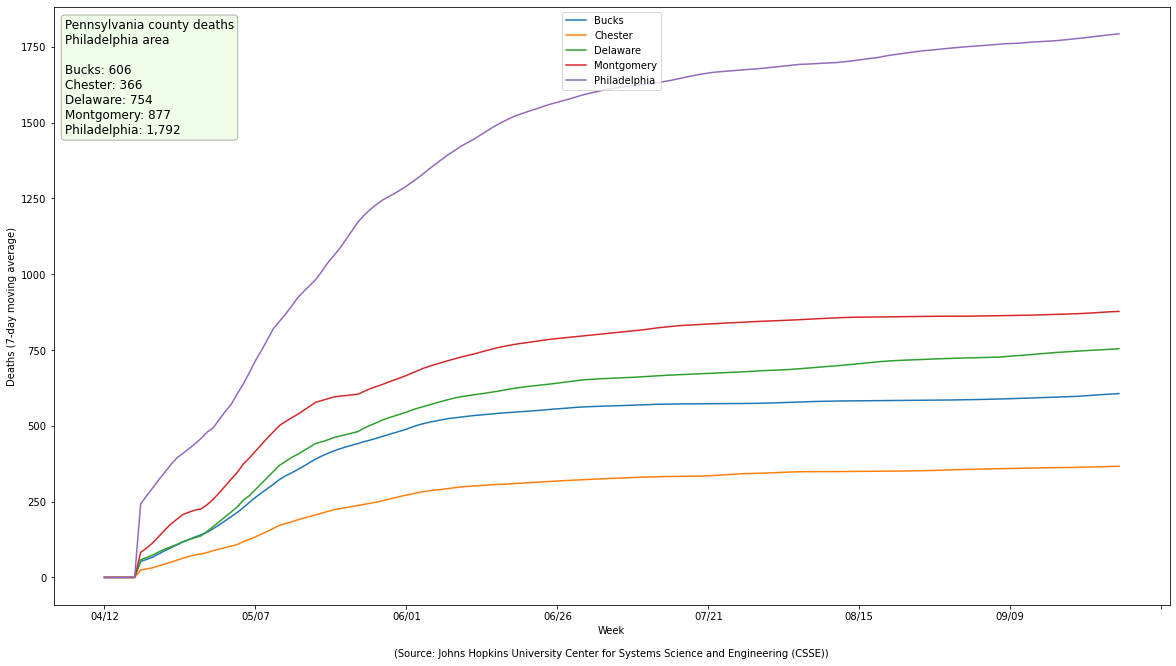

In [79]:
philly_area_counties = ('Montgomery', 'Philadelphia', 'Chester', 'Bucks', 'Delaware')
plot_counties(df_counties, 'Pennsylvania', philly_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.DEATHS, image_file='jhu-pa-phl-area-deaths.png')

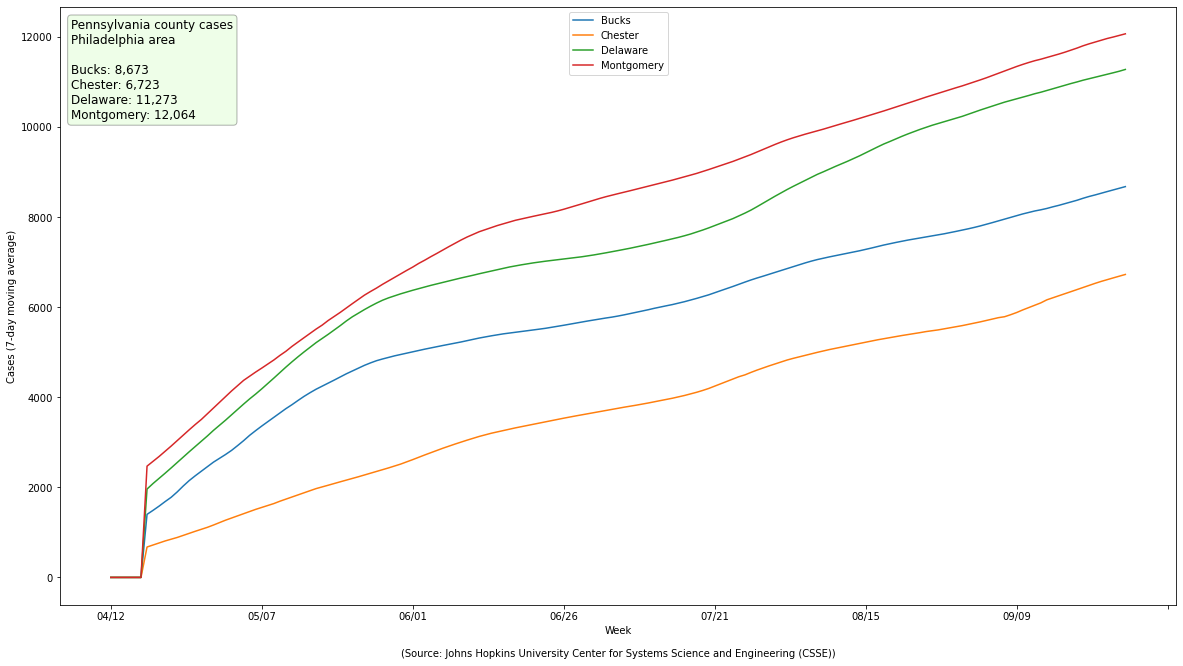

In [80]:
without_philly = set(philly_area_counties) - {'Philadelphia',}
plot_counties(df_counties, 'Pennsylvania', without_philly, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.CASES, image_file='jhu-pa-outside-phl-cases.png')

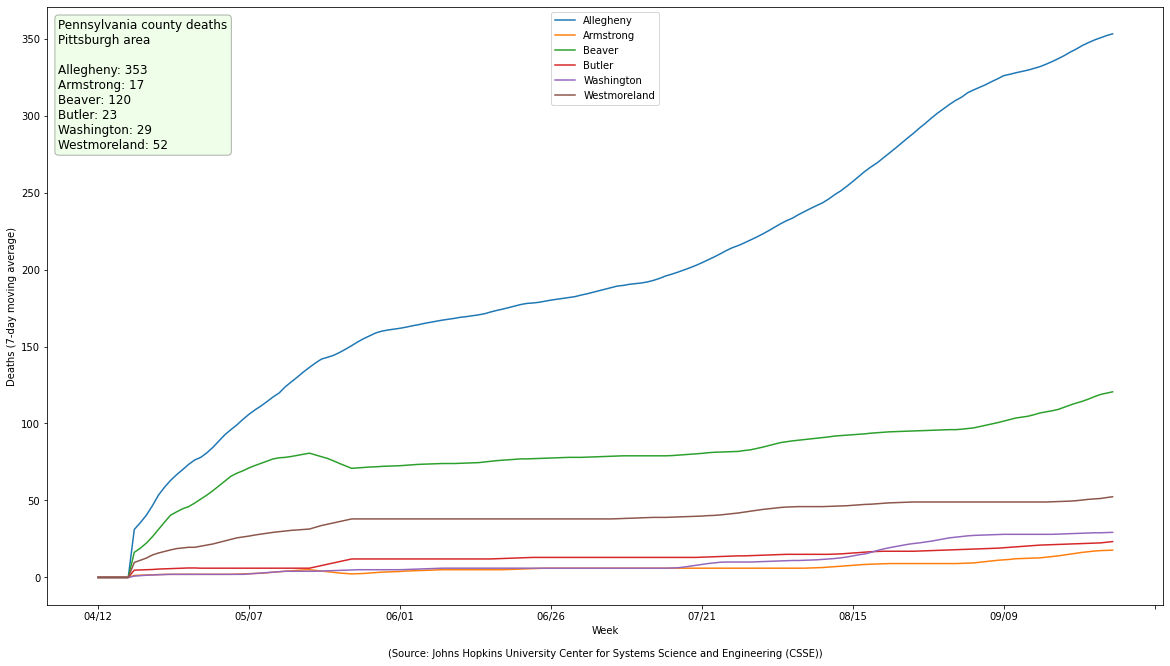

In [81]:
pgh_area_counties = ('Allegheny', 'Butler', 'Beaver',
                     'Washington', 'Westmoreland', 'Armstrong')
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.DEATHS, image_file='jhu-pgh-area-deaths.png')

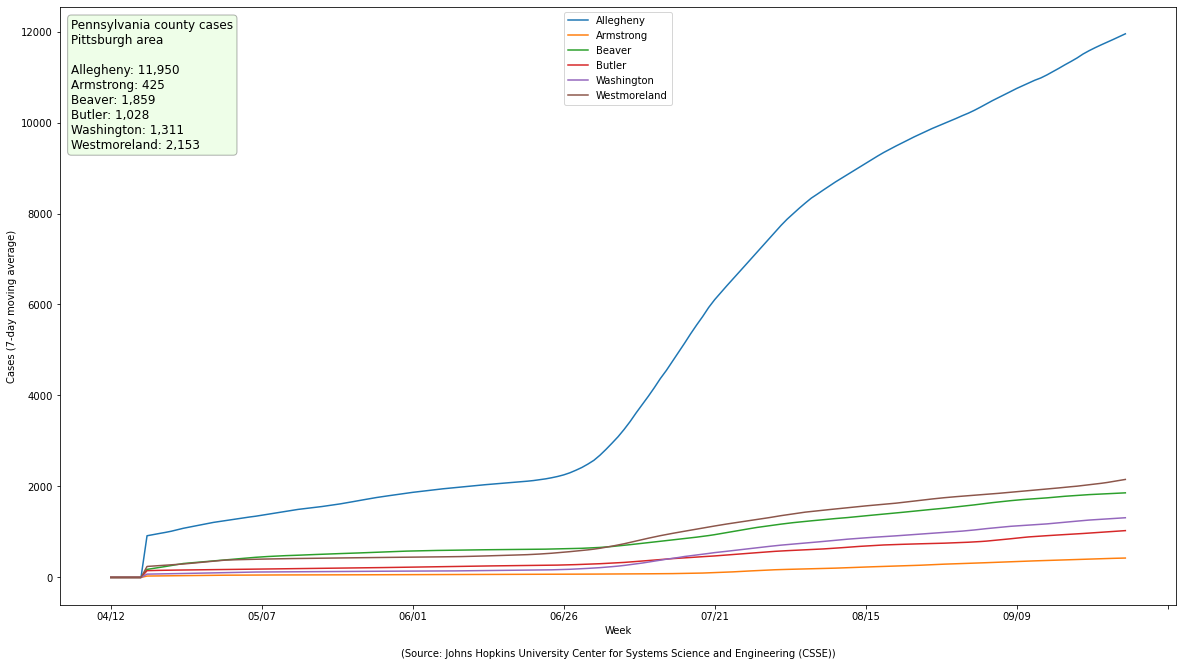

In [82]:
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.CASES, image_file='jhu-pgh-area-cases.png')

#### Some daily stats for certain counties

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc486f70>)

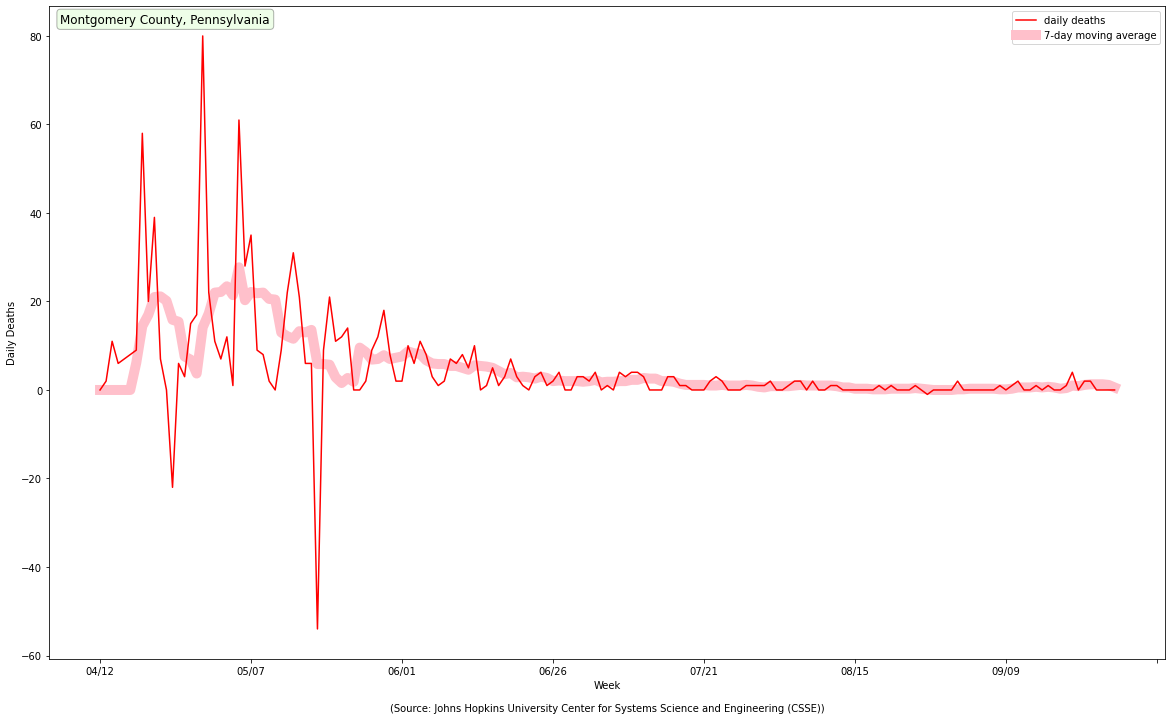

In [83]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-montgomery-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc01a5b0>)

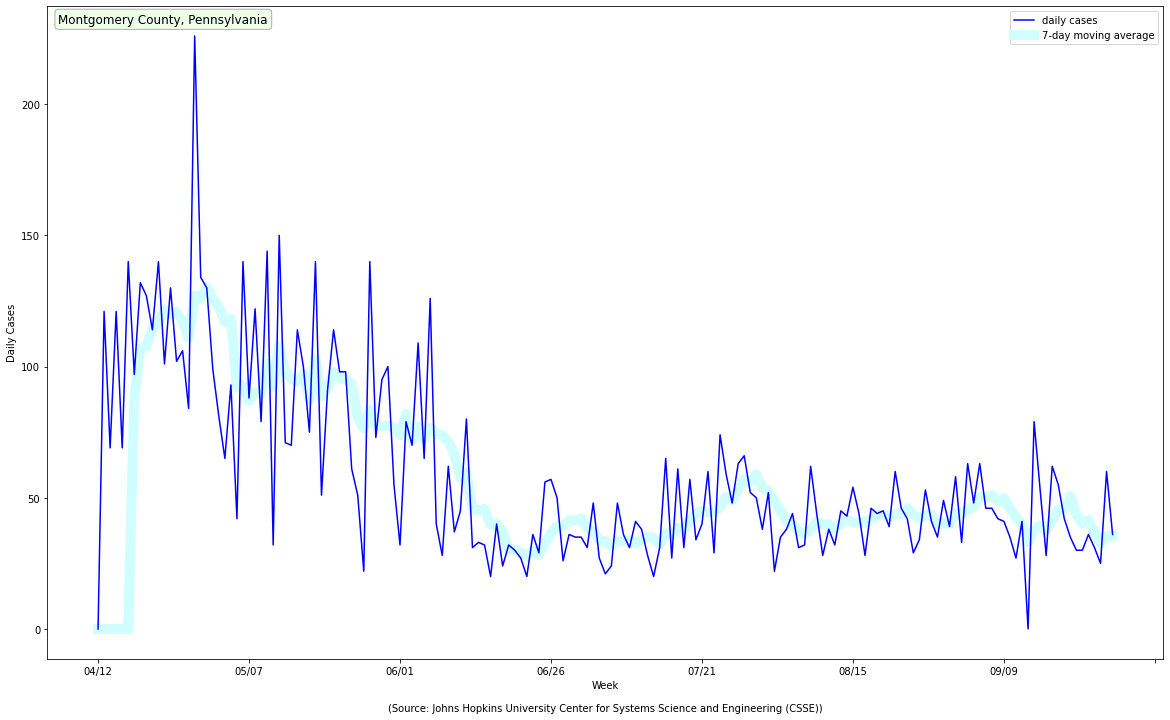

In [84]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-montgomery-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bd47d1f0>)

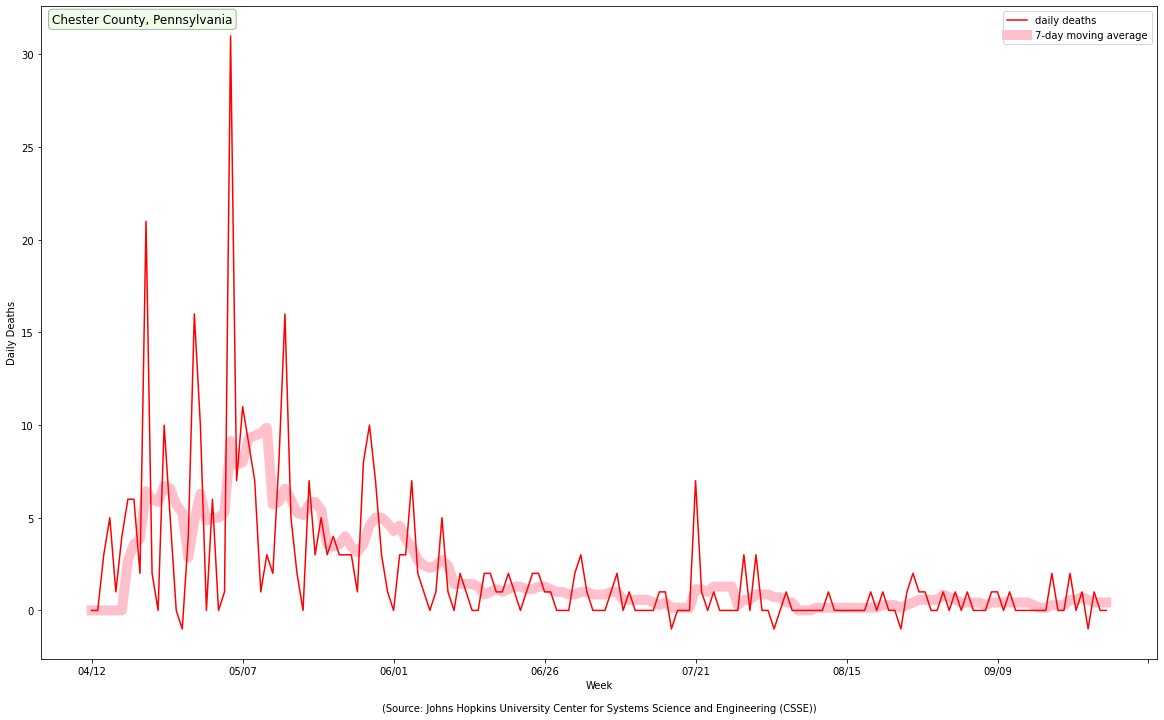

In [85]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-chester-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46b9b399a0>)

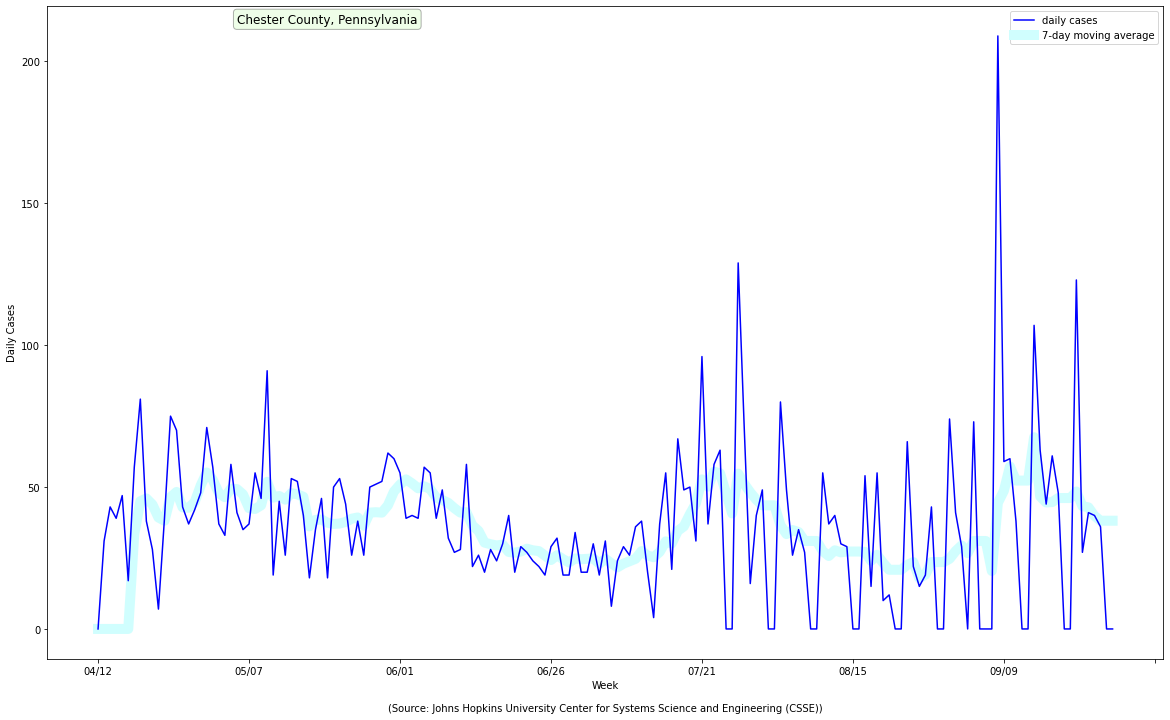

In [86]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=(0.17, 0.99), image_file='jhu-pa-chester-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bc2cbe20>)

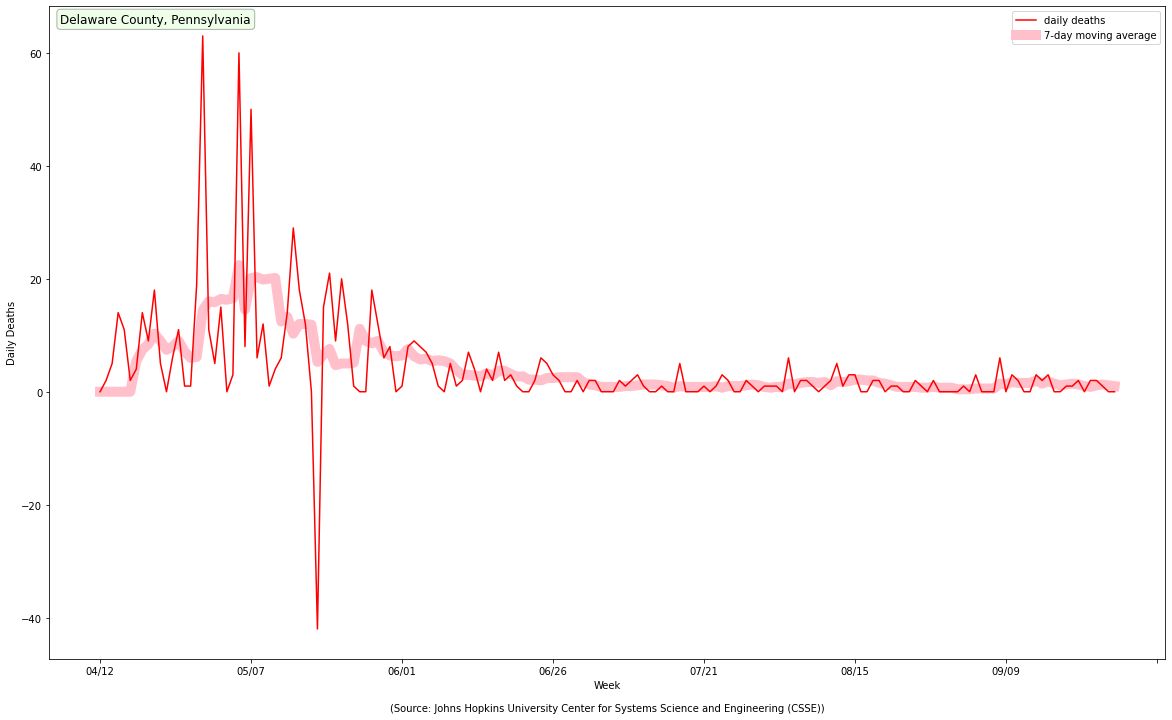

In [87]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-delaware-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bde52c10>)

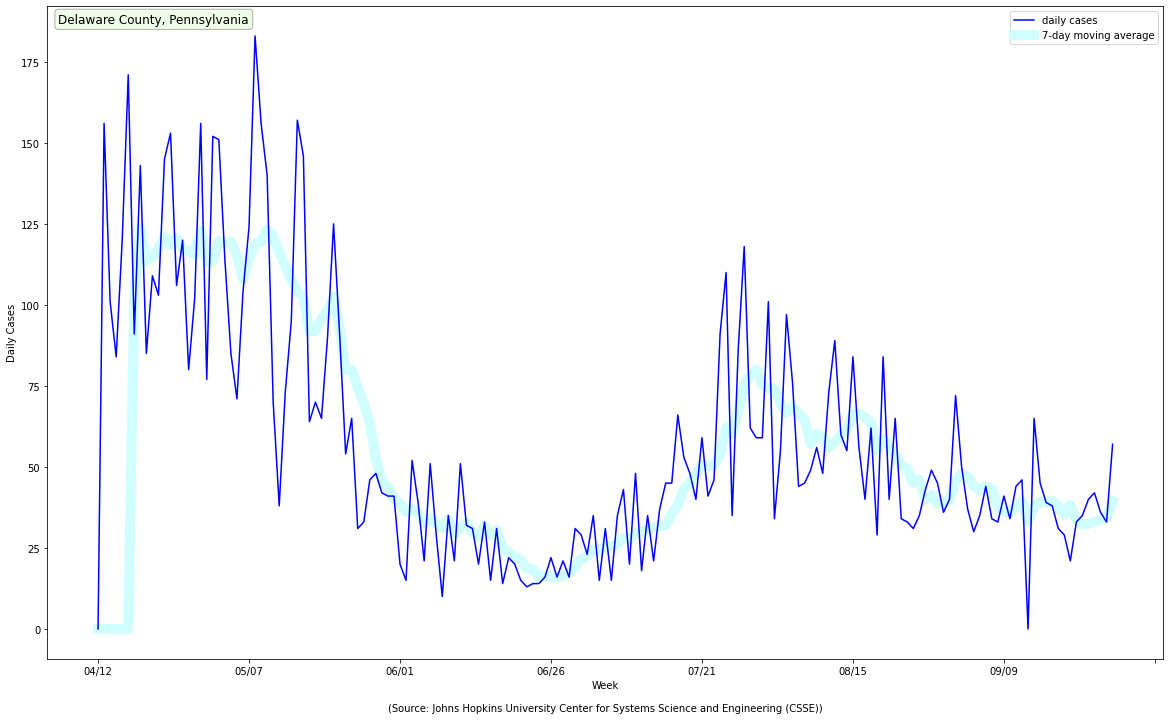

In [88]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-delaware-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46ba62cd90>)

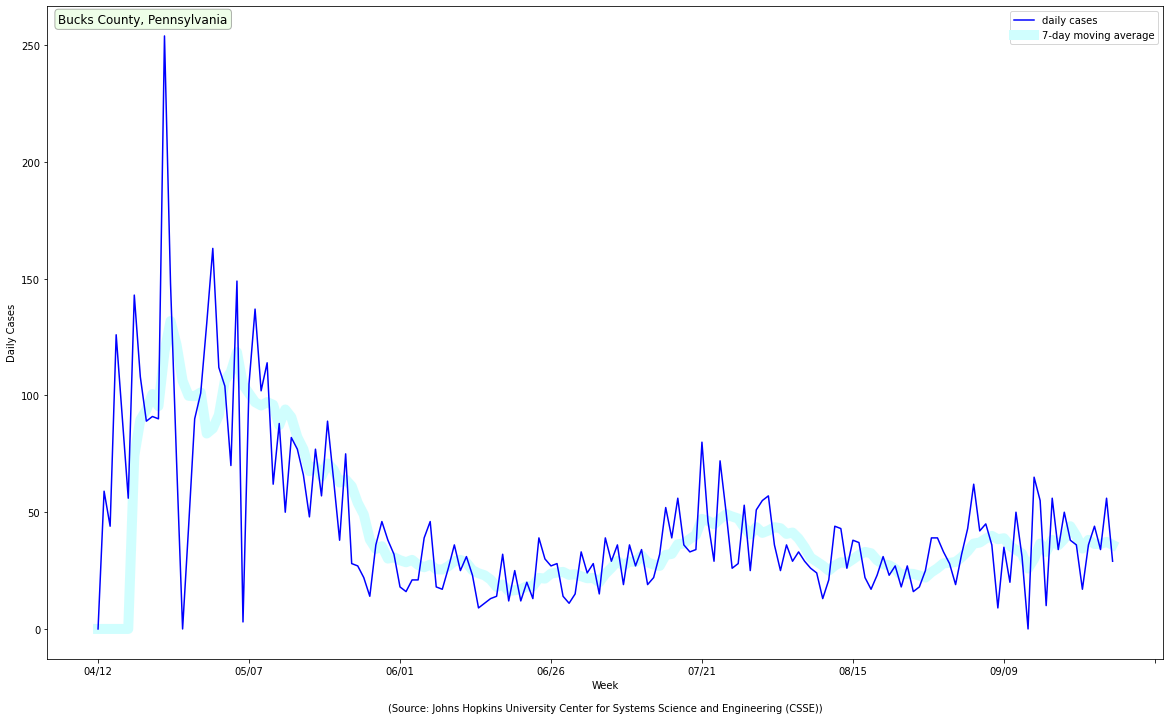

In [89]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-bucks-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46b96f3f70>)

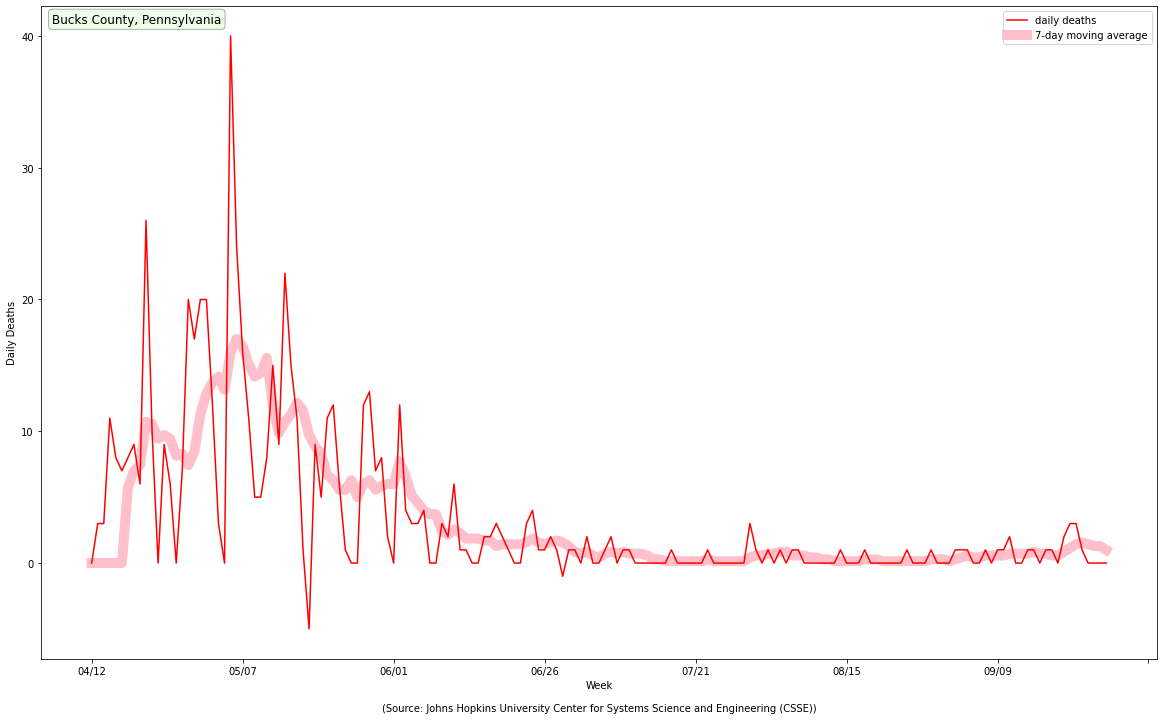

In [90]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-bucks-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46b9ee51c0>)

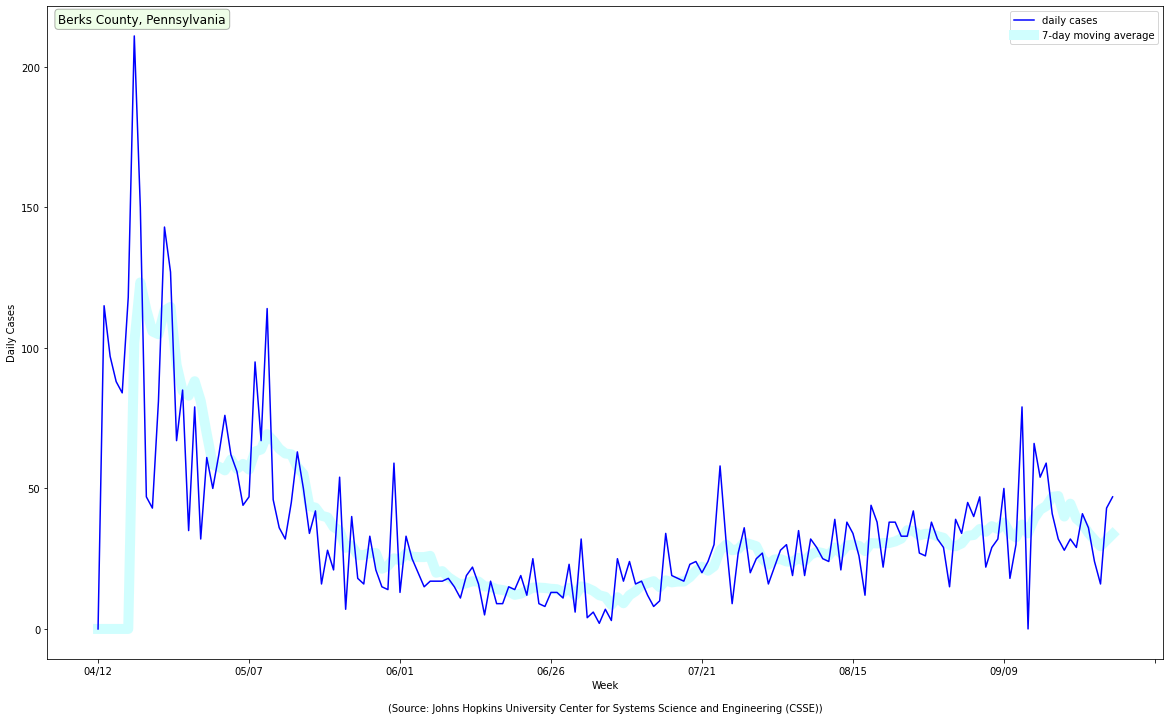

In [91]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-berks-county-daily-cases.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bbe30250>)

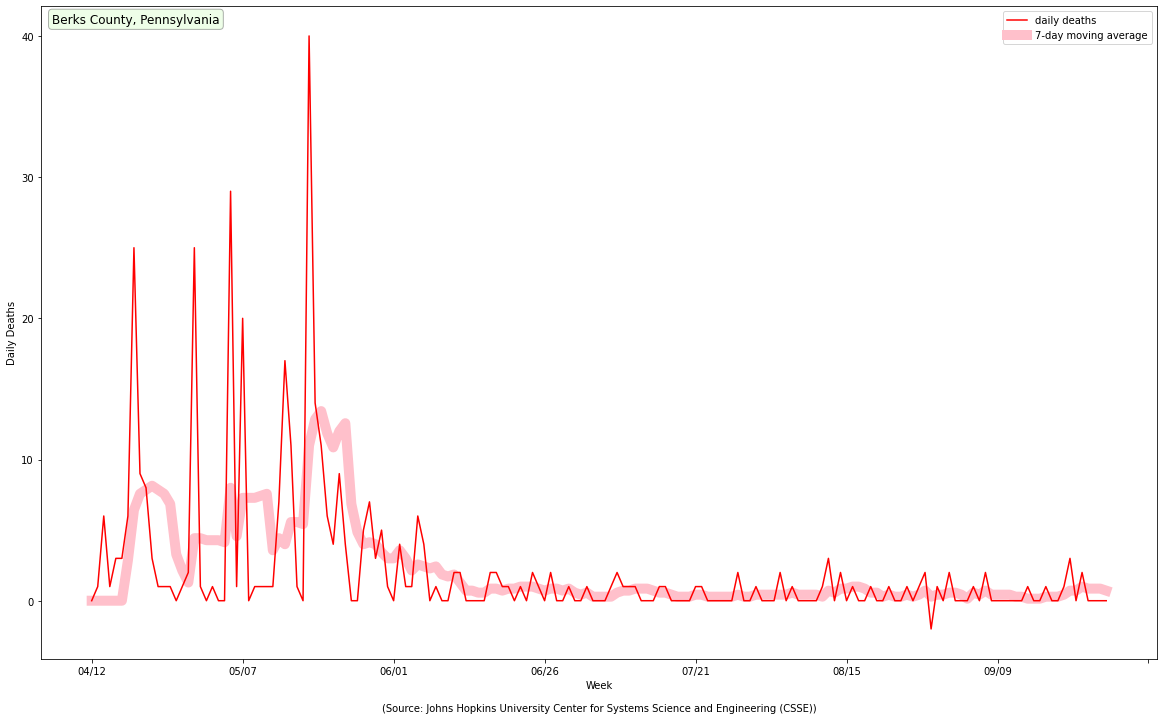

In [92]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-berks-county-daily-deaths.png')

### Florida 

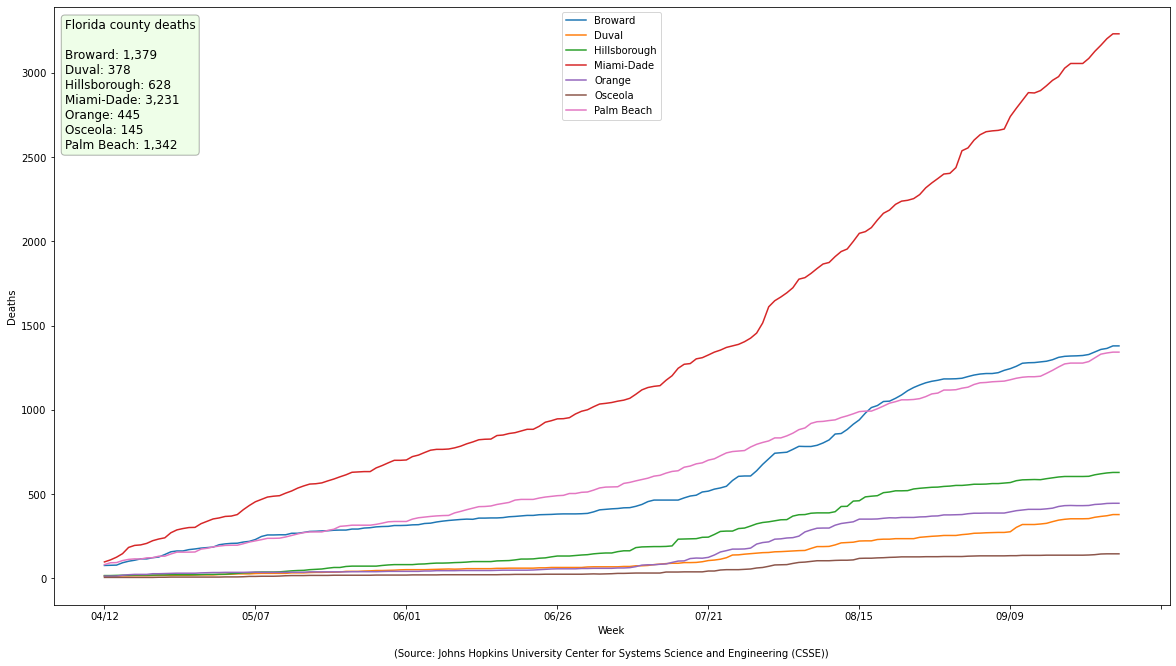

In [93]:
# Osceola and Orange are near Orlando.
# Hillsborough contains Tampa.
# Broward and Palm Beach are near Miami.
# Duval contains Jacksonville.
fl_counties = ('Osceola', 'Orange', 'Miami-Dade', 'Palm Beach',
               'Broward', 'Hillsborough', 'Duval')
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='jhu-fl-county-deaths.png', source=SOURCE, metric=MetricType.DEATHS)

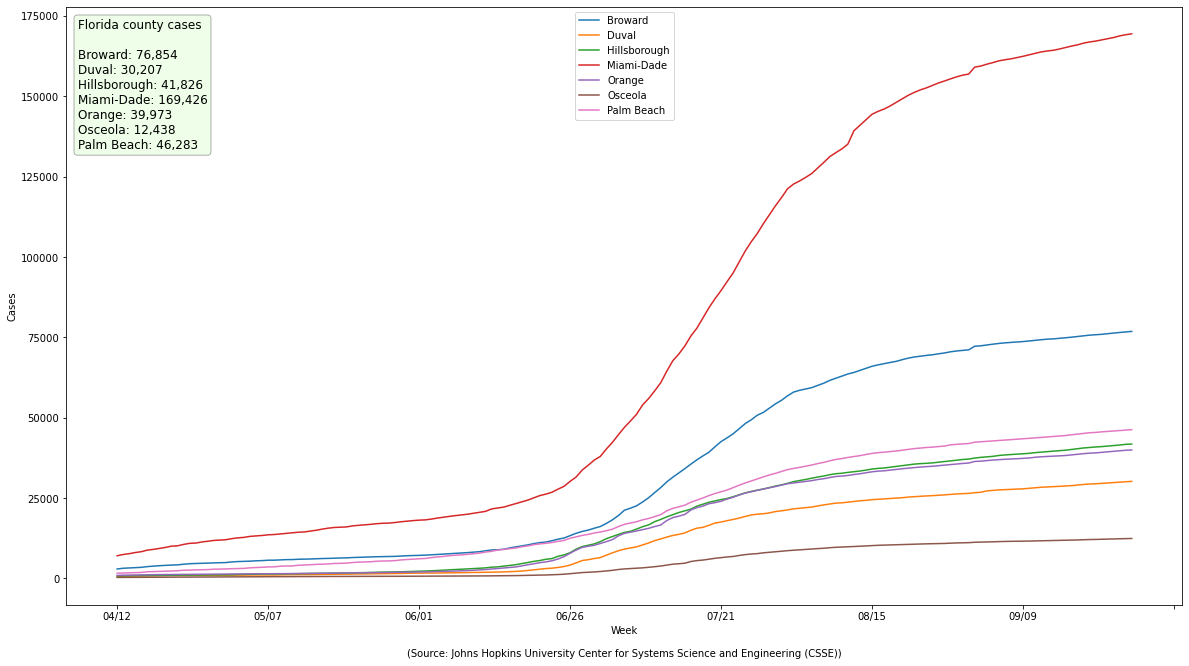

In [94]:
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-cases.png', source=SOURCE, metric=MetricType.CASES)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46ba525430>)

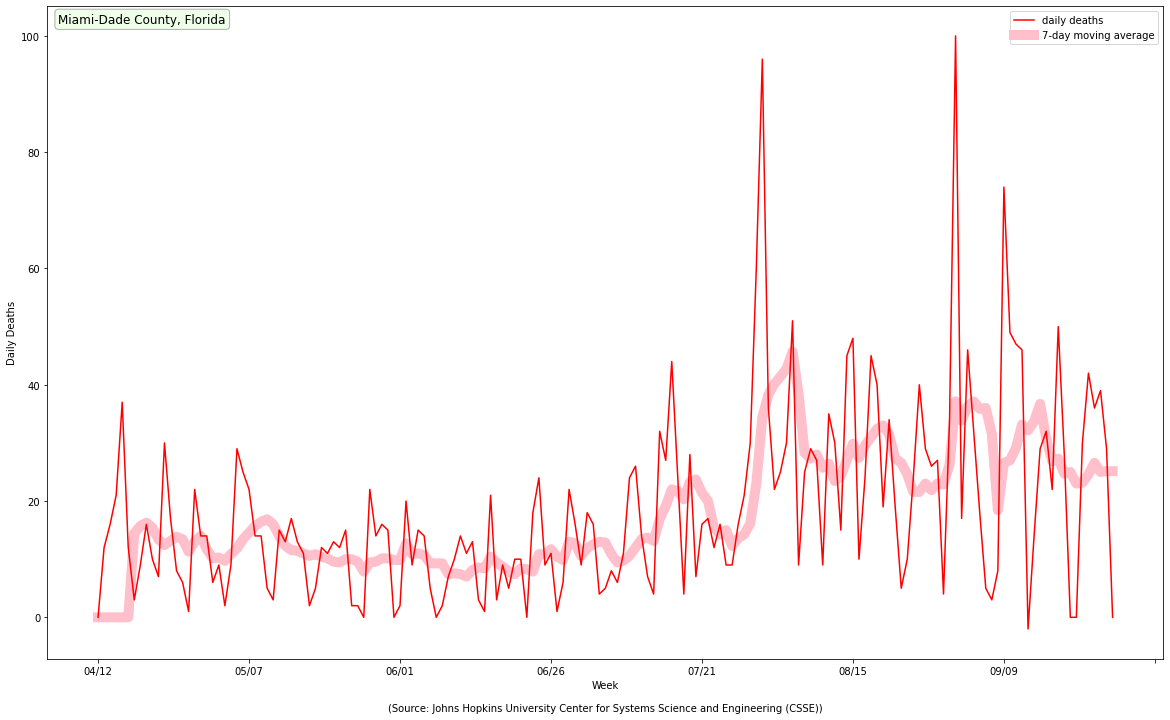

In [95]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-fl-miami-county-daily-deaths.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f46bd8ae370>)

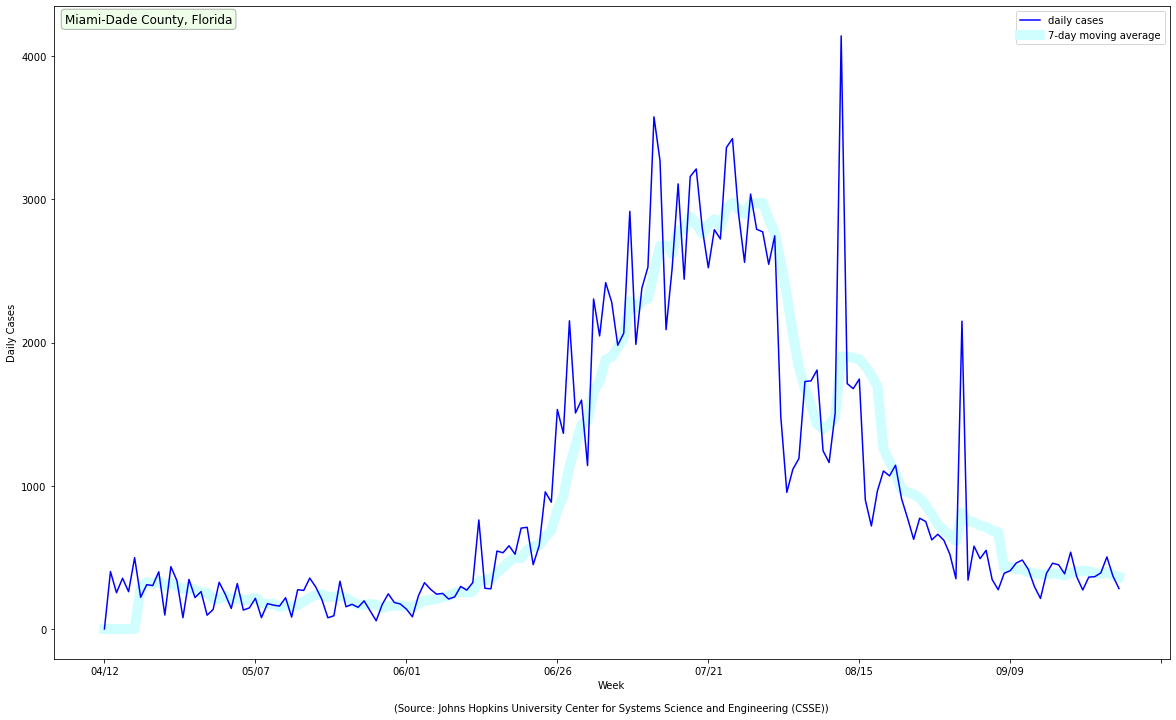

In [96]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-fl-miami-county-daily-cases.png')

### New York City

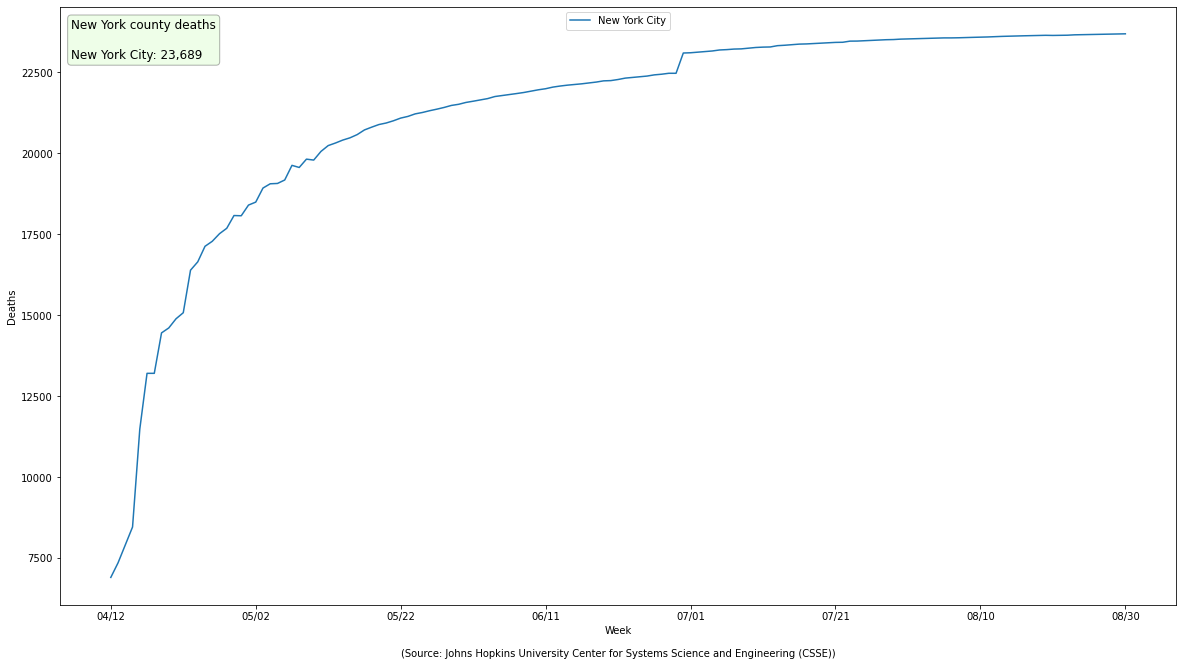

In [97]:
# The NY Times data coalesces the five New York City counties
# into "New York City".
plot_counties(df_counties, 'New York', ['New York City'], source=SOURCE, 
              image_file='jhu-nyc-county-deaths.png', metric=MetricType.DEATHS)